In [2]:
import numpy as np
import random
import pygame as pg

random.randrange(10,50)

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


16

In [9]:
from scipy.spatial import distance
import enum 
import copy 

SENSE_FACTOR = 2

class Block:
    def __init__(self):
        self.content = None
    
    def set_content(self, content):
        self.content = content
        
class State(enum.Enum):
    FIND_FOOD = 0
    GO_BACK = 1

class Organism:
    color = (255, 255, 255)
    food_found = 0
    state = State.FIND_FOOD
    energy = 0
    
    def __init__(self, size, speed, sense, max_w, max_h):
        self.size = size
        self.speed = speed
        self.sense = sense
        
        self.max_w = max_w-1
        self.max_h = max_h-1
        
        a = random.uniform(-1,1)
        b = np.sqrt(1-a*a)
        self.direction = np.array([a, b])
        
        # Organism starts at a border
        if random.random() > 0.5:
            x = random.uniform(0, max_w-1)
            y = 0
            if random.random() > 0.5:
                y = max_h-1
        else:
            y = random.uniform(0, max_h-1)
            x = 0
            if random.random() > 0.5:
                x = max_w-1
        self.position = np.array([x, y])
        
    def energy_cost(self):
        return ((self.size**3)*self.speed**2)+self.sense
    
    def get_coordinates(self):
        return self.position
    
    def reproduce(self, energy):
        offspring = copy.deepcopy(self)
        mutation_chance = 0.1
        
        offspring.size += (mutation_chance>random.random())*self.size *random.randrange(10,50)*0.01 * (2*(0.5>random.random())-1)
        offspring.speed += (mutation_chance>random.random())*self.speed*random.randrange(10,50)*0.01 * (2*(0.5>random.random())-1)
        offspring.sense += (mutation_chance>random.random())*self.sense*random.randrange(10,50)*0.01 * (2*(0.5>random.random())-1)
        offspring.energy = energy      
        offspring.state = State.FIND_FOOD
        
        return offspring
    
    def attributes(self):
        return np.array([self.size, self.speed, self.sense])
    
    def closest_border(self):
        borders = [[self.position[0], 0], [self.max_w, self.position[1]], [self.position[0], self.max_h],[0, self.position[1]]]
        distances = distance.cdist([self.get_coordinates()], borders, 'euclidean')[0]
        closest_idx = np.argmin(distances)
        
        return distances[closest_idx], borders[closest_idx][0], borders[closest_idx][1]
    
    def walk(self, env):
        distances = []
        step_size = self.speed
        direction = self.direction
        
        if len(env["food"]) > 0:
            distances = distance.cdist([self.get_coordinates()], env["food"], 'euclidean')[0]
            closest_idx = np.argmin(distances)
        
        if self.state == State.GO_BACK:
            dist, x, y = self.closest_border()
            step_size = dist if abs(dist) < step_size else step_size
            
            d = np.array([x, y]) - self.position
            norm = np.linalg.norm(d)
            if norm == 0:
                return
            direction = d/norm   
        elif (len(distances) > 0) and (distances[closest_idx] <= (self.sense * SENSE_FACTOR)):
            step_size = distances[closest_idx] if abs(distances[closest_idx]) < step_size else step_size
            
            d = env["food"][closest_idx] - self.position
            norm = np.linalg.norm(d)
            if norm == 0:
                return
            direction = d/norm           
        else:            
            #x2=cosβx1−sinβy1, y2=sinβx1+cosβy1
            
            r = random.uniform(-np.pi/2, np.pi/2)
            direction = np.array([np.cos(r*direction[0]) - np.sin(r*direction[1]), 
                                  np.sin(r*direction[0]) + np.cos(r*direction[1])])
            print(r, direction, self.direction, np.linalg.norm(direction))
            self.direction = direction
        
        if self.energy >= self.energy_cost():
            self.position += step_size*direction
        
        self.energy -= self.energy_cost()   
    

In [102]:
import numpy as np
import random
import pygame as pg


SCREEN_WIDTH, SCREEN_HEIGHT = 800,600
ENV_WIDTH, ENV_HEIGHT = 50, 40

BACK_COLOR = (100, 100, 100)
BLOCK_COLOR = (200, 200, 200)
MAZE_COLOR = (255, 255, 255)
UNVISITED_COLOR = (200, 200, 200)


BLOCK_SIZE = 10  # Pixel size/Wall thickness

ENV_WIDTH_PX = BLOCK_SIZE * ENV_WIDTH 
ENV_HEIGHT_PX = BLOCK_SIZE * ENV_HEIGHT 
ENV_TOP_LEFT_CORNER = (SCREEN_WIDTH // 2 - ENV_WIDTH_PX // 2, SCREEN_HEIGHT // 2 - ENV_HEIGHT_PX // 2)

MINUTES_PER_DAY = 100
DAY_ENERGY = 40*MINUTES_PER_DAY


pg.init()
screen = pg.display.set_mode((SCREEN_WIDTH, SCREEN_HEIGHT))

def init_organisms(n, attr):
    organisms = []
    for _ in range(n):
        o = Organism(attr[0], attr[1], attr[2], ENV_WIDTH, ENV_HEIGHT)
        o.energy = DAY_ENERGY
        organisms.append(o)
    return organisms


def draw(color, x, y):
    pg.draw.rect(screen, color, (x+1, y+1, BLOCK_SIZE-1, BLOCK_SIZE-1))

def draw_environment(screen, env):
        screen.fill(BACK_COLOR)
        pg.draw.rect(screen, (0,0,0), (ENV_TOP_LEFT_CORNER[0], ENV_TOP_LEFT_CORNER[1],
                                               ENV_WIDTH_PX, ENV_HEIGHT_PX))
        draw_xy, color = np.array([0,0]), None
        for o in env["organisms"]:
            color = o.color
            draw_xy = o.position*BLOCK_SIZE + ENV_TOP_LEFT_CORNER
            draw(color, draw_xy[0], draw_xy[1])
        for xy in env["food"]:
            color = (0,255,0)
            draw_xy = xy*BLOCK_SIZE + ENV_TOP_LEFT_CORNER
            draw(color, draw_xy[0], draw_xy[1])

def kill(env):
    kill_counter = 0
    
    for o in env["organisms"].copy():
        dist_to_border, _, _ = o.closest_border()
        if (o.energy <= 0) or (dist_to_border > 1):
            env["organisms"].remove(o)
            kill_counter += 1
    #print("{} organisms killed".format(kill_counter))
            
            
def sleep_and_reproduce(env):
    babies = []
    for o in env["organisms"]:
        if o.food_found >= 2:
            babies.append(o.reproduce(DAY_ENERGY))
        o.food_found = 0
        o.energy = DAY_ENERGY
        o.state = State.FIND_FOOD
    env["organisms"].extend(babies)
    #print("{} babies born".format(len(babies)))
                
def do_one_step(env, m):
    minutes_left = MINUTES_PER_DAY - m
    
    attributes = np.array([o.attributes() for o in env["organisms"]])
    max_attr = np.max(attributes)
    
    for o in env["organisms"]:
        o.walk(env)
        pos = o.get_coordinates()
        
        for i, food in enumerate(env["food"]):
            if np.linalg.norm(food-pos)<=0.01:
                env["food"].pop(i)
                o.food_found += 1
                dist_to_border, _, _ = o.closest_border()
                if (o.food_found > 1) or (dist_to_border/o.speed >= minutes_left-5):
                    o.state = State.GO_BACK
                break
            
        pos = o.get_coordinates()%np.array([(ENV_WIDTH-1), (ENV_HEIGHT-1)])
        #min(max(x,0),ENV_WIDTH-1)
        #min(max(y,0), ENV_HEIGHT-1)
        o.position = pos
        o.color = o.attributes()*255/max_attr
                
def run_simulation():
    pg.display.update()
    
    env = {"food" : [], "organisms" : []}
    n_food = 100
    for f in range(n_food):
        x, y = random.randrange(1,ENV_WIDTH-1), random.randrange(1,ENV_HEIGHT-1)
        env["food"].append(np.array([x, y]))
        
    organisms = init_organisms(100, (2, 1, 2))
    env["organisms"].extend(organisms)
    # Main game loop
    run = True
    
    time_keeper = {"day":0, "minute":0}
    stats = {"population":[len(organisms)], "attributes":[[o.attributes() for o in organisms]]}
    while run:
        for event in pg.event.get():
            if event.type == pg.QUIT:
                run = False
        
        if len(env["organisms"]) == 0:
            run = False
            continue
        
        # do one simulation step
        do_one_step(env, time_keeper["minute"])
        time_keeper["minute"] += 1
        if time_keeper["minute"] >= 100:#24*60:
            time_keeper["minute"] = 0
            time_keeper["day"] += 1
            kill(env)
            sleep_and_reproduce(env)
            for f in range(n_food):
                x, y = random.randrange(1,ENV_WIDTH-1), random.randrange(1,ENV_HEIGHT-1)
                env["food"].append(np.array([x, y]))
            pg.time.wait(3)
            
            attributes = np.array([o.attributes() for o in env["organisms"]])
            
            stats["population"].append(len(env["organisms"]))
            stats["attributes"].append(attributes)
        
        
        draw_environment(screen, env)
        pg.display.update()
        pg.time.wait(1)
        pg.event.pump()

    pg.quit()
    return stats

def run_ntimes(ndays):    
    env = {"food" : [], "organisms" : []}
    n_food = 10
    for f in range(n_food):
        x, y = random.randrange(1,ENV_WIDTH-1), random.randrange(1,ENV_HEIGHT-1)
        env["food"].append(np.array([x, y]))
        
    organisms = init_organisms(10, (2, 1, 2))
    env["organisms"].extend(organisms)
    
    # Main game loop
    
    time_keeper = {"day":0, "minute":0}
    stats = {"population":[len(organisms)], "attributes":[[o.attributes() for o in organisms]]}
    
    while time_keeper["day"] <= ndays:
   
        # do one simulation step
        do_one_step(env, time_keeper["minute"])
        time_keeper["minute"] += 1
        if time_keeper["minute"] >= 100:#24*60:
            time_keeper["minute"] = 0
            time_keeper["day"] += 1
            kill(env)
            sleep_and_reproduce(env)
            for f in range(n_food):
                x, y = random.randrange(1,ENV_WIDTH-1), random.randrange(1,ENV_HEIGHT-1)
                env["food"].append(np.array([x, y]))

            attributes = np.array([o.attributes() for o in env["organisms"]])

            stats["population"].append(len(env["organisms"]))
            stats["attributes"].append(attributes)
    
    return stats


stats = run_ntimes(100)

-0.8635010091030868 [1.69999353 0.93647811] [-0.3007971   0.95368816] 1.9408681715594829
1.4462251261359471 [-0.01572785 -0.08388245] [-0.15767377  0.98749126] 0.08534419028936575
1.471233317863112 [-0.20390028 -0.37417199] [-0.48507253  0.87447392] 0.4261220507658531
0.07208103102331531 [0.93901858 1.03776802] [0.54926928 0.83564542] 1.3995421955651401
-1.0153706107595108 [1.51675081 0.10896604] [0.62564034 0.78011163] 1.5206599328552268
0.1334741480358912 [0.87025688 0.95967642] [-0.23932179  0.97094031] 1.2955021676767045
-0.8412160628043187 [1.65651728 0.40383609] [0.3695777  0.92919983] 1.7050316914579378
-0.1611089750249235 [1.12784361 0.89962848] [0.56944897 0.82202668] 1.4426928340477594
-1.511573039383612 [ 1.33524256 -0.38875602] [0.71793961 0.69610539] 1.3906846962010244
0.940654682661358 [-0.79962037  1.63605456] [1.69999353 0.93647811] 1.8210072115677314
1.031888133105546 [1.08631757 0.98002758] [-0.01572785 -0.08388245] 1.463058414034449
-0.26876331745486226 [0.89810452 1

-0.6907633894950345 [0.2957611  0.89904744] [-0.25352552 -1.100276  ] 0.9464464704209404
0.4278516871416782 [0.54021806 1.31704189] [0.94135373 0.91046024] 1.4235290265866638
0.9931925851697807 [-0.59262849  1.38671284] [1.26665224 1.12818605] 1.5080388024438562
-0.985939911607838 [ 1.10886363 -0.32683014] [1.25883108 0.91579507] 1.1560261638563691
-0.1597670286263 [1.08407407 0.70494628] [1.82240168 0.79177519] 1.293122523890511
-0.4888391841677244 [1.46270179 0.2216875 ] [1.20234212 1.39557816] 1.4794059143585787
1.2175306370557846 [-0.56195377  0.46616972] [1.02831305 1.70458268] 0.7301412524078944
0.1471294038506581 [0.86716245 1.03476566] [0.2957611  0.89904744] 1.3500780323943884
0.4137080157892936 [0.45682173 1.07683092] [0.54021806 1.31704189] 1.1697225807012706
-0.29908244364615566 [1.38728655 1.09153872] [-0.59262849  1.38671284] 1.765225409611167
-0.9444044736228435 [0.19620213 0.08670703] [ 1.10886363 -0.32683014] 0.21450730607743296
-1.2409736763430113 [ 0.99101092 -0.3335

-1.2582637066788576 [ 1.9372702  -0.25443699] [0.27474119 1.1812153 ] 1.9539073655585175
0.8091269229256399 [0.21921184 0.44508815] [-0.25577154  1.06592333] 0.4961424080032382
1.5130968206037911 [-0.98226773  1.43501   ] [1.77626277 0.05527518] 1.7389949957899062
-0.6105109848600406 [1.33904257 0.25766685] [1.03268872 0.91746657] 1.3636081631577337
1.5247401243005023 [-0.93062985  1.01705957] [0.98479743 1.01744529] 1.3785797381791192
-0.7476438033103266 [0.94344973 1.20120898] [-0.2718574 -0.0481155] 1.5274162479504172
0.11054285196363067 [1.00527958 1.21212275] [ 1.9372702  -0.25443699] 1.574747148754256
0.06532392503686024 [0.97082667 1.01389664] [0.21921184 0.44508815] 1.4037417203206517
0.29701192542135346 [0.5443159  0.62291291] [-0.98226773  1.43501   ] 0.827224452058556
0.5961351605360643 [0.5449598  1.70436205] [1.33904257 0.25766685] 1.7893661395750078
-0.7658204598612595 [1.45908852 1.36557271] [-0.93062985  1.01705957] 1.9984314147249589
0.41268807845323074 [0.44948664 1.2

-1.0912386570369421 [ 1.78990647 -0.88382575] [0.36399812 1.91608968] 1.9962247180459067
-0.8871453595660115 [ 1.55838268 -0.38163553] [0.9919051  1.32014801] 1.6044320617186245
0.8099021698495448 [0.19392336 1.20454543] [0.61300298 0.93230676] 1.2200557213110261
-1.338226239979658 [1.2925294  1.48551654] [-0.77022834  0.66657286] 1.9691093498321208
-0.7268387207573022 [1.59351377 0.41197277] [0.48320877 0.98178348] 1.6459063466829027
1.5035246179842185 [0.07061189 0.67493653] [ 1.78990647 -0.88382575] 0.6786201894850855
-0.5059701643769521 [0.51301504 0.27212151] [ 1.55838268 -0.38163553] 0.5807189938197479
0.22939816836636595 [0.72619308 1.00653677] [0.19392336 1.20454543] 1.2411577875571762
0.9233706334325982 [-0.61181874  1.12745897] [1.2925294  1.48551654] 1.2827649431957968
0.45409369217438034 [0.56343909 1.64464289] [1.59351377 0.41197277] 1.7384803281097239
-0.3745332326686013 [1.24975285 0.94177594] [0.07061189 0.67493653] 1.564871916463882
-1.3160000468309474 [1.13113362 0.31

-1.291036952207159 [ 1.94657765 -0.45225796] [0.20756639 1.3627729 ] 1.9984248298807772
1.4802622204748137 [ 0.22159761 -0.25930344] [0.36194118 1.65466071] 0.34109203277772243
0.7359561495685512 [1.02317585 1.06057939] [ 0.08279083 -0.03401581] 1.4736748144125698
0.8940433420484553 [0.03808985 0.26620286] [-0.0081155   1.44714424] 0.2689141076481838
0.8272986644463609 [0.04824588 0.7512806 ] [0.38896775 1.35470251] 0.7528281346740975
0.6032827534541219 [0.28549498 1.34902089] [0.91528443 0.99706638] 1.3788998321173196
0.33202827879588903 [0.55304631 0.83228811] [-0.19067482  1.38879369] 0.9992816015607326
-1.5119031619867223 [-1.6198584  -0.98880446] [ 1.5030659  -1.18909423] 1.8978080746682422
0.6297955310576513 [0.15029008 1.58553455] [1.31261974 0.88140109] 1.5926414867123453
1.264099922872095 [-0.64223054  1.24623094] [0.9909252  1.00455153] 1.4019813222466053
0.22391143294823057 [0.66530202 0.98593771] [0.19335095 1.51975498] 1.1894115951040356
1.0023364068604268 [0.0667215  1.82

-0.6604074111170182 [1.84903719 0.17596457] [0.43160742 1.65958169] 1.8573912011756595
-0.6386665394856189 [0.50319322 0.09066274] [1.77560013 0.12566095] 0.5112955615579166
-1.5192245057268958 [ 0.80866521 -0.74936016] [1.14156534 0.87624105] 1.1024881334529801
1.4824534626703159 [-0.13603883 -1.07809684] [-0.4721302  1.3623805] 1.0866459198435674
-1.0007020369406903 [1.5095097  0.57495354] [0.26653177 0.5758284 ] 1.6152990740386701
-0.934186474403563 [ 1.27081801 -0.61023327] [1.32332389 1.31656024] 1.40973864957366
-0.41670325269137276 [0.91780875 0.45774299] [1.36717274 0.18195544] 1.0256225167662092
-0.822572766673683 [ 1.43580802 -0.04489874] [0.97348941 1.01213113] 1.436509851576751
0.7199015597665945 [0.09701059 1.41123639] [0.99598948 0.99529549] 1.414566792972977
0.22834009024273594 [0.87201688 1.40896966] [1.84903719 0.17596457] 1.6569879178756524
-0.7788015309912135 [0.99473937 0.61557463] [0.50319322 0.09066274] 1.1698027786700234
-1.1072291063101845 [-0.1125138  -0.105358

-0.4569221275277646 [1.42515453 0.64619041] [0.53966801 1.03480441] 1.5648090917688857
0.7259434541923966 [0.23061132 0.4489332 ] [-0.3022675   1.15869978] 0.5047004995219577
0.42259379698504973 [0.49106665 1.29179886] [0.94557085 1.05222144] 1.3819879711571936
-0.5223887371260729 [1.12228572 0.31454115] [1.29292883 0.66783569] 1.165530507741322
1.015558622737811 [-2.68241997e-05  3.65640673e-01] [0.18110992 1.36576588] 0.36564067364316877
-0.5566039043514894 [1.52856672 0.2017933 ] [1.00478077 1.3456966 ] 1.5418290296794175
-1.1482565954069135 [ 0.61015827 -0.26072238] [1.42515453 0.64619041] 0.663527901433068
0.5930614887876762 [0.72755141 1.10110639] [0.23061132 0.4489332 ] 1.3197599583152548
-1.0513821752813781 [ 1.84713329 -0.2826411 ] [0.49106665 1.29179886] 1.8686324860561851
0.6681357977182976 [0.52318576 1.65951948] [1.12228572 0.31454115] 1.7400368527197452
1.4337605809037979 [0.49944376 0.86566556] [-2.68241997e-05  3.65640673e-01] 0.9994102938449678
-1.323642407052674 [-0.1

-0.6073945115059 [0.61346841 0.24130084] [ 1.41614016 -0.06397948] 0.6592189245565288
0.22333536790312336 [0.77084818 0.71489431] [-1.20692117  0.86982496] 1.0513233510039028
0.9023455200503698 [-0.22071287  1.98144527] [1.95171634 0.03495215] 1.9936999623417195
1.0844227413000689 [-0.54930873  1.67484405] [1.2869083  0.74609856] 1.76262379882669
1.0988550238436083 [-0.53033491  1.20322599] [1.03069579 1.15438281] 1.3149174522570548
0.5488106556881842 [0.06039229 1.32081278] [1.23282463 1.46284607] 1.322192731154197
-1.1348121295979707 [ 1.70194096 -0.18254054] [-0.38487112  1.95736761] 1.7117021037973847
-1.3565866946908667 [0.99476423 0.20746932] [0.61346841 0.24130084] 1.0161689825481326
1.0398476151594926 [0.01880253 1.45462979] [0.77084818 0.71489431] 1.4547513016176588
1.021478273085088 [ 0.0756453  -0.66139931] [-0.22071287  1.98144527] 0.6657110901158317
0.6522329610021451 [0.04877329 0.10970495] [-0.54930873  1.67484405] 0.12005835470297815
-0.7360787894990507 [1.69910755 1.01

1.1895713543717337 [0.02358304 1.99234735] [ 1.38341031 -0.0828378 ] 1.9924869141670305
0.10435097706373386 [1.10360882 1.15487374] [ 1.55655648 -1.12158338] 1.5973996973058946
1.4277823239545415 [-1.45299963  1.30036104] [1.84611755 0.43178827] 1.9499094231973535
0.3862171000397827 [0.75789235 1.63582825] [1.78450302 0.03588537] 1.8028685096210857
0.44168228645368623 [0.50893452 1.36411169] [1.03756934 0.90185321] 1.4559584594759576
-1.3657162190077519 [ 1.40780017 -0.94504157] [0.02358304 1.99234735] 1.6955839392013763
0.7737170306286436 [-0.12223592  1.38048908] [1.10360882 1.15487374] 1.3858902279635241
0.11317535280631819 [0.83987142 0.82548659] [-1.45299963  1.30036104] 1.1776298746788394
-0.5905126121073542 [1.7241172  0.13585967] [0.75789235 1.63582825] 1.7294617534691084
0.23997319717275878 [0.67101621 1.06872491] [0.50893452 1.36411169] 1.2619174650502278
-0.36792914401196475 [0.52808152 0.44503799] [ 1.40780017 -0.94504157] 0.6906003962466891
-0.6141327107870712 [1.74701258 

-0.4466306921916601 [1.01418774 0.59919787] [0.91206177 0.21530958] 1.1779706558920633
0.4443835130696292 [1.05151073 1.49786285] [ 1.22317907 -0.44310398] 1.8301005270339417
0.8118563814746871 [-0.02680322  1.20711234] [0.82568931 1.1638225 ] 1.2074098767322277
0.07569182052032297 [1.05419758 1.08260634] [ 1.11472596 -0.7634543 ] 1.5110820680036448
1.397802410078564 [-1.06355312  1.15743046] [1.17853976 1.00854061] 1.5718748361973622
0.2750573135752721 [0.97222025 1.27430758] [ 1.01043649 -0.03851724] 1.6028324967609233
-0.03817639830069486 [1.04086637 1.02226412] [-0.60541368  1.07776178] 1.4589128593306588
-1.0623560004286832 [1.47861658 0.01261185] [0.68732568 0.77521395] 1.47867036824275
-0.474364227381191 [1.04160356 0.92204419] [0.16240322 0.09398749] 1.3910799589710283
1.095965356416182 [-0.16720227  1.68838231] [1.01418774 0.59919787] 1.6966412143377596
-1.1207893948463876 [ 1.37646538 -1.03182471] [1.05151073 1.49786285] 1.720267185193304
0.12970715566222268 [0.84406178 0.984

0.8307425411283451 [0.64338984 0.84170814] [-0.11359899  0.43320095] 1.0594446972474787
0.16464240423827325 [0.91055363 1.23439244] [1.44870411 0.37155479] 1.5338945873018002
-0.11491042034473398 [0.84990814 1.02483928] [-0.31395316 -1.30539142] 1.331405047615829
1.283968438882484 [0.46370206 1.04797816] [0.15076279 0.4237393 ] 1.1459833464820413
-0.5847972235753136 [0.95775748 1.01367771] [-0.0249084 -0.0720744] 1.3945758833936652
0.848009589315907 [0.51400988 0.68099244] [-0.24272213  0.57015977] 0.8532038772647276
0.41229974536498415 [1.00778029 1.12619951] [ 0.30721003 -0.03830209] 1.511273127362446
0.576444484334186 [0.27437128 0.98591766] [0.46098104 1.32228039] 1.023383229135516
-0.8611992508194567 [1.5134257  0.22241305] [0.64338984 0.84170814] 1.5296813107880955
1.2304168591727507 [-0.56329149  0.95221312] [0.91055363 1.23439244] 1.1063485534143307
0.7239862774833052 [0.14084665 1.31436042] [0.84990814 1.02483928] 1.3218854306861498
0.13443745524618222 [0.85763567 1.05239032] 

-1.4176024049548706 [ 1.36796133 -0.81376867] [0.83734537 1.02783516] 1.591709031104476
-1.0148378831046299 [ 0.22950034 -0.10071706] [1.8315222  0.53130684] 0.250627878996442
-0.8876461091811898 [0.62512449 0.47006026] [ 0.5906167 -0.2737058] 0.7821363493582907
0.5637814471706157 [0.15731893 1.54655844] [1.39937415 1.02718639] 1.554539241894143
-0.29940535966149784 [0.62192081 0.64732396] [ 1.00173389 -1.13541026] 0.8976713205697278
-1.448951444772042 [ 1.04019926 -0.93084466] [1.05472993 1.03695175] 1.3958818978768748
-0.24027244164902584 [1.10807452 0.76603137] [0.94447555 0.55817819] 1.3470832185714416
0.13119372290018583 [0.87225068 1.05754536] [0.49935143 0.95993022] 1.3708477070771485
0.9489005843108003 [0.78244727 1.76194508] [ 1.49885388 -0.7243219 ] 1.9278677862305753
-0.3701116058519711 [0.57789329 0.47004223] [ 1.36796133 -0.81376867] 0.7449163386072711
-0.9934996980653157 [0.874223  0.7689599] [ 0.22950034 -0.10071706] 1.164287414994265
0.16867764147766162 [0.74180452 0.97

-1.3468138352702743 [ 1.67737864 -1.08620541] [0.45675421 1.5629118 ] 1.998359651014012
0.4899003539361484 [0.63189014 1.30729159] [0.73941517 0.62883203] 1.451997402301667
-0.933943305524118 [ 0.80601495 -0.17951485] [1.46081961 0.69036123] 0.8257636929806824
1.5197202227627917 [0.47601612 1.93389725] [ 0.81454196 -0.09855164] 1.991619923087835
-0.8257869776080347 [1.3185654  0.70997277] [0.27931177 0.42661095] 1.4975566884223004
0.23874063020684355 [0.90803968 1.3892188 ] [1.67493943 0.0547453 ] 1.6596580827697538
-0.7437242368324769 [1.40630807 0.94634616] [-0.0441778   0.56338177] 1.69507328175069
1.2483162556905363 [-0.3939716   1.66652655] [1.00941532 0.62084323] 1.7124614979263035
0.6796903985051954 [1.09052457 1.64829944] [ 1.67737864 -1.08620541] 1.9763944155709026
1.2039292325178912 [-0.2756768   0.68637537] [0.63189014 1.30729159] 0.7396680710777106
0.3229166006046025 [1.02425496 1.25566719] [ 0.80601495 -0.17951485] 1.6204315200709971
0.23509497868738394 [0.55459724 1.01009

-1.498209442865902 [ 0.14012905 -0.14677186] [1.52028621 0.60751491] 0.2029239499658092
0.5032506069906879 [0.45269748 1.58782877] [1.37792417 0.63960803] 1.651101207836674
1.0709028587879228 [1.23093813 1.14876496] [ 0.16882311 -0.23328672] 1.6837071029826567
1.167842290189217 [1.04209819 1.00598261] [ 0.0058828  -0.03607872] 1.448436971846756
-1.2739903572169975 [ 1.47646419 -0.63119488] [0.81845576 1.04872966] 1.6057252214855406
1.112259949111134 [1.00438083 0.99571415] [-0.00384463 -0.00394691] 1.414294003290284
-0.992346559260899 [ 1.16996335 -0.23892116] [1.14114817 0.84775563] 1.1941095267055746
1.3401870854603652 [-0.49905181  1.93209035] [1.41073747 0.13855332] 1.995501394911831
-1.3144510078832128 [0.79135454 0.79829472] [ 0.14012905 -0.14677186] 1.124062482161395
-1.4200295576531132 [ 1.57546611 -1.23134708] [0.45269748 1.58782877] 1.9995772262849796
-1.56008935540924 [ 0.63309488 -1.15909345] [1.23093813 1.14876496] 1.3207220608302397
0.4114820471442928 [0.50724024 1.331325

-0.31535251873889525 [0.69408509 0.56555843] [ 1.34113319 -0.69625329] 0.8953270072670346
-0.7001860279805547 [ 1.27589335 -0.0048684 ] [1.26077498 0.99352258] 1.2759026389562755
-0.05494750492518796 [1.02594212 0.95398313] [0.8311312  0.49116011] 1.4009429136318625
-1.3345679054072748 [1.35883319 0.16982943] [-0.70505073  1.69572506] 1.3694048594858566
-0.8394117255869268 [0.03002272 0.99892289] [-0.587544   -1.21217382] 0.9993739542405156
-0.6095920944251935 [1.00997501 0.55496088] [0.74521888 0.18312129] 1.1524023193740602
-0.3274242426485876 [1.51145549 0.64426494] [0.62241316 1.71379314] 1.6430383436826361
1.0955142391205825 [0.36950335 0.40660082] [-0.41930023  0.50649809] 0.5494151040719943
-1.3616407849259344 [ 1.57395991 -0.29081308] [0.60640462 0.81556061] 1.6006005277281203
1.5094798716977875 [-0.25415825  1.52347984] [0.69408509 0.56555843] 1.544534639972557
-0.9350203216381588 [0.36433388 0.07051496] [ 1.27589335 -0.0048684 ] 0.3710950444361831
0.9078674585560429 [-0.16510

-0.9119942252499856 [ 1.92274401 -0.54122567] [0.35606813 1.96803513] 1.9974658293387615
-0.08452420209153666 [1.13707529 0.91388682] [0.90317957 1.66164366] 1.4588109318602984
-0.2234915696619717 [1.30453958 0.9305799 ] [0.09774508 1.38575926] 1.602436412558442
0.42375819880397314 [0.28069703 1.11170935] [0.85710407 1.68243874] 1.1465986648174527
0.2310930581393631 [0.85615908 1.30215946] [1.34910585 0.41446389] 1.5584054783494468
1.060879860972865 [-0.9070081   1.06767265] [1.39531299 1.41294629] 1.4009241844614122
0.09745531577885869 [0.87020539 1.0110509 ] [0.19995217 1.33364057] 1.3339720207711978
-0.6153341771390004 [1.46078489 0.24331935] [0.92957037 1.08671918] 1.4809108042463912
-0.8904979042049189 [1.35485624 1.33486701] [-1.22667401  1.24336482] 1.9019740682694593
0.7726805290361378 [0.29503629 0.40559518] [-0.48585184  0.89095691] 0.501551455192661
-1.4972691210384472 [-1.6902209   0.42952194] [ 1.92274401 -0.54122567] 1.7439425978107483
0.32229840636974183 [0.64329156 1.31

-1.3863883502585228 [-0.92428076 -0.41175379] [ 1.21333655 -0.68490636] 1.0118478669888797
-0.26559872772241855 [1.43418418 0.91005978] [-0.03485121  1.69119787] 1.6985561700865022
-1.499547800262614 [1.26260811 0.18475608] [0.489191   0.36453361] 1.276054096228675
-0.2666662172601524 [1.33256909 0.94362663] [-0.0020542   1.27135181] 1.6328415667176865
1.3573473125769917 [-0.11234325  1.77092393] [0.85069174 0.39991069] 1.7744837512450453
-0.2454647479474552 [0.9948844  0.99615046] [ 0.01562952 -0.02081059] 1.4078745362678264
0.19856221398982288 [0.9324914  1.38594968] [ 1.99580352 -0.05032489] 1.670448063309402
-0.4396709112108206 [1.45689346 1.32448561] [-1.27690179  1.49328724] 1.9689592937933567
0.5168111799591162 [0.87971846 1.60657165] [ 1.27046406 -0.16979644] 1.8316596360008497
0.24497560568556986 [1.07517358 0.77042055] [-0.92428076 -0.41175379] 1.3227040675935335
-0.8648477851742098 [ 1.03274743 -0.23996949] [1.43418418 0.91005978] 1.0602606310485791
-0.28667314430870605 [0.9

-0.3629123423904168 [1.19858068 0.44923502] [1.42650333 0.92556734] 1.2800030296974347
-0.7866034938207637 [0.41276857 0.21007341] [ 1.10135217 -0.30139099] 0.4631508714933964
-1.111886936138434 [-0.6720593  -0.60980534] [ 1.17357699 -1.08628928] 0.9074834723595614
-0.057774168197578524 [0.96241502 0.908425  ] [ 1.57755696 -0.57881671] 1.3234344159974023
0.20002123976084718 [0.94907813 1.14785006] [0.74589972 0.19909554] 1.489398887178448
1.2645745720460808 [-0.48295024  1.84141179] [1.19858068 0.44923502] 1.903690703854221
-1.5454988381626684 [1.12232259 0.35222011] [0.41276857 0.21007341] 1.1762937591334266
-0.602863096135327 [0.55963545 1.32734765] [-0.6720593  -0.60980534] 1.4405011663483978
0.04877566790652188 [0.95460387 1.04594371] [0.96241502 0.908425  ] 1.4160744301670365
-0.4071107232418396 [1.37675857 0.51594925] [0.94907813 1.14785006] 1.4702611298412178
0.2291092835104982 [0.58440423 0.80189614] [-0.48295024  1.84141179] 0.9922528541400446
-0.4074751217732453 [1.04026843 0

0.563942598515681 [0.57166459 1.64099179] [1.27259826 0.32394861] 1.7377152999935885
0.47131458796583336 [0.57968991 1.53096613] [1.26639096 0.5304441 ] 1.6370392993575011
-1.527513733030198 [-0.11531471  0.26271783] [1.88013695 0.66332235] 0.28691137523024984
0.9955271284540737 [-0.35148941  1.27273755] [0.99497446 1.12420425] 1.3203808842563534
0.609326187052754 [1.04555916 0.92881346] [-0.11502961 -0.07882964] 1.3985308017502023
1.249015868374363 [0.00097812 0.05025695] [0.00454441 1.22192251] 0.05026646877772793
-0.3231075962315988 [1.40026404 1.05963791] [-0.46016806  1.31187468] 1.7560102172847163
0.16876273089513671 [0.83085195 1.15997195] [1.02392039 0.91770086] 1.4268321118925247
1.186731253760069 [-0.34539707  1.27895506] [0.832345   0.93581896] 1.3247736361255749
-0.16448632769596006 [1.04375896 0.92518594] [0.44867078 0.28268436] 1.3947766101728476
0.1166921734503481 [0.80745304 1.04838089] [0.57166459 1.64099179] 1.3232848926755028
-0.417298552996483 [1.56717234 0.56321872

0.5492570713645728 [0.85397633 0.8507941 ] [-0.25552482  0.24872779] 1.2054568316063092
0.7489624124146559 [-0.04639506  1.51800537] [1.19215348 0.98673244] 1.5187141915390476
0.19415610509737125 [0.75270594 1.14458594] [0.89012909 1.20800509] 1.369906279688691
0.9762431923159238 [0.78617881 0.69982218] [-0.29628044  0.17735892] 1.0525341821923646
0.718453111799819 [0.93069519 1.74782011] [ 1.30914146 -0.4848752 ] 1.9801688495587242
0.5191280349579745 [0.74614364 1.82412424] [ 1.94847966 -0.41852475] 1.9708271240761341
-0.358092292311883 [1.25357724 0.65288976] [0.85397633 0.8507941 ] 1.4134075619095874
-0.9190739822225735 [1.98370645 0.21736304] [-0.04639506  1.51800537] 1.995579605844614
1.2957208863252312 [-0.43523162  0.91548833] [0.75270594 1.14458594] 1.0136791590761198
-0.4841660393137086 [1.26081062 0.57162841] [0.78617881 0.69982218] 1.3843418867554957
-0.752197047584097 [ 1.73218703 -0.39096713] [0.93069519 1.74782011] 1.775761016221532
-1.104614463197052 [ 1.58211654 -1.1637

0.3331382012564683 [0.62564056 1.11925577] [0.55908061 1.0960125 ] 1.2822478718570633
-0.96183859123535 [ 1.16117798 -0.11280802] [1.08628305 0.74821162] 1.1666447421905284
-0.5594165498562347 [1.38006177 0.32050975] [0.99277761 0.99929957] 1.41679108362251
-1.0092830469031022 [ 1.55600642 -0.81707126] [0.97208054 1.54243657] 1.7574872515249
-0.9132264982474271 [ 1.40771281 -0.17600814] [0.99277165 0.99968906] 1.4186734040006803
-0.7822279676954346 [1.4124813  0.00697115] [0.99929284 0.99619401] 1.4124985049231447
-0.4779776160824991 [1.4866004  1.01664666] [-0.31366817  1.09017954] 1.8009861699004501
-0.1669736797335697 [1.18312618 0.97950868] [0.02143781 1.10300011] 1.5359768280332466
-0.3403576150160377 [1.34921345 0.71697697] [0.62564056 1.11925577] 1.5278851120907622
-0.04692535990871982 [0.99322233 0.94552425] [ 1.16117798 -0.11280802] 1.3713156830680404
-0.5529243144631448 [0.89900928 0.29319478] [1.38006177 0.32050975] 0.9456113742566489
0.5068832518820798 [1.10717939 1.6249020

0.8698788949721137 [1.53904486 0.9975537 ] [ 1.13270087 -1.61625003] 1.8340590147939893
-0.5530728670221365 [0.49886649 0.286648  ] [ 1.36955214 -0.41537199] 0.5753562821242957
-0.9456411600769569 [ 0.81512103 -0.12143539] [1.36835713 0.60551802] 0.8241170076645257
0.06370995315282091 [0.92174421 0.97501534] [-0.34435113  1.2257819 ] 1.3417403974395459
0.42087197495123596 [0.60450387 1.50304554] [1.33486586 0.5802473 ] 1.6200527173673989
-0.052410128900715724 [1.06151091 1.03658018] [-0.73515022  1.1885747 ] 1.4836791726305798
-1.0457567407048813 [ 1.76298543 -0.42256998] [0.6418534  1.31013021] 1.8129211272431767
-1.4557771977667893 [ 0.37221886 -0.66569898] [1.53904486 0.9975537 ] 0.7626939165823653
1.5288515261466222 [0.29862979 1.59636974] [0.49886649 0.286648  ] 1.6240616109305206
-0.824802741345268 [0.68238972 0.37219002] [ 0.81512103 -0.12143539] 0.7772908976611215
1.2173974895950113 [-0.49347771  1.27548672] [0.92174421 0.97501534] 1.3676207860032463
-0.2828561603935811 [1.3978

1.3015552695028374 [ 0.46189001 -0.80121497] [0.03245428 1.9779855 ] 0.9248177198585112
-0.5146130686453652 [0.82494771 1.3221352 ] [-0.65201602 -0.23235121] 1.5583902609871854
-0.7840463591619024 [1.46731092 0.04149364] [0.91628198 1.01505025] 1.467897493619442
1.370338014137014 [ 0.36997695 -0.56961154] [0.16750528 1.81950726] 0.6792203255367466
0.7918477055682271 [-0.51714063  1.57668607] [1.6359742  1.14823278] 1.6593292029666902
0.8127279246487813 [0.99012326 0.8504078 ] [-0.18475416 -0.00169225] 1.3051963423374984
-1.3043291598270863 [ 0.51694994 -0.86819043] [1.59077921 1.19860754] 1.0104414183025536
1.261062236072037 [-0.75541058  1.58682943] [1.20335218 0.7469133 ] 1.7574620316953666
1.3093051691692201 [1.09930898 1.14774346] [ 0.11804999 -0.08512973] 1.5892750785977305
-0.9812818722538412 [-0.74168034 -0.09360164] [ 1.8632167  -0.51832341] 0.7475633712423038
0.025739064951838087 [1.0029497  0.99799638] [-0.07767451 -0.11467805] 1.4148868762871818
1.5533604165824126 [1.7007241

1.4232402930501218 [ 0.33381854 -0.61768051] [0.09609992 1.70383667] 0.7021139709688364
-0.5295900780764724 [1.82261864 0.53812906] [0.05631698 1.82553242] 1.9004003729535073
0.08822016293625379 [0.99306857 1.13693437] [ 1.55711669 -0.02821216] 1.5095711129000364
1.504518956803072 [-0.16941563  0.710483  ] [0.40406876 0.95115287] 0.730402456993977
0.2739464340967872 [0.61870115 1.03282923] [0.38792457 1.40577145] 1.203963174854796
1.29255858415342 [-0.04853404  0.154049  ] [0.2986762  1.38884469] 0.16151361174727974
-1.5181697272333194 [0.06808011 0.10623247] [ 0.33381854 -0.61768051] 0.1261754251069569
-0.5788338176064779 [0.79970826 0.08198188] [1.82261864 0.53812906] 0.8038994528691747
0.40942930214169215 [0.46960969 1.28908072] [0.99306857 1.13693437] 1.3719556726277433
0.15867370304248896 [0.88714238 0.96677357] [-0.16941563  0.710483  ] 1.3121252780446275
-1.3543407203483449 [ 1.65424672 -0.5721144 ] [0.61870115 1.03282923] 1.7503848419764836
0.6958494828733017 [0.89244003 0.9604

0.6102015318443232 [0.86533575 1.34168903] [0.57619033 0.12054397] 1.5965385698516519
0.4922404258012478 [0.91894965 1.732723  ] [ 1.80031486 -0.59047366] 1.9613254373492415
0.5934176429741571 [0.29033423 1.62622906] [1.34012261 0.71147577] 1.6519427733644865
-1.2958573137971907 [ 1.25129865 -0.65631133] [0.97953157 0.97817836] 1.4129730599318413
-1.046694258553019 [-0.45791995  0.05203927] [ 1.83098067 -0.11404103] 0.46086741050461066
-0.21950027103443626 [0.9770598 0.9932084] [ 0.02974474 -0.10442306] 1.3932367991428596
1.2049142826132253 [-0.21318297 -1.30031688] [-0.73181522  1.76574249] 1.3176763482381033
1.0206705856146758 [ 0.03880075 -0.35644067] [-0.07036393  1.82181511] 0.3585462976244536
-1.0962764304822994 [-0.04647375 -0.02389011] [ 1.02355344 -0.45696449] 0.05225463422671432
0.03462817652158234 [1.03316297 1.04690319] [ 1.37198033 -0.99046637] 1.47086097488532
-0.8850440074845785 [ 1.40596554 -0.24567282] [1.07239141 1.09334876] 1.427268099476236
-0.51897203619959 [0.9166

1.0796181876379927 [0.09672822 1.99761913] [ 1.4160244 -0.0507006] 1.9999596353155489
1.2061751035636528 [0.18854003 0.58270334] [-0.00141496  0.78483092] 0.612446340531781
0.46941528437428603 [0.46830484 1.74044033] [1.83125246 0.39513817] 1.8023434677066643
-0.877887150558876 [1.73755675 0.01670431] [0.57908564 1.18830504] 1.7376370404032921
1.4738701649536052 [0.33870544 1.84951137] [ 1.17882954 -0.35884849] 1.8802695808511842
-1.2990290055569407 [ 0.93153064 -0.9601878 ] [1.26141431 1.18032318] 1.337800414649631
-0.13316792327214078 [1.13182519 0.87787834] [0.84681124 1.04094357] 1.4323751740408643
-0.5438207819996821 [0.99235603 1.04613767] [-0.08490979 -0.0120961 ] 1.4419342920242657
0.31728342792760156 [0.99755653 1.08127094] [ 0.2564302  -0.00272474] 1.4711444133187388
-1.1986727276602056 [ 1.67280064 -0.84934767] [0.09672822 1.99761913] 1.8760739483220397
1.097930803668819 [0.3816418  1.00776301] [0.18854003 0.58270334] 1.0776069551289857
-0.36775529475155233 [1.58244696 0.630

0.10222143502171566 [0.88083192 1.06776932] [0.73012399 1.14113624] 1.3841951431573236
-0.6591788516090189 [1.30449065 0.18574821] [1.07725055 0.87656698] 1.3176487567424304
-1.5359357981040211 [ 0.27546583 -0.04352092] [1.03363321 0.193102  ] 0.2788825836415937
0.32962161330237727 [0.80601476 1.20586802] [0.67394044 0.51645063] 1.4504404387228875
-0.48410603609954395 [1.26318055 0.79503304] [0.34413733 0.57982685] 1.4925490365244993
-0.6029178246688388 [0.30791412 0.23736898] [ 1.19156861 -0.76478148] 0.3887867536931906
-0.7757082397060316 [1.76281921 0.3468029 ] [0.33601529 1.18813225] 1.7966089792194129
-1.5612541488820304 [ 1.18971938 -1.07704678] [0.88083192 1.06776932] 1.6048245876637206
-1.5156486984356365 [-0.11743735  0.0420634 ] [1.30449065 0.18574821] 0.12474317673572158
-1.3374982411675351 [0.87471581 0.63815037] [ 0.27546583 -0.04352092] 1.0827574275378915
-0.6279486422215735 [1.56153042 0.24194501] [0.80601476 1.20586802] 1.5801628551098421
0.6325385642480086 [0.21545734 

0.9000730879261867 [0.16339319 0.29170549] [-0.38066299  0.99130313] 0.33434925923098424
0.728802255300744 [0.1018604 1.4118991] [0.98015248 0.97752173] 1.4155686496542874
1.3759488687544845 [-0.06019206  1.94593172] [ 1.33198848 -0.14543195] 1.9468624362595168
0.19631735816208384 [1.03701969 1.12709735] [ 0.65442663 -0.23063047] 1.5315868458193176
-1.267586534140341 [1.34002173 0.72677598] [0.16339319 0.29170549] 1.524421713311294
0.3640951158758128 [0.50759096 0.90783096] [0.1018604 1.4118991] 1.0400988547725794
-0.3494083104534089 [1.62851333 0.79865011] [-0.06019206  1.94593172] 1.813807501309466
0.2351665816312618 [0.70844726 1.20654015] [1.03701969 1.12709735] 1.399155694901288
-1.1555105338637013 [ 0.76689304 -0.33213567] [1.34002173 0.72677598] 0.8357266510564383
0.552582178730983 [0.48004714 1.15361215] [0.50759096 0.90783096] 1.2495064033759007
-0.07857452648398944 [1.0545367  0.87042089] [1.62851333 0.79865011] 1.3673624892226826
-0.0861419478837202 [1.10188513 0.9336146 ] [

1.3678328119913683 [-1.25784972  1.16691597] [1.35544743 0.99612774] 1.7157735238015401
1.329121146347545 [-0.77201194  1.46739548] [1.09975819 0.81085049] 1.6580868317782012
-0.10483919617302129 [1.04205458 0.87665233] [1.16774488 0.47271922] 1.3617624838200053
-1.5396961268657718 [1.29150791 0.95283879] [0.00242095 0.19212239] 1.604959326512019
-1.0344647671717944 [ 1.28943218 -0.16561865] [0.95792449 0.80751375] 1.3000249563088766
-1.3772024370122922 [ 1.14862913 -0.55001562] [0.96360936 0.82549466] 1.2735250525292698
1.0467463230964462 [-0.36297754  1.31837545] [0.97588801 1.0380929 ] 1.3674306277761998
-0.8585623559910449 [1.7172968  0.17544483] [0.49801266 1.09438891] 1.7262355559261615
0.16626430931065395 [0.7400769  1.06149941] [0.57026236 1.55351485] 1.2940227316988133
-0.35756646241700474 [1.30579728 1.34896063] [-1.25784972  1.16691597] 1.8774454212568517
-0.15665825598079852 [1.22055573 1.09434126] [-0.77201194  1.46739548] 1.6393105489475617
0.9267963900993559 [-0.15721194

1.022817847369736 [0.37835014 1.85331643] [1.01540984 0.1265681 ] 1.8915418597121207
-0.07102299863630046 [1.07330843 0.94463244] [0.74058416 1.0526313 ] 1.4297976848536642
0.7757745233282072 [0.80148875 0.91676151] [-0.08222764  0.25492452] 1.2177174827902535
-1.233862257836301 [ 1.59184764 -0.99661218] [0.73778701 1.44198371] 1.878088053442997
-1.5551014419908618 [ 0.74860589 -0.53882941] [1.10304573 0.70940764] 0.9223599664631295
-1.535105634198435 [ 0.15983431 -0.19047624] [1.5105112  0.64965938] 0.2486527837438096
-1.2546859213227546 [1.21565426 0.32584457] [0.50074767 0.33374577] 1.2585666271141245
1.1335747869598434 [ 0.04666025 -0.08973937] [0.37835014 1.85331643] 0.10114510973163685
-0.3275525546001865 [1.24333811 0.6081439 ] [1.07330843 0.94463244] 1.3840985004318962
-0.040415151240816405 [1.03651799 0.96692706] [0.80148875 0.91676151] 1.4175039676977388
0.8233261220048798 [0.98877283 1.64817059] [ 1.59184764 -0.99661218] 1.9220140516942954
-0.794422640093832 [0.41320625 0.34

0.8224854988068375 [-0.07259669  1.43263042] [1.03400681 0.99892522] 1.4344686092033114
0.8335837194149476 [-0.07008332  1.45636288] [1.03766443 0.96209445] 1.458048183169884
0.08214867668845383 [0.95156136 1.07107725] [0.87878313 0.55813521] 1.4327161309756724
-0.07928730508127324 [1.05354416 0.89924477] [1.25124147 0.7377543 ] 1.3851340963277707
-0.6674360143383957 [0.4842093  0.00573215] [1.9693375  0.34866909] 0.48424322832680394
1.3517622522020365 [ 0.0613435  -0.45565326] [-0.07259669  1.43263042] 0.45976398613586483
1.1584393344802248 [ 0.00346271 -0.19714775] [-0.07008332  1.45636288] 0.19717816202495256
-0.23766661263528843 [1.22635485 0.74354288] [0.95156136 1.07107725] 1.4341555820962644
-0.6894528930649424 [1.32861535 0.14972649] [1.05354416 0.89924477] 1.3370253423916252
1.3670903110172534 [0.78095404 1.61463165] [0.4842093  0.00573215] 1.7935787084152284
-0.4715480184894312 [0.78636867 0.94808337] [ 0.0613435  -0.45565326] 1.2317620571329917
-1.185042317869636 [0.76848268

0.2209671865301268 [0.7120972  1.21419831] [1.1328499  1.17502879] 1.4076078881543448
-1.0422710186609894 [ 1.06454637 -0.00929928] [0.97692833 0.54692366] 1.0645869905364465
-0.7718573940758339 [ 1.12973585 -0.33096665] [1.5889519  1.18457383] 1.1772179124002076
1.0469459394856506 [-0.22072538  0.97349385] [0.7120972  1.21419831] 0.9982033689907153
-0.8619259616512731 [1.12008334 0.14492676] [0.97692833 0.54692366] 1.1294204102835832
0.5611672146810349 [0.01125756 1.56519507] [1.5889519  1.18457383] 1.5652355569362406
-0.41775334520565166 [1.47576846 0.58306834] [0.66587177 1.29283241] 1.5867769998045869
-0.3433065044405217 [0.93076493 0.64261063] [ 1.06454637 -0.00929928] 1.1310489745721695
-1.0880337235647812 [-0.01737014 -0.00635742] [ 1.12973585 -0.33096665] 0.018496986451719558
0.11048093641196166 [0.8923574  0.96983827] [-0.22072538  0.97349385] 1.3179104678858684
-1.1609844221642196 [1.85019168 0.05369153] [0.30962541 0.99338409] 1.8509705625187016
0.14732164904538148 [0.965067

-1.1256788965083204 [0.14643133 0.05175661] [ 1.02455131 -0.23276179] 0.15530898178725477
0.05598277800646345 [0.95555733 1.04963153] [0.90358287 0.77125384] 1.4194421994176638
1.3021915731908535 [-0.26376246 -0.46741712] [-0.60316403  1.02037462] 0.5367023376329353
-1.4836999473203265 [ 1.80615242 -0.82440104] [0.20711989 1.42878373] 1.9854026437080448
-0.9296987343090758 [ 1.40118887 -0.24777677] [1.02639807 1.03969497] 1.4229278193136141
-1.4184444621800412 [0.38451425 0.37176904] [ 0.37472727 -0.35096767] 0.5348489824354083
-0.3519473002460234 [0.94343115 0.94162811] [ 0.16164815 -0.15621273] 1.3329387974319855
-1.3327812092905442 [1.04994202 0.8036974 ] [0.14643133 0.05175661] 1.322235897580809
-1.4222825946236706 [ 1.20711098 -0.89982529] [0.95555733 1.04963153] 1.5055904022022935
1.0891845691179691 [1.44641107 0.5898313 ] [-0.26376246 -0.46741712] 1.5620518389006166
-1.1049508701005009 [-1.20231153 -0.2980574 ] [ 1.80615242 -0.82440104] 1.2387054621386604
-0.3901264282031638 [0.

1.1825024221977647 [-0.14246051  1.92044128] [ 1.6221868  -0.16858526] 1.925717968917195
-0.6784221940088003 [0.34679032 0.04872176] [1.85019168 0.05369153] 0.35019614434112334
-0.4857380866844554 [1.24141655 0.35697552] [1.21185677 0.86909001] 1.2917223279427235
0.6257830281556149 [0.071566   1.62037283] [1.44088447 0.92818096] 1.6219524669917154
-0.8425328683033532 [0.75593817 0.22119169] [1.04607949 0.1425721 ] 0.7876346155624264
-1.5484862512711637 [0.987053   1.07747357] [-0.05011398 -0.00641771] 1.4612401959699648
1.203534981034172 [0.56164188 0.3695461 ] [-0.53675389  0.19868761] 0.6723138624080874
-0.035202955240525524 [1.0309835  0.95854324] [1.16358848 0.90411975] 1.4077400760646743
0.3243901810409586 [0.44308536 0.61861217] [-0.7128999   1.72306925] 0.7609242067979912
-1.3713099090566858 [ 1.46747246 -0.67956659] [-0.14246051  1.92044128] 1.6171846424116503
0.3023876062624442 [0.97977437 1.10456448] [0.34679032 0.04872176] 1.476489249932572
-0.9601156695602798 [0.70595897 0.

0.5076081450968655 [1.57074757 1.06410064] [ 0.53879206 -1.28727606] 1.897250138462632
0.17670231718928875 [0.67821469 1.03026914] [0.46633942 1.83377795] 1.233462474654661
0.9220673746325341 [0.27161391 0.59599   ] [-0.10191874  0.87796765] 0.6549642722587983
1.1160194110520583 [0.38525692 1.83697137] [ 1.53823335 -0.50120773] 1.876935456661929
1.161231504246377 [-1.19487612  1.29700559] [1.57074757 1.06410064] 1.7635057235160696
-0.02584420951028865 [1.02646974 0.98211851] [0.67821469 1.03026914] 1.4206325658040861
1.102939101006922 [0.34444857 1.08673274] [0.27161391 0.59599   ] 1.1400144129549012
0.27627707558617365 [0.50833557 0.98019266] [0.38525692 1.83697137] 1.1041660671533022
-0.9028674849362318 [1.39352303 1.27060704] [-1.19487612  1.29700559] 1.8858283811272971
-1.1822188384374583 [ 1.26696494 -0.53849992] [1.02646974 0.98211851] 1.3766562158375426
0.7726705531580507 [0.22035815 0.93071071] [0.34444857 1.08673274] 0.9564413933936764
1.5681364383330654 [-0.30067568  0.749074

1.2941570076094786 [-0.09920051  0.62119167] [0.3695994  1.08888659] 0.6290626575549945
0.9820956342142213 [-0.29200514  1.48155312] [1.06944363 0.92628438] 1.510055185183318
-1.1960207926412305 [-0.54486154 -0.12878417] [ 1.35651777 -0.43128879] 0.5598745041908345
-1.0669256123050426 [ 1.64871471 -0.93171916] [0.7889656  1.64752013] 1.8937689399075066
-0.5336796384059237 [0.94356684 0.11616816] [1.78560322 0.69865354] 0.950691025197206
-0.01045017743058363 [1.00470565 1.00783551] [-0.75087774  0.45324139] 1.4230832206982473
-0.12137511090127151 [1.11380939 0.87163877] [0.99931416 1.00065501] 1.4143286361274987
-0.40478399889541006 [1.32028884 0.56772497] [0.89659702 0.97748701] 1.4371757885804595
0.4865903442276647 [0.51726203 1.45446586] [1.1098931  0.71385981] 1.5437068878984623
0.3952350217492313 [0.65648684 1.48559593] [1.3450951  0.52366367] 1.6241829412602518
1.2350291251857874 [0.28377939 0.72865082] [0.02454228 0.64590673] 0.7819608417445716
-0.6409360688278617 [1.30359883 0.1

-1.2645040585142402 [ 1.96631877 -0.11412714] [0.1838451  1.15007571] 1.9696280162161528
-0.0820017989119659 [1.11004826 0.95875409] [0.42817276 1.35230835] 1.4667707863503254
-1.4358541785228753 [ 1.32683324 -0.9980287 ] [0.86104356 1.13121786] 1.6602854390568915
-0.9488130106394156 [1.57622741 1.16721758] [-0.87932891  1.19128954] 1.961348951999765
-1.0168902476760016 [1.57107143 1.21647738] [-0.76020604  1.00905661] 1.9869782699318366
-1.1353325219584298 [ 1.18991607 -0.34147327] [1.04183225 0.83402479] 1.237943556558734
1.4471919555228507 [-1.10125748  0.83438531] [1.16435075 1.19581326] 1.3816536739319831
0.7268129951400124 [0.37028618 1.33604173] [0.6818227  0.73541305] 1.3864051960682735
-0.7596489338981943 [-0.32634553 -0.13667165] [ 1.77981419 -0.75619524] 0.35380862943063673
0.374436238022271 [0.95049497 1.26482019] [0.71605215 0.03679455] 1.582153847926781
1.3586050658218785 [-0.73707079  1.44101613] [ 1.96631877 -0.11412714] 1.6185798813982493
0.031628017035781 [0.96906491 

-0.3083630029410811 [1.38946227 0.70876755] [0.66349937 1.37112613] 1.5597938501051751
-0.2993090283820208 [1.05590524 0.60347144] [1.32947336 0.44917522] 1.2161881713089822
-0.10562422119829451 [1.09941713 0.88944115] [0.99627323 0.99543817] 1.4141511923425119
1.3753090193059996 [-0.20204722  0.63031373] [0.4708141  1.12242807] 0.6619051845446442
0.4145619835748471 [1.22298215 1.19249477] [ 0.54452031 -0.60540873] 1.7081361566483546
0.3309022614940984 [0.41424381 1.15643529] [0.95918735 1.70885319] 1.2283893999908841
-1.1430182335111083 [-0.31966742  0.02331288] [ 1.57875715 -0.07712261] 0.32051637533001154
-0.7357887318938213 [1.40192848 0.07072189] [1.00897679 0.98886501] 1.4037111670835363
1.561392464366195 [-1.21116775  1.41084832] [1.70192042 0.21276499] 1.8594139678746384
0.302359349695035 [0.70491378 1.11011247] [0.50188578 0.95098835] 1.3150106925853684
0.9535859663435229 [-0.38222069  1.75009948] [1.38946227 0.70876755] 1.791351684130271
1.1867110419426354 [-0.34406019  1.704

-0.6186279620602135 [1.88951646 0.60917125] [-0.30793966  1.83882396] 1.9852863890807406
-0.851918701463272 [-0.04059017 -0.02307138] [ 1.26453881 -0.63410414] 0.046688868290659505
0.7264601991603432 [0.0462845  0.30238301] [0.00229634 1.74180809] 0.30590479332286546
1.0855100056229614 [0.76265701 1.51644386] [ 1.53113572 -0.94263158] 1.6974238398899377
-0.19447103083290473 [1.00116722 0.99623545] [0.01935441 0.00603845] 1.4123812753147513
-1.3388043097193885 [ 0.59092711 -0.36556605] [1.32205485 0.67884202] 0.6948621314057074
0.06309744388462302 [0.95447359 1.1182028 ] [1.88951646 0.60917125] 1.4701691492044129
-0.594143699068398 [0.98600193 1.02402011] [-0.04059017 -0.02307138] 1.4215544266233249
1.489788317933436 [0.56221989 0.96913478] [0.0462845  0.30238301] 1.120407710659707
0.21308842148058327 [0.66928133 1.11004305] [0.76265701 1.51644386] 1.2961994711960378
-0.8045561643777438 [ 1.41117354 -0.02556359] [1.00116722 0.99623545] 1.4114050601305828
0.11878016020305959 [1.04094601 

0.5113066476255841 [0.76535172 1.35129649] [0.73096358 0.32540329] 1.5529859795160368
0.48350731397271085 [1.02339504 0.95441934] [-0.0936861  -0.05051266] 1.3993761756782293
0.848168055546433 [-0.11596517  1.38413581] [1.00369363 1.04539225] 1.3889851906058666
1.4835273455503626 [-1.24866209  1.50302367] [1.38130339 0.61208059] 1.9540309982832669
-0.22279546989695032 [1.30046486 1.11431474] [-0.74374336  1.43438285] 1.712572969924581
-0.9063506691611791 [1.52998522 0.1841155 ] [0.6304299  0.83839664] 1.5410234523469597
-0.06538416829158833 [1.08989963 0.91592098] [1.22081602 1.42570698] 1.4236546103426277
-1.2937307499004835 [-0.13505069  0.02860113] [1.4288687  0.10791979] 0.13804605542454249
1.4120981306353686 [-0.33558086 -0.33455984] [-0.7266685   0.72451058] 0.47386158870959644
-0.7970094166050075 [ 1.70019027 -0.09888572] [0.76535172 1.35129649] 1.703063518542339
-0.7478851524504088 [1.85619292 0.59699572] [-0.11596517  1.38413581] 1.9498348768377418
-0.48494000670528314 [1.3221

-0.530877256067825 [1.65401107 0.76365423] [-0.01354676  1.34288818] 1.8217904340401436
-0.9820928591064741 [-0.45843235 -0.32057349] [ 1.26671695 -0.91002106] 0.5593993047869025
0.14271084247867982 [0.74570099 1.04804525] [0.56174198 1.77844557] 1.2862615663374048
1.0830389102250257 [1.83401125 0.75996506] [ 0.2504386  -0.97536705] 1.9852315162488496
-1.489889429225793 [1.51118487 1.13527853] [-0.65597213  0.84537833] 1.8901156212187609
-1.3795283488656505 [0.5581558  1.56585022] [-0.46306273 -0.17916261] 1.6623551947620576
-1.323643062856851 [ 0.26742685 -0.28355688] [1.65401107 0.76365423] 0.3897712458842462
-1.1445939724771372 [0.50671659 1.43440412] [-0.45843235 -0.32057349] 1.5212747541952114
-0.6211127160243527 [1.50058898 0.34872463] [0.74570099 1.04804525] 1.540576565762874
0.41055078426376834 [0.42270486 1.63551799] [1.83401125 0.75996506] 1.6892597470357418
-0.9561365003191477 [ 1.01009301 -0.52559831] [1.51118487 1.13527853] 1.1386577488249192
1.271629359454352 [-0.15441843

-0.09880610844993964 [1.15474445 0.98458449] [0.03409869 1.5725195 ] 1.5175115718534786
-0.9374864716092637 [1.29306261 0.85343182] [0.10800103 0.32298013] 1.5493084854042296
0.20357371335584973 [0.77756902 1.21247722] [1.14868441 0.96513423] 1.4403869602103714
-0.49604739118325925 [0.94818202 0.70756717] [ 0.59819982 -0.01635771] 1.1830893677085228
-0.8439193442564523 [ 1.18564685 -0.50810243] [1.51043589 1.31037205] 1.2899327634955904
0.7300482713007077 [-0.08582571  1.85613295] [1.69586664 0.58235049] 1.8581161378713025
-0.5884277532187613 [1.38087016 0.27981558] [1.00130123 0.98863953] 1.4089354657377016
1.526406276827538 [-1.09797984  1.0677909 ] [1.0951247  0.98130091] 1.5315799485900434
-0.329379884829178 [0.76238053 0.69200196] [ 0.88946734 -0.5958673 ] 1.0296071007322976
-0.07977771673024225 [1.06126683 0.92627494] [0.89933348 0.8007621 ] 1.408642098997944
0.12468551165435748 [0.86335869 1.11165778] [0.96528143 1.04078747] 1.4075408553425115
-1.444466234076939 [ 1.88895053 -0.

0.10470840527286684 [0.89284163 1.10637732] [1.06691986 0.96550801] 1.4217021301820578
-0.9369448395192124 [ 1.35095658 -0.22102984] [1.0450003 0.9776827] 1.3689185039104614
-1.5314151403438414 [ 0.16079355 -0.21102918] [1.53938793 0.68742765] 0.26530713925976296
-1.1497416738235748 [ 0.86425001 -0.19568283] [1.16065079 0.59289624] 0.8861263142429193
-0.12238218481665708 [1.12660297 0.83823582] [1.24818237 1.13326618] 1.404234146060116
1.1434268015482805 [-0.43685686  1.10816357] [0.88637131 1.1442077 ] 1.1911634738322816
-1.2714556982073608 [-0.29879971 -0.72291593] [ 0.62431234 -1.24322054] 0.7822331528708679
-0.7047887722796227 [0.89555468 0.93054705] [ 0.09115104 -0.14552191] 1.2914859696738301
0.8967971454780539 [0.5485072 1.9165753] [ 1.35095658 -0.22102984] 1.9935197590294143
-1.5129796446754782 [0.65666799 0.70857599] [ 0.16079355 -0.21102918] 0.9660707968537412
0.7982367734811171 [0.92689167 1.62426702] [ 0.86425001 -0.19568283] 1.8701260718128145
1.5389634182982617 [-1.123122

-0.22054760627199865 [1.41391811 0.9338611 ] [-0.10735407  1.93637068] 1.6944795586388564
-0.3158056426699638 [1.48392338 0.80018262] [0.23272421 1.60928085] 1.6859183908112532
-1.0837052673086192 [1.84955676 0.31499109] [-0.48204876  1.62020023] 1.8761875159874521
-0.9465357726808336 [1.77520718 0.17174593] [0.39423388 1.06149843] 1.7834957747927616
-0.09081063167581394 [1.0988796  0.92095851] [0.81414472 1.12087173] 1.433771579695517
-0.23758861333548098 [1.15782074 1.22343937] [-1.02506156  0.79315404] 1.6844443507297793
0.1421138515778242 [0.9137725  1.06756113] [0.50051419 0.58964596] 1.405228437578009
0.16630273845274046 [0.82896706 1.09368506] [0.64725516 0.99822009] 1.3723459512870397
1.2374343711045563 [-1.09291667  1.38742875] [1.41391811 0.9338611 ] 1.766189506617256
0.8222717395651493 [-0.26804102  1.73040076] [1.48392338 0.80018262] 1.7510376270345773
0.8050912116541902 [-0.16924364  1.96467796] [1.84955676 0.31499109] 1.9719540759190828
-0.5042200021934375 [0.71193426 0.2

-0.6719320687817469 [1.41472039 0.16184997] [0.98906081 1.00962097] 1.4239484523887123
-1.3114663336429109 [1.94421486 0.29341979] [0.02610238 0.94320827] 1.966231572814253
-0.2527607769247122 [1.30300246 0.75120256] [0.77822842 1.29823981] 1.5040348071743124
0.8747975755872242 [-0.05258101  1.78079912] [1.29011962 0.57297705] 1.781575219379805
-0.9611789797322807 [-0.84803642 -0.20548352] [ 1.85661809 -0.71702845] 0.872576209978207
1.1955527670206254 [ 0.63047531 -0.5930041 ] [-1.57083508 -1.00567878] 0.8655362346671301
-0.708043007928808 [1.69969529 0.25287214] [0.54996355 1.25135779] 1.7184028581311388
-1.557328916467948 [-0.34167994  0.16178436] [1.41472039 0.16184997] 0.37804676929986797
-1.4201292764566391 [-0.52371859  0.54299504] [1.94421486 0.29341979] 0.7544035892504759
0.8447938211635804 [-0.13995336  1.69685787] [1.30300246 0.75120256] 1.7026196217081855
-0.30520418120329773 [1.51701233 0.87194742] [-0.05258101  1.78079912] 1.7497481850189545
0.24976232501120132 [1.02895203

0.4423674055085085 [0.62922132 1.11037459] [0.39902306 0.82097183] 1.2762645491615714
-0.41844898979481693 [0.67476917 0.55985382] [ 1.0142201  -0.57063017] 0.8767837460570781
1.0498507877378387 [-0.75806334  1.83613304] [1.98003621 0.26207321] 1.9864653462505617
-0.3858946095168012 [1.48466736 0.69044764] [0.45708151 1.35739146] 1.6373622432224482
1.490393271968336 [-0.0403469  -1.17585847] [-0.44499904  1.45291945] 1.176550469438585
-0.6122121024616175 [1.06691045 0.86850493] [0.21074319 0.12298524] 1.3757175339294543
-0.5701450957841152 [1.52796368 0.45511059] [0.62922132 1.11037459] 1.5943019394871718
-0.47594284627683026 [1.21218905 0.64905005] [0.67476917 0.55985382] 1.3750157278652773
1.3511213145462153 [-0.09396033 -1.64384672] [-0.75806334  1.83613304] 1.6465298646424982
0.4462094275177959 [0.4852402  1.56798453] [1.48466736 0.69044764] 1.6413511288762026
0.5056108830139823 [1.55990877 0.8080152 ] [-0.0403469  -1.17585847] 1.7567595009794004
0.5081110898240517 [0.42950989 1.42

1.244503465060467 [ 0.04302602 -0.48311731] [-0.12545752  1.53039209] 0.4850294600094897
0.8155521288142142 [0.3795102  0.74413207] [-0.04996597  0.81945587] 0.8353206110941704
-0.9708390250689287 [ 0.36608729 -0.04165948] [1.54384211 0.30756126] 0.3684500155779285
0.0970492023371321 [0.86014407 1.04110232] [0.52314818 1.43241426] 1.3504598712412976
0.33452248071985613 [0.60422126 0.62859214] [-0.94025987  1.05843386] 0.8719010338784486
0.732592134205539 [-0.0223924  -0.02626751] [-0.98716389  1.20411643] 0.034516683849272756
-0.27703123846214606 [1.29247643 0.9162717 ] [0.14355535 1.07440029] 1.584313467966703
-0.7755455423473316 [ 1.30225891 -0.16023675] [1.26061758 1.08051638] 1.3120800620232513
-1.2799560167684911 [ 0.65749613 -0.23347111] [1.2153905  0.54498464] 0.6977176542351902
-0.7082632636569641 [1.42720097 0.19975041] [0.88545672 0.93968917] 1.4411116619109263
-1.3371437650309606 [1.31495433 0.60242803] [0.24887726 0.28330023] 1.4463832239269894
-0.043637741818592035 [0.9789

-0.23662467128766917 [0.9199434  1.12428747] [-0.5376613  -0.30443499] 1.4526934219165621
-1.3608592825253045 [ 1.51950863 -0.46055108] [-0.2640489   1.85082478] 1.587770061853464
-0.010972516636878371 [1.02046407 1.00743729] [-0.69695677  1.86782506] 1.4339723824726947
1.4442472958997543 [-0.35636755 -1.09867964] [-0.64347317  1.29674825] 1.1550302078261463
1.3819338371977161 [-0.57043543 -1.69841627] [-1.03790155  1.70562166] 1.791651303490837
1.2509087218631931 [-1.00652416  0.74782657] [1.28662759 1.45889939] 1.2539280136214526
-1.040263312082462 [0.97034563 0.4072133 ] [0.59540312 0.15067901] 1.0523275698997006
0.60722845299835 [0.16819377 0.25480791] [-0.70842084  1.37363669] 0.30531330598625483
1.148769605381207 [-0.9342966   1.76422938] [1.73873432 0.4765524 ] 1.9963505278594453
-0.4200169886922178 [1.38113911 0.51371201] [0.9199434  1.12428747] 1.4735824666057082
0.016909254188862244 [1.00745743 1.02566061] [ 1.51950863 -0.46055108] 1.437689172140817
-1.4459222426437666 [ 1.08

-0.3720416653028549 [0.4946975  0.69289304] [ 0.48466634 -1.37362475] 0.8513673640748614
0.8771704034915926 [-0.11768383  1.30413558] [0.91635991 1.07958835] 1.3094346444328318
-1.3756725952863122 [ 0.98544262 -0.51609367] [1.06379013 0.77943819] 1.1124072211364422
-0.2986528207835606 [1.28273036 0.76853697] [0.62433943 1.02044774] 1.4953415211019125
-1.0131037470768187 [ 1.54872997 -0.95302468] [0.96830567 1.67117613] 1.8184665391135229
0.3028310750888592 [0.66013985 1.25416699] [1.00078127 0.98638465] 1.4172930049447032
-1.1704075952265593 [-0.80217338 -0.43298712] [ 1.3235535  -0.82723935] 0.9115700606825652
-0.8135756716094856 [1.74209801 0.22659259] [0.45352683 1.15924389] 1.7567725159695287
0.10146423614963895 [0.88737969 1.00032497] [0.06587925 1.11208903] 1.3371958526116334
0.18578211717004356 [0.70890019 1.19656973] [1.26023965 1.43704143] 1.3907978269714174
-1.4685154705539187 [ 1.59833282 -0.13876169] [0.4946975  0.69289304] 1.6043449178014961
-0.5637225247433051 [1.66851394

0.07803644199264359 [0.96025232 1.09903727] [1.27898697 0.44566411] 1.459440802328556
-0.9780422595452758 [ 1.40935896 -0.24628406] [0.96791529 0.99191877] 1.4307160855928853
1.4796400587886667 [-1.19831789  1.43944893] [1.77298117 0.22701179] 1.8729599535430905
1.4854415962542178 [ 1.15965584 -0.98208161] [-0.9495097  -1.05403489] 1.5196334941990617
0.9585321278354639 [0.2714677  1.93341255] [1.26510008 0.08258876] 1.9523777346940838
0.39014862549632867 [0.91005271 0.93489524] [-0.15700991  0.22603158] 1.3046934682951217
-1.2363057533921213 [ 1.35189133 -0.71684712] [0.96025232 1.09903727] 1.5301895198787854
-1.3955147903478378 [-0.72268355  0.01889956] [ 1.40935896 -0.24628406] 0.7229306372053595
1.5593165560626154 [-1.07486116 -1.57992482] [-1.19831789  1.43944893] 1.910886954878734
-0.638017820887016 [0.15216636 0.13583429] [ 1.15965584 -0.98208161] 0.20397439751172747
-0.7739396587027007 [ 1.9752399  -0.13417442] [0.2714677  1.93341255] 1.9797917636187088
-1.5464102736732537 [ 1.1

-1.039128200633113 [0.4301331  0.20144438] [ 0.85940225 -0.19075381] 0.47496770442766517
0.8522068024024407 [-0.08970161  1.32041032] [0.92811994 1.07427804] 1.3234537315061068
0.5272820430177063 [0.36589486 1.46614221] [1.16054253 0.8908485 ] 1.5111095409124233
1.0824648547834208 [-0.98682451  1.71867022] [1.80801701 0.60613119] 1.9818299525240535
-0.48035347735431344 [1.47459737 0.45374776] [0.81444137 1.21274677] 1.5428300140612345
-0.22905927951235228 [1.2072548  0.73918134] [1.02607853 1.0344895 ] 1.4155752245846633
-0.4916028414171041 [1.68233354 0.9737838 ] [-0.58413239  1.64470758] 1.94383668069669
0.30778903838010363 [0.92928655 1.13008232] [0.4301331  0.20144438] 1.463099295126347
0.5705853117213482 [0.314563   0.67820239] [-0.08970161  1.32041032] 0.7476017415610016
-0.1573709823124394 [1.22702919 0.91595069] [0.36589486 1.46614221] 1.5311976669247853
1.1364611652310335 [-0.4934268  -1.27390105] [-0.98682451  1.71867022] 1.3661236745286893
0.22068864424534684 [0.84754462 1.3

1.055416854141217 [-0.69177024  1.46785272] [1.31404224 1.00884521] 1.6226945714753276
1.2958940836175645 [ 1.64160403 -0.61720766] [-0.66444599 -1.10271439] 1.7537984702300857
-1.5348799223899197 [ 1.23369069 -0.64715324] [-0.20659136  1.85949662] 1.3931259926214952
0.6852834917686335 [0.75586901 1.10911225] [0.20061197 0.34570489] 1.3421877425944757
0.14640124568080104 [0.78848191 1.15291355] [1.1836241  1.35128509] 1.3967510065675046
-0.4012507049074254 [1.51723387 1.10553208] [-0.69177024  1.46785272] 1.877285217344389
0.29283324498171126 [1.06642046 1.44612549] [ 1.64160403 -0.61720766] 1.796811489656097
0.04412914256525724 [1.02707285 1.05400706] [ 1.23369069 -0.64715324] 1.4716689606338516
0.43940346552770393 [0.47706543 1.20963671] [0.75586901 1.10911225] 1.3003124187638557
0.6223750249721083 [0.22445168 1.22469366] [0.78848191 1.15291355] 1.2450916066624567
-0.31962764215761785 [1.23074917 0.47205173] [1.51723387 1.10553208] 1.3181715947174442
-1.2224790779800456 [ 1.24460038 

-0.5964355981247587 [1.51335319 0.20601947] [0.94987055 1.23006466] 1.5273119809350453
0.7412996092986175 [0.81350406 0.74185834] [-0.33519799  0.2110076 ] 1.100973502359886
-0.1603143859305285 [1.06175497 1.1590447 ] [-1.01408169  0.46789949] 1.5718486663672628
-1.0639626720234991 [0.88499848 0.41632139] [0.58284942 0.06697215] 0.9780316032587891
-0.3693795381846259 [0.47873998 0.51451018] [ 1.05674543 -1.25165459] 0.7027892258833501
1.5669779551064016 [-0.84825051  1.12576588] [0.91121061 0.91539777] 1.409566503945704
0.5652819527208375 [0.31949339 1.37889876] [0.98813254 0.98509174] 1.4154284940500494
-0.2597361254961712 [1.23856348 0.7295801 ] [0.91046934 1.03817352] 1.4374722996303795
-1.3150482188144208 [1.376588  0.7043922] [0.16274217 0.31243274] 1.5463385443365611
-1.5554663477153763 [ 1.10245723 -0.91994738] [0.94207432 0.96191561] 1.435867374272441
0.547872100719283 [0.56288913 1.73097657] [1.51335319 0.20601947] 1.820198906390823
0.3730267198371253 [0.68109425 1.26077587] [

-0.27360617261635967 [1.50123208 0.86582439] [-1.86973758e-03  1.91889747e+00] 1.7330174906964693
-1.4828278187520285 [ 1.09075914 -0.98567191] [0.99799849 1.05244851] 1.4701376232110948
0.939942286680064 [1.0095047  1.43954201] [ 1.54904365 -1.17918749] 1.7582323270560694
0.37273365185040075 [0.48807747 1.11050796] [0.63738976 1.35493537] 1.2130323725222554
1.1218240593915132 [ 0.01911093 -0.28032476] [-0.06497015  1.58654046] 0.2809754397092637
1.4898981490057763 [-0.60485476  0.97071594] [0.78261457 1.01969822] 1.1437389176354003
0.07514917112925157 [1.03346209 1.05536843] [ 0.74533704 -0.46623919] 1.4771074459679732
-1.2203141564188082 [ 1.50860081 -1.2472225 ] [0.73553608 1.68389563] 1.9574065383954269
-0.6443598195065933 [ 1.48063405 -0.05117349] [1.19676126 1.34823383] 1.4815181075362134
-1.2559001063598436 [0.89661305 1.26333295] [-0.2140601  -0.05376097] 1.5491691612628535
0.28445998973813036 [0.66638559 1.3840019 ] [1.50123208 0.86582439] 1.5360764963027627
1.169553853454767 

-0.3073873472275148 [1.48656277 0.61490971] [0.79373519 1.76449774] 1.608720864165761
-0.9718572920728807 [ 1.61974996 -0.42484186] [0.85921734 1.28494244] 1.6745389038880258
-0.08572189136853825 [1.08471551 0.92181137] [0.86819448 1.02185821] 1.4234970775704998
-0.1767635957876883 [0.8858011  0.66743441] [ 1.90789483 -0.32755978] 1.1091042679075025
0.26312402256106804 [0.49878507 0.90110856] [0.1346511  1.99250954] 1.0299432898566423
-0.932074084765744 [ 1.56554108 -0.16381577] [0.825098   1.08388586] 1.574088463343978
-0.2041168988386577 [1.19130338 0.87152333] [0.53423926 0.97270251] 1.4760611983977643
-0.23281766303624152 [1.28932815 0.95453632] [0.0115651  1.26076639] 1.6042152814262518
-0.25524531711173615 [1.02951828 0.65384313] [1.36795043 0.35252455] 1.2195977737606176
-1.2956311111664465 [ 0.24748258 -0.15449595] [1.53012256 0.54372755] 0.29174754343540027
0.3070822856043369 [0.70989437 1.42303153] [1.48656277 0.61490971] 1.5902731649768613
-0.6393273308885229 [0.24176691 0.1

0.6347493775830162 [0.04353231 1.07502403] [0.83109056 1.51605947] 1.0759050742420988
0.9864885015430733 [-0.19108301  1.53353576] [1.02083652 0.82279806] 1.5453946540298953
-1.328960382072344 [-0.64245054 -0.05740745] [ 1.36200516 -0.31415171] 0.6450103195585435
-0.1998723484882734 [1.0806245  0.64987715] [1.73693826 0.7041895 ] 1.2609875606101022
0.3490995074249572 [0.50050407 1.15195127] [0.77082432 1.3805521 ] 1.255984095378331
0.20625673572564618 [0.89010114 1.27794302] [1.37785152 0.3386284 ] 1.5573754787971832
-0.6397390433334194 [0.57428574 0.75361305] [ 0.24639123 -0.66604303] 0.947489707627522
1.3073872019502666 [-0.44842524 -0.84582627] [-0.75465538  1.21039312] 0.9573438603951793
0.7547564501488302 [1.08248784 0.37415848] [-0.8323924  -0.36695264] 1.145327243478669
-0.8893447704422318 [-0.15460412 -0.07001995] [ 1.38359999 -0.57370811] 0.16972102816096377
-1.116499080660116 [1.93095355 0.31352765] [0.04353231 1.07502403] 1.9562415971045528
0.2888594670864024 [0.56984667 0.8

0.1536385843261341 [0.7297099  0.86141444] [-0.6705302   1.74560178] 1.1289425979029601
0.3427695772851356 [0.47334729 1.22640206] [1.01779358 1.41561879] 1.3145796537562164
0.6803712583693655 [0.00162611 0.00573577] [-0.4016541   1.89831739] 0.005961820426035827
0.9930443995323452 [1.19082619 0.68417498] [-0.29443386 -0.23708539] 1.3733762802077363
0.7973002135602414 [0.06843242 0.75603937] [0.375088   1.36862101] 0.7591301086597245
0.5528603039373694 [0.29310803 1.53741282] [1.2848905  0.87481878] 1.5651039876370625
1.3405182634389963 [ 1.64122886 -0.04238244] [-0.4726903  -0.73761179] 1.6417760047307317
-1.2216775345638093 [-0.01680509 -0.22785809] [ 0.15397483 -1.3192234 ] 0.22847696279109972
-1.1047094551137853 [ 1.23719609 -0.49093442] [1.10468901 1.00111963] 1.3310412351931757
-1.0362526181759097 [ 1.40042147 -0.48236063] [1.03118835 1.12487056] 1.4811657769897766
0.9184422388018176 [0.07253085 1.32416117] [0.7297099  0.86141444] 1.3261461169216886
0.20645260959231115 [0.7447315

0.43262683496079246 [0.4777249  0.65237822] [-0.49894452  1.2077922 ] 0.8085903943006088
-0.6460335858399973 [1.74385246 0.43501561] [0.32452729 1.35009445] 1.7972924035257898
0.39363190631153455 [0.49949444 1.25159539] [0.91357197 1.14764205] 1.3475851419865579
-1.1880084559609956 [-0.51281006 -0.09556804] [ 1.38923214 -0.37720181] 0.521639158737471
-0.4240414210265757 [0.90538502 0.27775801] [1.83908447 0.46129844] 0.9470330271851701
-0.005249950628102074 [1.005107   0.99437289] [1.06934721 0.97577787] 1.4138661645250359
-0.8648230996687063 [-0.18150446 -0.01000452] [ 1.85789171 -0.16891299] 0.18177997752784963
-0.528337564362169 [1.50086603 0.07019757] [1.27588878 1.52028131] 1.5025067469361284
-0.388773402827127 [1.26739154 0.53491523] [1.06213404 0.92370336] 1.3756509804956956
0.6532903045384795 [0.5382862 1.2175977] [0.4777249  0.65237822] 1.331276148027849
-1.0147396748044413 [ 0.2297768  -0.07616951] [1.74385246 0.43501561] 0.24207266329547697
-1.2183106236200172 [ 1.81942771 -

0.36955291919194844 [0.76470684 1.4541426 ] [1.29849059 0.33191353] 1.6429568663213998
-1.4002736705279968 [0.90886164 0.29460187] [0.54224765 0.13182181] 0.955416000625008
-0.6744419170051756 [-0.14829172 -0.1208927 ] [ 1.45697267 -1.15617294] 0.19132558393023844
1.025790382564849 [0.04246198 0.06755287] [-0.50815428  0.94534478] 0.07978978462977963
-1.2573545692241594 [-0.02763951 -0.00606904] [ 1.08863289 -0.18316052] 0.028297986491454853
0.06426026024681097 [0.95034883 1.10022073] [1.57773501 0.69297507] 1.4538392473639754
0.6607565587436768 [0.21065635 1.33453986] [0.8855425  1.01785289] 1.3510635564444773
0.8275264517956304 [0.72773625 1.08194998] [0.14266483 0.32448274] 1.3039232428608865
1.2826536072537214 [0.05457101 0.30992957] [-0.01269541  0.96557795] 0.31469720991547595
-0.2349931811621775 [1.10857936 1.17623159] [-0.78818618  0.53625625] 1.6163133841754076
0.8623337650775 [-0.32485478  1.38784694] [1.18659666 1.16824467] 1.4253595220832667
0.9641044683357731 [-0.247268   

1.5678014062509957 [0.30969923 1.21426644] [0.272622   0.41071938] 1.2531387001646064
-1.5583381117886503 [ 0.87687116 -0.05729391] [-0.67421331  1.76594615] 0.8787409274660533
-0.28516915357562755 [1.46310725 1.03382756] [-0.54165104  1.73573689] 1.7915027946934103
1.1214904435648245 [-0.68076932  1.34349606] [1.17853293 1.05849579] 1.506130313528622
-1.3383260678633127 [ 1.15200628 -0.94933713] [1.05910786 1.14460966] 1.4927690547347658
0.4955300973690786 [0.26989889 1.16490554] [0.83381709 1.41720143] 1.195763491596414
-0.44097800543734644 [0.58627236 0.23933007] [ 1.95260634 -0.1483311 ] 0.633241004257036
-0.15026129749073536 [1.18036399 0.93688179] [0.30969923 1.21426644] 1.5069859403757866
1.274031195987714 [0.5111653  1.89619711] [ 0.87687116 -0.05729391] 1.963887330727433
0.44343003168501127 [0.35427717 1.50096758] [1.46310725 1.03382756] 1.5422113954013048
1.1503470131667055 [-0.29096455 -0.68018777] [-0.68076932  1.34349606] 0.7398079301972136
-1.5662324852428324 [-1.22787824

0.5510360387575495 [0.32537528 1.37516573] [1.00229437 1.00506202] 1.4131347590099488
1.367946261833969 [-1.11680409  0.79115617] [1.24867441 1.29505989] 1.3686414621309118
-1.4346559646696404 [ 1.33581394 -1.20490441] [0.19634014 1.92168296] 1.798942331421686
-0.6745942315352131 [1.18502027 0.02561482] [1.35613534 0.90829558] 1.1852970780081529
1.4066437753596435 [-0.12802368  0.42319253] [0.36730984 1.16707174] 0.44213343686478773
-0.894268167571771 [1.90037614 0.04757315] [0.32537528 1.37516573] 1.900971506058763
0.019898161021880467 [0.98401119 0.97765557] [-1.11680409  0.79115617] 1.3871151494876817
-0.037622843198027 [0.95342097 0.94873672] [ 1.33581394 -1.20490441] 1.3450326806208326
0.5674677459331825 [0.76775611 1.62280728] [1.18502027 0.02561482] 1.795258453048199
-1.409052993156636 [ 0.01718793 -0.00274896] [1.22116454 0.11872926] 0.01740637330477374
1.3270916686283214 [0.45304777 0.67731303] [-0.12802368  0.42319253] 0.8148651590254764
1.4069452983768573 [0.07412983 1.43917

-0.9430801441641581 [-0.12775301 -0.01171762] [ 1.63667962 -0.1650482 ] 0.12828926283054062
0.7393923735244954 [0.47051935 0.90326344] [0.07311107 0.75233021] 1.0184661532064516
-0.5279263014445466 [1.75424638 0.92720502] [-0.6828304   1.81622015] 1.9842100451633207
0.32334389644831196 [1.33889599 0.83976033] [-0.30751583 -1.08552629] 1.5804555918411132
0.13124766074330174 [0.85817307 1.11640399] [0.95807045 1.02352432] 1.4081260155952622
1.0942213297230685 [-0.25745487  0.57136796] [0.67816508 1.53116088] 0.6266931933646097
-0.6545054062288606 [1.38023393 0.7642122 ] [0.23867277 0.61611508] 1.5776774023275895
-0.9188676749791715 [0.19598737 0.70275828] [-0.11038818 -1.00712968] 0.7295753884759605
0.2674539633372133 [0.60969155 1.16221276] [0.86990399 1.3904352 ] 1.3124261060235383
-0.9425521833025116 [0.98171476 1.12006211] [-0.12775301 -0.01171762] 1.4893968595439115
0.20947356323904742 [0.80706389 1.08055503] [0.47051935 0.90326344] 1.3486850231253698
0.7039490844561378 [-0.27772228

-1.4632698529188477 [-0.00488238  0.01023118] [1.84655894 0.76532788] 0.01133643685233096
0.10940054761120055 [0.92367735 1.1215748 ] [1.13574325 0.62766941] 1.4529658903902225
0.6547869736735801 [0.58959299 1.18054319] [0.39303521 0.5911338 ] 1.3195840721571075
0.00859634392886921 [0.99170728 1.00884014] [1.03233604 0.96011051] 1.4146525194485773
0.9918988359559218 [ 0.06410896 -0.22923494] [0.15465263 1.97882311] 0.23803070736670845
-0.3058394295888349 [0.69037435 0.58774057] [ 1.29159983 -0.76760614] 0.906672891604458
1.4656432466037224 [0.89979287 1.12308256] [0.08711288 0.06290626] 1.439076668861461
-1.4613446485927315 [ 1.16321766 -1.39321596] [0.3021805  1.97041574] 1.8149727362841763
-1.0005169805228102 [0.332767   1.15763775] [-0.36623049 -0.64422975] 1.2045161014870176
-1.4151632416164444 [1.01445442 1.0068045 ] [-0.00488238  0.01023118] 1.4292561251771518
-0.034057736371298164 [1.03769424 0.96781736] [0.92367735 1.1215748 ] 1.4189713795812706
0.6292232860514324 [0.25559888 1

-0.11646827817139682 [1.05197534 0.89153322] [0.91874907 0.49564556] 1.3789429320107884
1.2063684944764583 [ 0.30827232 -0.62467557] [0.08510725 1.97699192] 0.6965998763120591
0.9486862065472139 [0.03226452 1.13858601] [0.60883552 0.98719987] 1.1390430654008603
1.2310633546527838 [-1.17603093  1.2269287 ] [1.44570915 1.07181882] 1.6995301627522912
0.019393005952799802 [0.98852305 1.03297325] [1.7036558  0.56367904] 1.429759263194285
-0.7697504644505272 [ 1.56821306 -0.18336526] [1.00978727 1.333299  ] 1.5788967722541014
1.073026759274391 [-0.38097911  1.3629396 ] [0.9866073  0.98532614] 1.4151853013685125
-0.9551328391018917 [ 1.28856818 -0.18521105] [1.05197534 0.89153322] 1.3018106971038923
0.4085309209112373 [1.24451843 1.09321914] [ 0.30827232 -0.62467557] 1.6564885175854223
-1.5704769827424818 [ 1.97519385 -0.26626909] [0.03226452 1.13858601] 1.9930604525049591
0.5469821826561274 [0.17828568 0.18331958] [-1.17603093  1.2269287 ] 0.2557183039251348
-1.255460139265867 [ 1.28651443 -

0.3072172186241533 [0.61180762 1.48388731] [1.75921755 0.80791074] 1.605063891631819
-1.2358380676765206 [ 1.33973967 -0.72141344] [0.9711491  1.09926504] 1.521624046302473
-0.219403399564309 [1.15412447 0.77599625] [0.95676974 0.80673008] 1.3907456517622836
-0.28536059785162005 [0.72022956 1.30975188] [-1.19607702 -0.78480958] 1.4947175685033225
-1.133094355911034 [-0.36169898 -0.10892959] [ 1.29582238 -0.4258566 ] 0.37774568947832
-0.6891896838434596 [1.50753307 0.16813532] [0.86885939 1.08800995] 1.5168801697624859
-1.329511066566109 [ 1.14873512 -1.12372562] [1.06209229 1.28432112] 1.6069697072008249
0.16529193454553148 [0.74023227 1.1470515 ] [1.07809736 1.49080603] 1.3651633476871867
-1.2626503899807555 [-0.05656605 -0.00842382] [ 1.14961472 -0.13973187] 0.05718984418195773
0.10321267125112144 [0.89700263 0.81110013] [-1.80498299  0.83128768] 1.2093374787139715
-1.3329711601115704 [-1.03350606 -0.40477886] [ 1.33973967 -0.72141344] 1.1099462600657342
-1.328359113153861 [-0.359514

-0.5394348711470776 [1.33313627 0.33377094] [1.0528173  0.94955902] 1.3742835810821115
-0.33173375405698313 [1.26885757 0.62101579] [0.99877677 0.99223557] 1.4126783531538158
0.38450788739602726 [0.62432219 1.45155014] [1.31263238 0.65980896] 1.5801189884115667
-0.5243624022631175 [1.08338308 0.30702567] [1.32847385 0.61386138] 1.126047806404584
0.8597173282238959 [-0.20868969  1.75689502] [1.40036052 0.70178958] 1.7692460251251805
-1.1467806831773641 [ 1.94371705 -0.24425703] [-0.06785259  1.65561527] 1.9590042005431718
0.893450920978057 [-0.41315634  1.86389807] [1.66360379 0.58281772] 1.90913964702961
1.1879982056798393 [-0.39917684  1.9223268 ] [1.33313627 0.33377094] 1.963334526974713
-0.029811915989810478 [1.01779725 0.96201057] [1.26885757 0.62101579] 1.4004911967059408
-1.1956085873991498 [ 1.7205768  -0.84297931] [0.62432219 1.45155014] 1.9159850295833096
-0.8890665037853017 [0.840485   0.14195306] [1.08338308 0.30702567] 0.8523882343943154
-1.4179151742896943 [ 1.562095   -0.

-0.002431532164972605 [1.0017106  0.99864636] [0.55610002 0.70388406] 1.4144676324631151
-0.36944678747598325 [1.30077409 0.56600761] [1.00659439 1.02334638] 1.4185830452122363
0.25645128701679987 [0.82090716 1.47072937] [1.91922368 0.23564289] 1.6843198764090326
1.2439610076920258 [0.3973293  1.25864186] [ 1.70027993 -0.92916581] 1.319867385943638
-1.030980373221679 [ 1.16126478 -0.04942101] [0.96333325 0.64276989] 1.1623159331057769
-1.2982843499524288 [ 1.22963534 -0.6928495 ] [1.0017106  0.99864636] 1.4113977145490404
-0.3739384381874664 [1.09409231 0.51023042] [1.30077409 0.56600761] 1.2072170691216009
-0.7177348003741975 [ 1.70158192 -0.06297958] [0.82090716 1.47072937] 1.7027470289159186
1.34841638400234 [-0.13214688  0.38445844] [0.3973293  1.25864186] 0.40653546632117116
-0.9892567263028165 [0.36072191 0.08653653] [ 1.16126478 -0.04942101] 0.3709566951126199
-0.7484892429998996 [0.10987031 0.07269371] [ 1.22963534 -0.6928495 ] 0.13174164461390822
-0.6873333251473395 [0.3472879

-1.4313691852337345 [1.7531795 0.6717736] [-0.00983143  0.59595579] 1.8774765300382703
0.43781187603043215 [0.41008669 1.39201848] [1.20003172 1.07904818] 1.4511673010016355
-0.8468785482921203 [0.93165128 0.37965281] [0.77549366 0.16546421] 1.0060369612062785
0.6831670837455244 [1.29318746 1.52246108] [ 1.34097563 -1.10311554] 1.99755389488446
-1.2912317292256645 [ 1.1962866  -0.63817822] [1.0191119  0.95645723] 1.3558661675039503
-0.2397630967932034 [1.22071549 0.73697665] [0.9756442  1.04505107] 1.425931582536919
0.5429506084347371 [0.26706592 1.27637371] [0.92819961 1.20509155] 1.3040145942426706
1.017722447385351 [0.96547747 0.68194238] [-0.3178874 -0.0170542] 1.1820288304749658
-1.2584467415433032 [ 0.68675679 -0.7535363 ] [1.48406118 1.08597745] 1.019535109064832
-0.4232855016327277 [1.01758955 0.28400977] [1.7531795 0.6717736] 1.056480025242378
-1.3194633045205373 [ 1.82199641 -0.77787229] [0.41008669 1.39201848] 1.9810997489899453
0.09031147814040374 [0.96218213 1.08345182] [0

-0.7104739570912604 [ 1.93456135 -0.11562408] [0.43536416 1.94359634] 1.938013559387912
0.15265932436324148 [0.88732388 1.19628441] [1.32273612 0.60585655] 1.4894428681497005
-0.9921717922000124 [1.48317931 0.39688727] [0.43753964 0.61859168] 1.5353632704001774
-0.7418052847393841 [0.73852552 0.96195442] [ 0.0043912  -0.35662191] 1.2127556434025926
-0.1893818143070991 [0.74143562 0.66977344] [ 1.65285498 -1.11703677] 0.9991612685437641
-0.3594973737026874 [1.26608162 0.68908494] [0.74413051 0.85236547] 1.4414578491592969
0.1959815959881237 [0.73708347 0.96354919] [-0.0064782   1.35748977] 1.2131442961872125
0.1578568314603508 [1.01872477 1.1315191 ] [ 0.83798516 -0.1739848 ] 1.522542487094727
1.4667002843765506 [-0.78532141  1.28515705] [ 1.93456135 -0.11562408] 1.5061070188499561
-0.44217416020299694 [1.42865339 0.48096684] [0.88732388 1.19628441] 1.5074414155441924
0.3203686341957226 [0.76240975 1.4494117 ] [1.48317931 0.39688727] 1.6377004872653074
0.5336243694162253 [0.43227027 1.2

0.7330620216517145 [0.70439437 1.61577798] [0.91062543 0.1105475 ] 1.7626428720474192
0.021511645670099222 [1.01097274 0.9971194 ] [-0.13110824 -0.51027903] 1.4199693639486106
-0.006141245956523322 [1.00635084 0.99410806] [0.95610893 1.03694334] 1.414564543552233
0.6208805960276869 [0.43546549 0.57096566] [-0.45794968  0.88904566] 0.7180751900860468
-1.3515851764163935 [ 1.39790339 -1.38998283] [0.70439437 1.61577798] 1.9713412115578057
-0.7329668824504324 [1.40529435 0.06957054] [1.01097274 0.9971194 ] 1.4070153764606113
0.7191449221330242 [0.09380509 1.41732461] [1.00635084 0.99410806] 1.420425445594721
0.808084778076223 [0.49352992 1.2401106 ] [0.43546549 0.57096566] 1.3347082424769225
-1.553495919249403 [-1.3970904  -1.38000473] [ 1.39790339 -1.38998283] 1.9637399652799177
1.0745738646511653 [-0.0140226   1.99536496] [1.40529435 0.06957054] 1.9954142359620053
-1.0237440651206842 [1.98822276 0.02364731] [0.09380509 1.41732461] 1.9883633805132401
0.885563321557473 [0.01561557 0.87847

-0.02990940039149015 [1.01776396 1.00727588] [-0.24855836  0.59488087] 1.431938606103279
0.5841763200428107 [0.72891457 1.71234439] [ 1.35810148 -0.04702537] 1.8610319097858599
0.22111870464885897 [0.9075687  1.01181013] [0.07272006 0.418027  ] 1.3592059049299643
0.17404090010083273 [0.83089205 1.20796974] [1.26583374 0.83572714] 1.4661420458274934
0.9395325606852469 [-0.13172773  0.86538894] [0.64295122 1.35050083] 0.8753571909147334
-1.3842357510429593 [ 1.14572998 -0.81133709] [1.01776396 1.00727588] 1.4039106369598855
0.2635774910626898 [0.54543296 1.09081112] [0.72891457 1.71234439] 1.2195761634131763
0.07170652930629196 [0.92539338 1.06240183] [0.9075687  1.01181013] 1.40891822243216
0.00577302945231728 [0.99062195 1.00268094] [0.47200156 1.62383986] 1.4095037797908063
-0.8077849022125685 [ 1.61122627 -0.06138957] [0.83089205 1.20796974] 1.6123953517358964
1.252155327931217 [0.10277811 0.30395238] [-0.13172773  0.86538894] 0.3208588257950995
-0.19825840786743432 [1.26108157 1.031

-1.2226509361120714 [ 1.45625167 -1.3624856 ] [0.6772066  1.83789115] 1.9942507266460752
0.32417389804024244 [0.41108624 1.11647836] [0.87705417 1.79190398] 1.18975452840917
-0.33101491915876813 [1.03384485 0.43837226] [1.73282445 0.58946821] 1.1229449699261929
-1.1719633440889876 [1.86384769 0.6392758 ] [-0.42883601  1.20528433] 1.9704318742549352
-0.7714384615697024 [1.87929868 0.59753876] [-0.18192823  1.42000053] 1.9720081392928723
-0.6326995527038826 [0.78039061 1.01165837] [-0.05679337 -0.34890564] 1.2776784283370992
-1.4663494601424525 [ 1.13967761 -1.01066342] [0.97551668 1.08520775] 1.5232549318821331
-1.4873651868834827 [-1.45860479 -1.26815318] [ 1.45625167 -1.3624856 ] 1.9328063607045014
-0.4906035657703478 [1.5004976  0.65338338] [0.41108624 1.11647836] 1.6365826896601783
1.2765245737739201 [-0.2824027  1.8161189] [1.03384485 0.43837226] 1.8379442742288241
-0.6947675434548523 [ 0.7020589 -0.0592155] [1.86384769 0.6392758 ] 0.7045517584331212
-1.0937546391507869 [ 0.1420784

-0.27715147503799864 [1.1136632  0.83163069] [0.58097548 0.4580141 ] 1.389911988368931
-0.7897353457655998 [0.09747793 0.07392276] [ 1.0899387  -0.74407087] 0.12233773125356855
0.9992387082168595 [-0.48468358  1.76159366] [1.42145112 0.68794243] 1.8270551167001914
-0.044359574285316006 [1.07938383 0.98047405] [0.36880747 1.79446477] 1.458217681804743
-1.2526326724809322 [ 1.09133235 -0.54114192] [1.09867861 0.89029039] 1.218130074373372
1.059260805209238 [1.5885942  1.14876213] [ 0.77915997 -1.07996589] 1.9604300478880081
0.7442648800147587 [0.64023758 1.82659919] [ 1.31555305 -0.11095267] 1.93555386587276
0.1049766468353861 [1.04785894 1.1526647 ] [ 1.47726892 -0.57055899] 1.5577690018309702
1.2765965665392245 [-0.72461838  1.47633153] [1.1136632  0.83163069] 1.6445748950692618
-1.2035628002645582 [1.08197915 0.87899286] [0.09747793 0.07392276] 1.3940255879646408
0.9696864927138313 [-0.09900353 -0.58984373] [-0.48468358  1.76159366] 0.5980947457700246
1.231193881238144 [0.84324893 1.7

-0.5817775387050078 [1.78483923 0.4444798 ] [0.27411919 1.58683945] 1.8393513408879798
-0.5013283242548812 [1.28805172 0.40379906] [1.04947645 0.87184396] 1.3498632945759321
1.1039711022794334 [-0.52523035  1.32541751] [1.06057083 1.04580597] 1.4256922885768601
1.3760422703740152 [-0.0675987   0.59356011] [0.30284454 1.0035055 ] 0.597397012715632
-0.34052550067065823 [1.23736223 0.62418833] [0.99267865 0.87617569] 1.3858846809188365
-1.1432301463727337 [ 1.3130868  -0.53481726] [1.02308637 1.027559  ] 1.4178245489042958
1.4973040654924703 [-1.50942426  1.23871932] [1.78483923 0.4444798 ] 1.952635947126184
-1.30798286946309 [ 0.39024006 -0.12977969] [1.28805172 0.40379906] 0.4112542705619915
-1.2361711205159196 [1.79423544 0.53701382] [-0.52523035  1.32541751] 1.872876040533893
-0.21175863575549414 [1.12525834 1.00642534] [-0.0675987   0.59356011] 1.5096682698736967
-1.3398801992029297 [ 0.65518295 -0.32602184] [1.23736223 0.62418833] 0.7318161944772442
-0.6458378001258643 [0.32287559 0

0.6708188079407558 [0.00504149 1.37254209] [1.12203629 1.20862309] 1.3725513482752507
0.8361848779356555 [-0.4836621   1.41895813] [1.40627564 1.2579793 ] 1.499123478455442
0.572735410368689 [0.28104373 1.34448261] [0.9619976  1.06103264] 1.3735425233911935
-0.23205875209627425 [1.37753887 0.785354  ] [0.59115801 1.71208373] 1.5856841540521054
0.5566581603277347 [0.57646323 0.97732513] [0.12638242 0.78076116] 1.1346692355877568
1.406402596044253 [-1.52226026  0.73238276] [1.51326577 1.19971049] 1.6892781861009574
-1.39394340195531 [1.14365009 1.32204445] [-0.97921948  0.87559302] 1.7480666643260558
-1.4226886007874948 [ 1.36284548 -0.92942614] [0.84310334 1.10240167] 1.6496001860199505
-0.5065304650038238 [1.64056218 0.76534992] [0.00504149 1.37254209] 1.810305157170487
-0.7910141247903766 [1.82885364 0.80682508] [-0.4836621   1.41895813] 1.9989177911533413
-0.943321608770995 [1.91965216 0.0359038 ] [0.28104373 1.34448261] 1.9199878940969337
0.16919636509415836 [0.84047251 1.22215461] 

0.46574600633617136 [1.23582262 1.47156785] [ 1.26986725 -0.89689299] 1.9216580050771621
-0.3020293378096619 [1.34423596 0.92235218] [0.05457061 1.16402451] 1.6302465611796066
-1.5360789221505131 [ 1.85491493 -0.62531366] [0.34615345 1.09979498] 1.957479647699226
0.5358553969809292 [0.27775446 1.06018489] [0.60412263 1.37092512] 1.0959651235197405
-0.3612243592118236 [1.45079613 0.8650228 ] [0.07590205 1.29580998] 1.6891044509436601
-0.05814403705260385 [1.11285578 0.97392636] [0.33819983 1.94845966] 1.4788443310769073
-0.8279679192255329 [0.80023011 1.13560528] [-0.18603536 -0.22833576] 1.3892327286830384
-1.294889958015601 [ 1.53440717 -1.27842721] [0.49553277 1.79044068] 1.9971934092617571
-1.2745108454277352 [ 0.94965415 -1.30002922] [1.23582262 1.47156785] 1.609943781928206
-0.4962553050832079 [1.22753488 0.27836351] [1.34423596 0.92235218] 1.2587009700076333
-0.5604010516376599 [0.16335625 0.07707728] [ 1.85491493 -0.62531366] 0.1806271614899561
-0.9576413366666755 [1.81445957 0.

1.2664785368311318 [-0.14175461  0.5058882 ] [0.42559623 1.24612733] 0.5253734284470314
0.35429963906797046 [0.35748835 0.54007595] [-0.71953031  1.85239786] 0.647672721196664
-1.1285513644073506 [ 1.37529184 -0.48246034] [0.96736559 1.02242537] 1.4574620510106209
-0.9137541673859243 [1.72272393 0.62467763] [0.07040605 0.88725545] 1.8324846170346787
0.35987476997962276 [0.63514828 1.49064668] [1.50506049 0.6212648 ] 1.6203212249405041
-1.1737967846961574 [ 1.23927097 -0.79183368] [1.11878276 1.18820424] 1.4706437762234468
-1.0296589001620677 [1.48702118 1.01281668] [-0.14175461  0.5058882 ] 1.7991747015443436
-0.9788162737859265 [1.44375697 0.52067791] [0.35748835 0.54007595] 1.5347767487366826
1.1863856565220372 [0.48084494 1.8387625 ] [ 1.37529184 -0.48246034] 1.9005944865321818
-1.0066451048017022 [ 0.42554843 -0.17796688] [1.72272393 0.62467763] 0.46126313377827
0.7760324548229045 [-0.03455021  0.87545908] [0.63514828 1.49064668] 0.8761405829724688
-0.8719573808846753 [-0.16607387 

-0.5721080749784289 [1.56763728 0.31087151] [0.78527768 1.27598392] 1.5981638701030312
1.4757752666377675 [-0.79875617  0.89535042] [0.92958298 1.12200335] 1.1998599037017499
-0.7825114895200044 [1.82525968 0.5827676 ] [-0.02333361  1.24082149] 1.9160352231849223
0.4720743801285634 [0.42477771 1.22508491] [0.78719079 1.12622176] 1.2966376307132357
0.7524336261456726 [0.83666971 0.47482012] [-0.73468923  0.01911913] 0.9620136980015657
0.8398238330649552 [-0.20448849  0.75073032] [0.79245762 1.71124037] 0.7780819722768629
0.7744761225801109 [0.352274   0.47458415] [-0.43712423  0.81636544] 0.5910389930872206
0.9764416715814277 [-0.76984537  1.57449818] [1.55966603 0.98050399] 1.752628426505288
1.1812352543266647 [0.20874868 0.33854111] [-0.29828725  0.69254073] 0.3977261552075119
-0.3764440933359068 [1.30328764 0.56395913] [0.99046395 1.012524  ] 1.4200734367132153
-1.263459658853872 [ 0.34384461 -0.20250901] [1.50553519 0.58025639] 0.3990476369118658
1.0460065379859755 [-0.3883812  1.94

-0.6503209115856108 [1.65684375 0.28389328] [0.61954409 1.2739834 ] 1.6809897644865965
-1.4679084750690887 [ 1.25352934 -0.93737914] [0.8951574  1.04976579] 1.5652525234407502
1.2800361945653984 [-0.64382383  1.40874132] [1.02693543 0.87000324] 1.5488903259016575
1.412039495481185 [0.32248367 1.96544736] [ 0.93282451 -0.05073767] 1.9917276503780625
-0.12673308791434024 [1.12683161 0.874023  ] [0.92531078 1.05813825] 1.4260665068326157
-0.12995827852474084 [1.12251921 0.8642145 ] [0.98154964 1.00815849] 1.4166566510548473
0.04261017930916444 [0.98541252 1.07046661] [1.65684375 0.28389328] 1.4549696227284927
-0.7936683770169056 [-0.13261497 -0.10291016] [ 1.25352934 -0.93737914] 0.16786074784455737
0.13168460255746495 [0.81196083 0.89816224] [-0.64382383  1.40874132] 1.2107748749244296
-1.4838663905912683 [ 1.11091058 -1.43523308] [0.32248367 1.96544736] 1.814942508714352
-0.7980916926716244 [ 1.26448872 -0.01648299] [1.12683161 0.874023  ] 1.264596145333259
-0.6684959196678968 [1.277535

-0.2657012141513224 [1.34995862 0.91769994] [0.07150482 1.34632275] 1.6323484469475111
-0.2886454932491307 [1.18517865 0.48522489] [1.6881449  1.06128641] 1.2806606203291386
0.10836419155080312 [1.06293613 1.1195614 ] [ 1.129048   -0.65030407] 1.5437781429391024
-0.07924857425343212 [1.11741108 0.95444831] [0.48652603 1.49442362] 1.4695506401270144
0.282280718154589 [0.8212771  1.29380922] [1.0888354  0.46848565] 1.5324615411596274
0.605914734898477 [0.07499024 0.13308829] [-0.72067078  1.61940444] 0.15276134483476733
0.6721330369590333 [0.70480321 1.86939146] [ 1.73149224 -0.46729235] 1.9978418305468337
-0.5185928658564705 [1.22294122 0.24459693] [1.34995862 0.91769994] 1.2471619276398969
1.3220926895253018 [-0.59452746  1.80118418] [1.18517865 0.48522489] 1.8967676097442276
-0.679584307062448 [1.43977841 0.06310644] [1.06293613 1.1195614 ] 1.441160744815308
-0.5523456262176205 [1.31860667 0.28547487] [1.11741108 0.95444831] 1.3491550884014558
-0.17131415828322627 [1.20995603 0.835303

0.47988361079430053 [0.91156581 1.54515708] [ 1.20851469 -0.15658897] 1.7940074186888975
0.1822613824274013 [0.8833359  1.32775604] [1.84287641 0.33369933] 1.59474713123483
-1.4664591508401172 [ 0.69170098 -1.23361174] [1.25820226 1.25828688] 1.414301304351789
-1.2519948247995245 [ 0.18262166 -0.10065422] [1.573553  0.4857742] 0.2085232474423708
0.0050974094025049155 [0.99697918 1.00871757] [1.7110906  0.58515703] 1.4182660631009902
-1.170250569873795 [1.1773781  1.06772152] [-0.07205782  0.15546535] 1.589417641067154
-0.3026042185651583 [1.41291514 0.6203069 ] [0.91156581 1.54515708] 1.5430845199167245
1.2143251735192266 [-0.52134591  0.83695379] [0.8833359  1.32775604] 0.9860492897185091
0.8634946136554484 [1.70176244 1.04670982] [ 0.69170098 -1.23361174] 1.9978981072765976
-0.6363638182362789 [0.92924585 0.88199692] [ 0.18262166 -0.10065422] 1.2811777502116257
-0.5195720970119178 [1.36924525 0.3706282 ] [0.99697918 1.00871757] 1.4185195812484266
-0.07990048067810007 [1.08078641 0.90

-0.8885034425031342 [ 1.95794148 -0.278237  ] [0.32743448 1.75822971] 1.977612361157946
1.0562741419603703 [-0.38026189  1.3597452 ] [1.00018073 1.0032547 ] 1.4119157609686344
-0.40589528671938013 [1.05564962 1.07619015] [-0.19215032  0.14467591] 1.5075083278413257
-0.250680865787537 [0.78258849 0.52417494] [ 1.95569044 -0.39807687] 0.9419151360000118
-1.0777386761215753 [-0.47041929 -0.02975656] [ 1.61963478 -0.27937124] 0.4713594791614746
-0.5264593800765331 [1.0992844  0.44727674] [1.04300496 0.47268629] 1.186795126576339
1.0628344958471452 [-0.19689829  1.82925341] [ 1.95794148 -0.278237  ] 1.8398198216444173
0.5940619508208211 [0.25184333 0.46712706] [-0.38026189  1.3597452 ] 0.5306908258945362
0.8750196323279087 [-0.20569122  1.38627066] [1.05564962 1.07619015] 1.4014475399201805
0.4217081990922382 [0.72678148 1.29973374] [0.78258849 0.52417494] 1.4891336743481898
0.35379899200325804 [0.99670947 0.83427803] [-0.47041929 -0.02975656] 1.299788289102945
1.2127627570538912 [-0.280832

-0.6294009323958358 [0.54540609 0.31984592] [ 1.14196759 -0.33163614] 0.632273052692565
0.42345837763312755 [0.34953858 0.74724237] [-0.02919453  1.67216241] 0.8249535623530885
0.37650678336218957 [0.51294446 0.52376391] [-1.06150048  1.11693626] 0.733103435611904
0.571873788244043 [0.40910864 1.37774753] [0.89730174 0.83997276] 1.4372049742419857
-0.3267090307700604 [1.22689376 0.45238848] [1.54545612 1.09994789] 1.3076404849533614
-0.8065096637042971 [ 0.31672664 -0.04069651] [1.90727477 0.35727073] 0.31933050127931695
0.14970327376977988 [0.94880488 1.08041226] [0.54540609 0.31984592] 1.4378878111229954
0.7254085470813552 [0.4521276  1.10749984] [0.34953858 0.74724237] 1.1962337848675628
-1.3427212730936342 [1.418761   0.12716618] [0.51294446 0.52376391] 1.4244486653854167
0.8807903380402577 [-0.00107081  0.70232772] [0.40910864 1.37774753] 0.7023285394425289
-0.7140117103356723 [0.95763927 0.18008937] [1.22689376 0.45238848] 0.974425555350318
0.5219414219507437 [1.00760653 1.164335

-0.2465538744619442 [1.4191032  0.70852287] [0.77829433 1.83639307] 1.5861458162742559
-0.8275127480537988 [ 1.64365474 -0.41511373] [0.97481544 1.52129202] 1.6952640818751998
-0.5415989802574526 [1.32570664 1.49591611] [-1.49784076  1.27535052] 1.9988154232807887
-1.280814079675448 [1.51551944 1.2128404 ] [-0.33695124  0.50947638] 1.9410772825861817
0.5629888409438841 [0.07235064 1.45409363] [1.35989591 1.25359333] 1.4558924748977256
1.2395460361007742 [1.10330826 1.42061482] [ 1.09954861 -0.8977595 ] 1.7987316630671553
-0.3924081389769487 [1.53768434 1.03053403] [-0.51499788  1.50867387] 1.8510736080938792
-1.0174916019009832 [ 0.78660376 -0.24076133] [1.4191032  0.70852287] 0.822624755092234
1.2446042594397504 [0.03671967 1.75881463] [ 1.64365474 -0.41511373] 1.7591978922267693
1.1507356498279702 [-0.9434371   0.84893706] [1.32570664 1.49591611] 1.2691602340159076
1.433937612600955 [-1.55245605  0.65645132] [1.51551944 1.2128404 ] 1.6855409049428915
0.48991110794118065 [0.34573761 0

-0.39880585127128265 [1.4209272  0.58489458] [0.76259016 1.21785879] 1.5365987655902011
-0.14645513737382854 [1.168305   0.90628559] [0.53937328 1.17629385] 1.4786108849634791
-0.7805877311400713 [0.08586572 0.08281578] [ 0.95286433 -0.90654248] 0.11929532691589959
-1.1226012679340425 [ 1.04481408 -0.27876312] [1.12264468 0.74111776] 1.0813627179855008
1.4485637496131138 [-1.21789234  1.5455446 ] [1.4209272  0.58489458] 1.9677321652381972
0.731982828592264 [1.38239897 1.4300847 ] [ 0.95286433 -0.90654248] 1.9890121003646892
-0.7414790349100618 [1.1953706  0.11321288] [1.12264468 0.74111776] 1.2007197911981564
-0.5930857915534582 [1.28138806 0.22021369] [1.168305   0.90628559] 1.3001728501876384
-1.4733705697505552 [1.11372379 0.86639017] [0.08586572 0.08281578] 1.4110324671268848
-0.32461346441007444 [0.85266741 0.66321281] [ 1.04481408 -0.27876312] 1.0802281904192128
0.37307248795109116 [0.35336422 0.39943175] [-1.21789234  1.5455446 ] 0.5333029151393818
1.423884729152205 [-0.55948409

0.6648940824527845 [0.1953356  1.41368331] [0.98851427 0.96094706] 1.4271147491417029
0.6456926659280464 [0.26487177 1.01429159] [0.45886334 1.18266961] 1.0483055337115719
0.32240841936670894 [0.65205463 0.97556104] [0.11721329 1.0999005 ] 1.1734115161414858
1.4881125736081748 [ 0.0967234 -0.2214486] [0.1953356  1.41368331] 0.24165036447425647
-1.274069457292652 [ 1.90506085 -0.05616474] [0.26487177 1.01429159] 1.9058885898602294
0.1574144181820294 [0.84177236 1.09069435] [0.65205463 0.97556104] 1.3777499295243607
-0.7063905604943632 [0.84187478 0.91951853] [ 0.0967234 -0.2214486] 1.2467026414665856
-0.956184609320392 [-0.3018508  0.0298425] [ 1.90506085 -0.05616474] 0.30332240116659664
0.04995584956375421 [0.94465636 1.04055504] [0.84177236 1.09069435] 1.4053933336550763
-0.3261873197029759 [1.25798971 0.68418512] [0.84187478 0.91951853] 1.4320081695626217
0.7351846349491793 [0.95353953 0.77966023] [-0.3018508  0.0298425] 1.2317092578971562
-0.7197927707569942 [1.45849488 0.10362159] 

0.16134556040557357 [1.0139699 1.0065471] [ 0.04118513 -0.0867234 ] 1.4287309116577631
1.0407494194406732 [0.50800119 1.40279693] [0.47518752 0.36642572] 1.4919465261565639
-1.407620153476682 [1.94466603 0.05344532] [-0.18590012  1.26278446] 1.9454003123222325
1.5164299532854013 [-0.21561437  0.80296146] [0.45570941 0.92613313] 0.8314064389202626
1.118795000884249 [0.98290852 0.99632247] [-0.00315659  0.01527186] 1.39955979602621
0.14489542460962812 [0.84389913 1.13577521] [1.0139699 1.0065471] 1.414973872596221
-0.8130927926421985 [1.82478554 0.01563893] [0.50800119 1.40279693] 1.824852557077158
0.7222459317913232 [0.12691308 1.98546418] [1.94466603 0.05344532] 1.989516256661195
-0.14511190901750304 [1.11576635 1.02450241] [-0.21561437  0.80296146] 1.51477382985119
-0.27627396262151005 [1.23515095 0.6941282 ] [0.98290852 0.99632247] 1.4168316185996055
-1.4352804670727426 [ 1.35010525 -0.99537498] [0.84389913 1.13577521] 1.677365655264523
-1.0000381239454166 [-0.23569563  0.03197742] [

0.21643108739739136 [1.02414498 0.84356464] [-0.72268441 -0.16799958] 1.326828639902133
0.049404990401494375 [0.9487749  1.06549664] [1.3510241  0.99216606] 1.42669439548418
1.1337236841927552 [-0.23639685  1.95187591] [1.32929047 0.26884813] 1.96613912304324
-1.469752587894439 [ 0.59874926 -0.43057241] [1.23597689 0.68113657] 0.7374912057695043
0.0488819296722276 [1.02029619 1.06328186] [ 1.30055664 -0.45657297] 1.473625674937157
-0.18190874024981474 [0.99282212 0.74619625] [1.40881124 0.14009223] 1.2419760890645435
0.23461725089335972 [0.7746456  1.21845532] [1.02414498 0.84356464] 1.4438522014581303
-1.3488541872576154 [ 1.27803531 -0.82474706] [0.9487749  1.06549664] 1.5210463457125984
-0.17942554805443445 [0.9409232  0.66814511] [ 1.88527301 -0.01342213] 1.1540166157549514
1.208861511152123 [ 0.25471282 -0.99137118] [-0.23639685  1.95187591] 1.0235699436748806
-0.2758637522732803 [0.86788967 0.82853083] [ 0.59874926 -0.43057241] 1.1998732528507234
0.7766094159426213 [-0.03290104  

0.8114838820973937 [-0.06289814 -0.21795085] [-0.48629711  1.72955805] 0.2268452039725856
-0.8667695358091265 [1.51741169 0.6151056 ] [0.2614068  0.66219592] 1.6373433161683741
0.4875314304794478 [0.39403224 0.52820867] [-0.62591748  1.2186008 ] 0.6589884712063802
-0.007355724682150511 [0.99049406 0.98879036] [ 1.51790383 -1.28386391] 1.3995659518534231
-1.0652528398723435 [1.59712413 0.27020508] [0.43107374 0.72884408] 1.6198198271298507
-0.2591727944162894 [1.03062495 0.6874436 ] [1.2136199  0.30778647] 1.2388569301424321
-0.1306855363760917 [0.98813971 0.81412403] [1.4305144  0.04257236] 1.2803194976850871
1.4978986509419379 [1.3162649  0.85310516] [-0.06289814 -0.21795085] 1.568547639169148
-0.5794836668910753 [0.98662236 0.16684128] [1.51741169 0.6151056 ] 1.0006296525061846
0.6720033434166499 [0.61759625 1.19936863] [0.39403224 0.52820867] 1.3490404871890935
-0.9765645755171662 [ 1.38994042 -0.25443681] [0.99049406 0.98879036] 1.4130366063312778
-0.3882474907447617 [0.91854643 0.

0.13291826266511153 [0.82976144 1.09214262] [0.79737048 1.24422512] 1.3715974439736223
0.3743817500657054 [1.08216545 0.6190304 ] [-1.01012599 -0.40981115] 1.2467079423205418
-0.43416327061721516 [1.07976775 0.80047478] [0.45115219 0.22814377] 1.3441198906651308
0.7136099540032541 [-0.16150775  1.60331902] [1.45356572 1.02900302] 1.6114331018679227
-0.16348563478923261 [1.14355196 1.03301083] [-0.26619826  0.88696738] 1.541045900410003
-0.07480513242704667 [1.00201603 1.02911161] [-0.38926073  0.03261737] 1.4363519129466102
-0.35300252941331767 [1.38532582 0.93352206] [-0.03049802  1.12073893] 1.670506226203068
-1.5115834576862759 [ 1.3080791  -1.03030017] [0.82976144 1.09214262] 1.6651094173471772
1.541909265083035 [-0.91366706  1.573247  ] [1.08216545 0.6190304 ] 1.8193113049472298
-1.0579686054694606 [ 1.16466436 -0.24729062] [1.07976775 0.80047478] 1.1906282881150556
-0.6684998123722551 [1.87224927 0.58628653] [-0.16150775  1.60331902] 1.9618993921844246
1.1747676748652798 [-0.7114

0.8552600909266901 [-0.21557057  0.7517193 ] [0.79625278 1.69345447] 0.7820182682846394
-0.7161245591671993 [0.32019487 0.50749345] [ 0.36045399 -0.98197458] 0.6000619609705494
0.5087215675960697 [0.52715169 1.11280505] [0.43411519 0.91436054] 1.2313504738313306
-1.451790982467497 [ 0.71634948 -1.23454753] [1.25438517 1.26721978] 1.4273276355590407
-0.9961066866363216 [0.73135722 0.93004665] [ 0.03348472 -0.27246716] 1.1831610841794824
-0.5259578342087148 [1.59435541 0.53055564] [0.47908437 1.28589959] 1.6803149912994164
0.44446146938388376 [0.49119232 1.13083367] [0.57250165 1.11774055] 1.2329049785759605
0.10166349043564193 [0.92341182 0.97516733] [-0.21557057  0.7517193 ] 1.3429969123897882
0.13820664941797278 [0.92893952 1.04177989] [0.32019487 0.50749345] 1.3957915188869952
-0.048662564938014574 [1.05379648 0.9728844 ] [0.52715169 1.11280505] 1.4342214172283438
0.484250259261378 [1.50328389 1.16653595] [ 0.71634948 -1.23454753] 1.9028054497752038
1.3322141929208993 [-0.38373862  1

0.21406449926585558 [0.95434456 0.92336905] [-0.35404184  0.1999303 ] 1.327924675766264
0.9103789031908192 [-0.19663478  1.30559835] [0.95621619 1.09761786] 1.3203227939152795
0.1412131068960749 [0.86323926 1.13492335] [1.01581859 0.89814338] 1.4259148062293254
0.9526219299674361 [-0.156065    1.42641196] [0.95434456 0.92336905] 1.434924162097657
-0.6587486055392762 [1.74950476 0.78156212] [-0.19663478  1.30559835] 1.916143589491286
-0.632795819439842 [1.51248777 0.23351784] [0.86323926 1.13492335] 1.5304083837850877
-0.22387769196239704 [1.3133314  0.98437462] [-0.156065    1.42641196] 1.6412899666844547
-0.28709799921174506 [1.09899427 0.49350657] [1.74950476 0.78156212] 1.2047145443035512
-0.5090321234724278 [0.83656525 0.29687657] [1.51248777 0.23351784] 0.8876807506719736
1.2751512593214267 [-1.05433272  1.30496544] [1.3133314  0.98437462] 1.6776627455808617
-0.45329005210567774 [1.10030223 0.4972702 ] [1.09899427 0.49350657] 1.2074529566077934
-1.526560666295181 [ 0.72736807 -0.0

-1.4952580789521654 [ 1.90135012 -0.30007036] [-0.07919128  1.33907647] 1.924882980598971
1.1767012300909587 [ 1.9016687  -0.18072493] [-0.33609818 -1.15986101] 1.9102369831414712
-0.20934223366955118 [0.94358981 1.14649474] [-0.70730784 -0.21726914] 1.4848609080958968
-1.381341512549331 [ 1.79106758 -0.27840906] [-0.20427187  1.56469884] 1.8125768103663034
-1.2760864646743302 [ 0.9857615  -0.28004683] [1.026291  0.6384821] 1.0247692240675066
-1.1472772505481976 [0.37804615 0.54603573] [ 0.23279214 -0.54627693] 0.6641339541733048
0.7124341819404232 [0.29864009 1.66100386] [1.16005892 0.5453726 ] 1.687637324303041
-0.7460203754799434 [1.58840073 1.21475007] [-0.85038683  1.20564658] 1.9996586192994452
0.342797395211317 [0.54791199 0.86659212] [-0.07453187  1.36739367] 1.025275305191477
0.4925762321798932 [0.73983255 1.79462072] [ 1.90135012 -0.30007036] 1.9411377442454327
-1.3640148586907397 [-1.09775294  0.44905455] [ 1.9016687  -0.18072493] 1.1860486925110294
0.0948410278115892 [0.887

0.7881535643535815 [0.06145021 0.09342741] [-0.66719234  1.18385947] 0.11182490205800392
0.2624649552046159 [0.68783403 0.91397362] [-0.13821986  1.2069405 ] 1.1438808601315873
-1.1231385484356755 [1.11828006 1.59537846] [-0.65131148  0.34140297] 1.9482768610239343
-1.284355401840398 [0.45530429 0.38462915] [ 0.44126115 -0.31054033] 0.5960214608424501
-0.044077560734922194 [1.04497733 0.92748678] [1.62086721 1.07869569] 1.397214855710367
1.428843489413512 [-0.7001792   0.73773147] [0.90478065 1.25736855] 1.0171030601551685
0.05685372294306723 [0.9366295  0.99287533] [-0.08997808  1.11514026] 1.3649455148663527
-0.6995514864218538 [ 0.54914124 -0.03001626] [1.92528066 0.47627007] 0.5499609759289017
-0.10014331335482729 [1.14130541 0.99863504] [-0.08662057  1.41614985] 1.5165256304081698
-0.21786030857167504 [1.02026311 0.9864057 ] [0.06145021 0.09342741] 1.419131076177784
0.8011518479437485 [0.18343931 1.26727451] [0.68783403 0.91397362] 1.2804822049926667
-0.8613850227600255 [ 1.551582

-0.1040197724220091 [1.07360099 0.89747469] [0.95750575 0.75599042] 1.39931408630391
-0.4845322903161893 [1.72912886 0.28191572] [0.70524832 1.86952749] 1.7519597838911227
1.5234010170697214 [0.28278893 1.89206654] [0.73948914 0.09684486] 1.913082689404326
-0.04751944387829932 [0.9983288  0.92592524] [1.56024752 0.0226448 ] 1.3616159289946783
1.204217112227218 [1.16454495 0.61609584] [-0.30313887 -0.19309392] 1.3174744856199567
0.37996714082362604 [0.58381242 1.25184712] [0.85797843 0.9791394 ] 1.3812885822748646
-0.39941324441503023 [0.28236749 0.40362431] [ 0.90530017 -1.78135597] 0.49258905696802685
-0.4747139842641075 [1.28618514 0.42273313] [1.07360099 0.89747469] 1.3538742625296358
-1.1765593840423767 [-0.12155275  0.05105652] [1.72912886 0.28191572] 0.13184019891406665
0.6851068279449577 [0.21053418 1.33785258] [0.85797843 0.9791394 ] 1.354316866076413
0.6516664102143661 [0.03958168 0.51465509] [0.28278893 1.89206654] 0.5161749376513936
1.3783108802813357 [-0.76336374  1.2714298

0.000356129642004932 [1.00015515 1.00063206] [ 1.77483627 -0.43620992] 1.414770242128041
-0.7866338273230795 [0.80320325 0.33992356] [0.91427334 0.0646948 ] 0.872171702578493
0.5701889096845747 [0.99962395 0.9957679 ] [-0.00742217  0.00064381] 1.4109577469353327
1.1552086064482534 [1.44074639 0.76965606] [-0.10773574 -0.40258126] 1.6334382801374092
-0.4009582514621879 [1.43499782 0.42448625] [1.09187034 1.39113191] 1.4964649433192725
-0.1849386985587902 [1.16694342 0.79901154] [1.00015515 1.00063206] 1.4142759274742516
0.11091565953648197 [0.95834039 1.08825935] [0.80320325 0.33992356] 1.4500774890054788
0.7083526655722556 [0.11130386 1.41176284] [0.99962395 0.9957679 ] 1.4161436635699052
0.32071291656711054 [0.65079375 1.41548809] [1.44074639 0.76965606] 1.5579278068942477
0.5551471833410679 [0.46563931 1.68736986] [1.43499782 0.42448625] 1.7504390887482413
-0.4820740465543447 [1.22162464 0.39338217] [1.16694342 0.79901154] 1.2834002859978497
-0.5098319385286441 [1.40979265 0.38060676

-1.270275968830509 [ 1.39181269 -1.05587275] [0.91118181 1.34722586] 1.747000240259803
0.12947116566097217 [0.86080251 1.11796557] [0.98047952 1.01590077] 1.4109670343744551
-1.518520866201701 [ 0.12858062 -0.14882981] [1.53475623 0.63006187] 0.19668067361464023
0.10690547709803289 [0.80238439 0.99324293] [0.12110519 1.85995588] 1.27685246545909
1.080391294807399 [-0.14885106  1.48947852] [0.87498337 0.76331653] 1.4968977545593762
-0.38086609240281355 [1.66125116 0.88024476] [-0.36538442  1.93098562] 1.8800495332705034
-0.05010786943734913 [0.94468624 0.92891647] [ 1.39181269 -1.05587275] 1.3248841140224363
-0.1092405723072074 [1.11740584 0.8986557 ] [0.86080251 1.11796557] 1.4339378960773912
0.017676362775999488 [1.00262818 1.00226938] [ 0.12858062 -0.14882981] 1.4176766822447064
-0.4059532064765421 [1.33979029 0.59980518] [0.80238439 0.99324293] 1.4679251605606676
0.420672510331519 [0.41166014 0.74745945] [-0.14885106  1.48947852] 0.8533227432081613
0.16397182172650182 [0.81929369 1.

-0.6153101015435942 [1.46027493 0.93932545] [-0.08496953  0.77984194] 1.7362992761377618
-1.4467681928937017 [ 1.24529676 -1.15889184] [0.90078393 1.22101066] 1.701115605478751
1.4418093553597084 [-0.07367655  1.46551406] [ 1.64244896 -0.48330903] 1.467364879163542
-1.3909086591299067 [-0.6271075  -0.12537156] [ 1.22146905 -0.37586474] 0.6395168891777698
0.26081751657523045 [0.70361977 1.05689038] [0.38509576 1.13346576] 1.2696842322377193
0.7388437804400341 [0.62589511 1.8591224 ] [ 1.42102308 -0.17406078] 1.9616525617081177
1.5331579310590486 [-1.84345273  0.75229028] [1.85812687 0.7100828 ] 1.991044608742056
0.7071708989056349 [0.18426114 1.5221843 ] [1.0650041  0.81554218] 1.533296190540352
-0.10367810417818912 [1.09414826 0.88989898] [1.01578113 0.96312087] 1.4103476955865601
-0.7001511800973923 [1.77870661 0.78606517] [-0.25755745  1.31240062] 1.944658238113431
0.2724459414425646 [0.66876656 1.35486544] [1.46027493 0.93932545] 1.5109298697200422
-0.619937409727206 [0.05830139 0.0

0.10396214968323858 [0.86923077 1.09785465] [1.01880029 1.20711667] 1.400302450026074
1.5304710930406986 [-0.97721724  1.43302117] [1.07689036 0.73156198] 1.7345037320565873
-0.6358321730917716 [1.16019656 0.45021007] [0.83203155 0.47409587] 1.244485900545719
-0.8188631941427603 [1.39948917 0.52655292] [0.44749922 0.59183215] 1.4952685115912425
-1.0518401798716819 [1.21778255 0.07371175] [0.8121698  0.56625717] 1.2200113784481132
0.4296230884768968 [0.48638159 1.32303721] [1.00054551 1.01568154] 1.4096079294580213
-1.2546612786411464 [1.20829106 0.70371611] [-1.05525338  1.46654494] 1.3982788175534315
-0.7945778141912228 [0.88480726 0.92595651] [ 0.08520416 -0.14239401] 1.2807339137561609
1.2301097003857806 [-0.49504603  1.09537648] [0.86923077 1.09785465] 1.2020483421213422
-1.065681757838617 [1.50405757 0.90675135] [-0.97721724  1.43302117] 1.7562423494928368
-1.4680322346962886 [ 0.48182262 -0.20182059] [1.16019656 0.45021007] 0.522383563457702
-1.525755150780426 [ 0.18473657 -0.150

-0.053521500637977004 [1.01849202 0.90823545] [1.71212212 0.4239334 ] 1.3646309511303325
1.0330529550515184 [ 0.01624715 -0.75800056] [-0.35562443  1.91765298] 0.7581746605420602
-0.5820007497437236 [0.89483993 0.29187696] [1.31530204 0.30016431] 0.9412389005471106
-0.9959387770460448 [1.72502606 0.50839361] [0.16695441 0.83470486] 1.79838231617183
0.10452731610159627 [0.89954559 1.10175627] [1.01849202 0.90823545] 1.42233931871708
0.18510734711586618 [0.8015096  1.17206723] [1.02447796 0.98082921] 1.4199152210867712
-0.139198595204302 [0.8946805  0.99217713] [ 0.01624715 -0.75800056] 1.3359897626648305
-1.0916088026529613 [0.87291673 0.12095091] [0.89483993 0.29187696] 0.8812563453393385
-0.881663007619342 [ 0.48325667 -0.09754024] [1.72502606 0.50839361] 0.4930021389629265
-0.4716441351984071 [1.40790636 0.45634813] [0.89954559 1.10175627] 1.480018222879569
-0.7142790308414214 [1.58330841 0.12782143] [0.8015096  1.17206723] 1.5884595808085558
-0.9539092524641508 [ 1.46873544 -0.16897

0.8445977701078982 [0.11326004 1.92542205] [1.47326388 0.24741881] 1.9287503476976224
0.8299235555965119 [0.01287747 1.76113613] [1.28903113 0.58604824] 1.7611832103227936
1.0401788796696856 [-0.66804159  1.62936858] [1.409386   0.84887104] 1.7610001486621274
-0.27717866652993295 [1.4102923 0.7140765] [0.68785819 1.59729299] 1.580768682147515
-0.03329739539887466 [1.00286673 0.94729531] [1.58330841 0.12782143] 1.3795325612669427
-0.9388481327496826 [ 0.96031035 -0.27062062] [1.409386   0.84887104] 0.9977131259971359
-1.1898021158679661 [-0.15644367  0.03705209] [1.58330841 0.12782143] 0.16077151332623643
1.439775071061391 [-0.1423113  -1.52004699] [-0.66804159  1.62936858] 1.526694257892012
-0.15095288701388676 [1.08500816 0.78291279] [1.4102923 0.7140765] 1.337981744921722
-0.03680662932221246 [1.03417851 0.96248845] [1.00286673 0.94729531] 1.4127665093878963
0.3305035868196706 [1.03937633 1.30808701] [ 0.96031035 -0.27062062] 1.6707467749896818
0.6156161169598224 [0.23463655 1.356795

-0.34739130454457046 [1.54126919 1.01445388] [-0.53552553  1.70587335] 1.8451632416466957
1.5328269569577166 [-0.89596768  1.14265191] [0.96390034 0.92851976] 1.4520370084478131
0.15297218866643147 [0.73901789 0.95929072] [-0.03960145  1.72593739] 1.2109443100202189
-1.3591051589207033 [-0.75528496  0.0107205 ] [ 1.45116023 -0.27451664] 0.7553610410642103
-1.3285781816142719 [0.54185013 0.49318177] [ 0.34420899 -0.27347697] 0.732686709434977
-1.0752576019089335 [ 1.05267871 -0.77875133] [1.38936441 1.25619091] 1.3094220477880654
-0.24437715849300745 [1.05695679 1.05209438] [-0.22026364  0.23913197] 1.491328345195063
-1.3584090070720907 [ 0.48210524 -0.67482408] [1.54126919 1.01445388] 0.8293449219397738
-1.1501522406903026 [1.48165619 1.11132281] [-0.89596768  1.14265191] 1.8521186369402913
-1.2826065971849574 [ 1.52603492 -0.47830654] [0.73901789 0.95929072] 1.5992372366532341
0.36823767227812376 [0.95762441 0.72543962] [-0.75528496  0.0107205 ] 1.2013771880555792
-0.16427796674106432

-1.4936114316809719 [ 1.04814342 -0.84961141] [1.01198395 0.95179497] 1.3492383659158442
-0.3925771387445327 [1.36734557 0.40867396] [1.23747773 1.28415691] 1.4271118738209039
-1.3455881953283526 [ 0.14327464 -0.1625274 ] [1.71711178 0.71107778] 0.2166628231375595
-0.6948879382380759 [1.56901869 0.10553185] [0.86182193 1.20538775] 1.572563705889507
1.29032403854222 [-0.07431805 -0.11302737] [-0.50323231  0.8190488 ] 0.13527142935037897
-0.6893288897967587 [ 0.8658981  -0.11096757] [1.80836943 0.84016773] 0.8729795679684198
0.3607319951282346 [0.5826076  1.24924805] [0.89822938 1.03682166] 1.3784238488052984
0.07510214875984533 [0.92474459 1.10683711] [1.45745052 0.92309501] 1.4423040427392286
-1.288143080924628 [ 1.48419385 -0.67822161] [0.81134592 1.07358037] 1.63181369421374
0.04663630508049876 [1.03841791 1.04807719] [ 1.04814342 -0.84961141] 1.4753906437328677
-1.108448069448045 [ 0.49279619 -0.09933797] [1.36734557 0.40867396] 0.5027087828518819
0.9939339403082492 [1.15071729 1.12

1.5582719908131724 [-1.51908785  0.34793346] [1.43687787 1.29825064] 1.5584240711541322
-1.179662364264014 [0.99729748 0.99968335] [ 0.00026533 -0.00229089] 1.4120796900528672
0.8837128990844776 [0.03209786 0.08220271] [-0.37130588  1.30629839] 0.08824714224901907
-1.3263817763543118 [0.42326153 0.02025647] [0.98726002 0.12490332] 0.42374597071634157
-0.037898857651002205 [1.05217816 0.97111802] [0.72570547 1.38739223] 1.4318341691819871
-1.169376182594469 [0.19158867 1.89730687] [-1.51908785  0.34793346] 1.906955573516141
0.9603112855746754 [-0.24380619  1.39139362] [0.99729748 0.99968335] 1.4125925295243726
-0.06474409181985741 [1.00531996 0.99790769] [0.03209786 0.08220271] 1.4165055507117257
0.8186342182568387 [0.92398645 1.33946701] [0.42326153 0.02025647] 1.6272439344972713
-1.0802479880687947 [ 1.28761862 -0.40881768] [1.05217816 0.97111802] 1.3509602544398345
-0.07150595371191448 [1.13515909 0.9771118 ] [0.19158867 1.89730687] 1.4977762318865742
-1.4502064450210692 [ 1.83988573

-0.7352466397267831 [ 1.2480345  -0.03029196] [1.25257947 0.94985191] 1.2484020652764358
-1.2936940114408155 [ 1.74451004 -0.19504339] [0.47238225 0.91394229] 1.7553795063813133
0.07094865907386372 [0.92410529 1.07129648] [1.04362107 1.03201597] 1.4147956500966867
-0.06070723318321747 [1.09519274 0.97136249] [0.39650868 1.5752343 ] 1.4638962527112718
0.13560646232471152 [0.98982058 1.16842634] [ 1.2480345  -0.03029196] 1.5313278173956615
1.2482798663105457 [-0.32920437  1.79196154] [ 1.74451004 -0.19504339] 1.8219499670003427
-0.027337827591725317 [1.02896364 0.97431082] [0.92410529 1.07129648] 1.41705601621131
-0.7447316413323 [1.34735394 0.02140267] [1.09519274 0.97136249] 1.3475239193809538
-0.906093341582658 [ 1.49577971 -0.2913745 ] [0.98982058 1.16842634] 1.523895018270552
-0.7519093492405775 [1.94466911 0.46656179] [-0.32920437  1.79196154] 1.9998544598090982
-0.7064205676731188 [1.38245514 0.10780178] [1.02896364 0.97431082] 1.3866518805684782
-1.5335353086161851 [-0.44258404  

0.3252766124605744 [0.93017573 0.95050059] [-0.1449639   0.21141065] 1.3299166386384884
-1.4712476392671565 [ 1.20855254 -0.8339071 ] [0.91782284 0.97089308] 1.4683324925842227
1.389527373345261 [ 0.470309   -0.64169946] [0.16074565 1.88005288] 0.7955933337870431
0.4197306761073951 [0.52023691 1.32873236] [1.00364448 0.96054769] 1.4269464316890912
-0.6720545074697809 [0.11486761 0.89524081] [-0.50680187 -1.45073652] 0.9025800111308508
0.2709368244486057 [0.50449007 0.83070051] [-0.14147115  1.91032136] 0.9718917435130833
1.222483154976683 [-0.39504142  1.2987136 ] [0.8518093  0.91620604] 1.3574662892905163
-1.1942603168138453 [ 1.35047576 -0.47408522] [0.93017573 0.95050059] 1.4312727128182396
-0.290918372764573 [0.69860004 0.62632582] [ 1.20855254 -0.8339071 ] 0.9382569236559108
0.9670742456628432 [1.47983829 1.2528505 ] [ 0.470309   -0.64169946] 1.938957386464484
-0.54558818446929 [1.62307955 0.4684994 ] [0.52023691 1.32873236] 1.6893427489772184
1.3638148489363697 [0.04833129 0.4987

0.7650703396659511 [0.72565583 1.79299796] [ 1.21446817 -0.16663648] 1.9342745576054035
0.10931186324146625 [1.08057096 0.9030754 ] [-0.85486715 -0.77792483] 1.4082538056514633
-0.6484819895469623 [1.40431579 0.19404892] [0.99562954 1.00315315] 1.4176592719014582
-1.0291974291634474 [ 1.53726484 -0.09292366] [0.7309323  0.91262427] 1.540070780711978
0.8336776148241629 [-0.27231272  1.66024568] [1.39394191 0.8802469 ] 1.6824297666655155
-1.1132296705193945 [ 1.28230105 -0.46074136] [1.04760717 0.98313503] 1.3625632421711171
-0.03621182553594804 [1.04088056 0.99781772] [0.03717804 1.1292681 ] 1.4418989336998287
-1.2431070816309693 [ 1.41114933 -1.3962192 ] [0.72565583 1.79299796] 1.9851373997942754
-0.12983906633907094 [1.10716001 0.85329307] [1.08057096 0.9030754 ] 1.3978241542241319
0.1804566991735297 [0.93305082 1.25010139] [1.40431579 0.19404892] 1.5599158021553134
-0.921175759714287 [0.06859432 0.00828164] [ 1.53726484 -0.09292366] 0.06909244420986918
0.2426564739231425 [0.60575802 

0.24910515160873103 [0.60856549 0.99690631] [0.3033402  1.60209854] 1.1679786616419798
-0.9245053453272228 [1.20780879 0.13002426] [0.87698865 0.59008377] 1.2147873862309955
-1.3650579688195759 [ 1.72565084 -0.65739436] [0.55540052 1.12859965] 1.8466288638391715
0.8294567208421957 [0.18769387 0.3992619 ] [-0.26164792  1.09581715] 0.4411791655938096
0.07753422066445137 [0.9202011  1.07563069] [1.01449514 0.99030305] 1.4155392710656671
-0.940261503440075 [ 0.66589749 -0.30141765] [1.72474732 0.84996743] 0.7309391705765319
-1.4659022553836536 [ 1.62179932 -0.6691794 ] [0.60856549 0.99690631] 1.7544327000775046
-0.02234561136876345 [1.00254128 0.97300983] [1.20780879 0.13002426] 1.3970816539012132
1.1258685247863163 [0.31085609 1.66995498] [ 1.72565084 -0.65739436] 1.698640968672594
-0.6047458293635704 [1.23267772 0.85772831] [0.18769387 0.3992619 ] 1.5017297362044275
1.1502824059781034 [-0.45470895  1.19898535] [0.9202011  1.07563069] 1.2823127945180886
-0.2839676654801315 [0.89668667 0.8

-0.016543337339463005 [1.02233315 0.98837192] [0.68773664 1.35400378] 1.421985976626185
0.3163071101574586 [0.50928912 0.65937498] [-0.72079835  1.52840593] 0.8331571152964403
-1.557485919861507 [ 1.05362985 -0.67181557] [-0.21079174  1.94823432] 1.2495887384369557
-0.527311008407972 [1.67775164 1.07428666] [-0.91275384  1.73148417] 1.9922204701785005
0.5981910314030112 [0.43525677 0.78183422] [-0.07374166  1.00125846] 0.8948257937044699
-1.222117468031306 [1.48503415 1.25074547] [-0.37447356  0.51428056] 1.941569126862625
1.1528651326831771 [-0.52620007  1.34216202] [1.02233315 0.98837192] 1.4416259621928382
-1.2016295829437813 [1.53050136 0.12770553] [0.50928912 0.65937498] 1.5358200100842865
-1.0982520825478628 [-0.27072884 -0.17572691] [ 1.05362985 -0.67181557] 0.322760050333739
-0.4567859887039747 [1.19169076 0.18846708] [1.67775164 1.07428666] 1.2065018505311793
-1.2990469237481332 [ 1.6941819  -0.00869291] [0.43525677 0.78183422] 1.69420420524577
0.2593808317398332 [0.60796876 1

0.3472083478345305 [0.5659464  0.69480015] [-0.63060049  1.21728381] 0.8961264266295085
1.3276147305784147 [-0.99556455  1.67715487] [1.41855097 0.57163617] 1.950383864727895
0.7966164649316045 [0.63742475 0.98284533] [0.06329119 0.46404578] 1.1714500675879957
-0.09301877573778983 [1.09558909 0.90720133] [0.9455524  1.07095854] 1.4224379501130602
0.6540752676875252 [0.52149588 0.88258786] [0.00687544 0.76281562] 1.0251435439385816
-1.4999098908089008 [ 1.05237152 -1.15925425] [1.00357156 1.15534004] 1.5656807527581034
-1.0933009247172194 [1.50325433 0.14507673] [0.5659464  0.69480015] 1.5102386669425183
-0.5429342298925586 [1.37034363 0.39680642] [0.91118845 0.94369592] 1.426638357342268
0.8872416081918164 [-0.3619784  -0.69018095] [-0.99556455  1.67715487] 0.7793446614962652
0.6420099259267182 [0.32747665 1.20534584] [0.63742475 0.98284533] 1.249039454780876
-0.5743819448551107 [1.30626475 0.27871385] [1.09558909 0.90720133] 1.3356680038744004
-0.2838900725538194 [1.23700548 0.8212669

0.5056400606001357 [0.31237639 0.5605983 ] [-0.35937302  1.45512852] 0.6417549890710127
1.5337641549021321 [-0.31942091  1.80191497] [ 1.40929125 -0.15636971] 1.8300074557098316
-0.549348498385551 [0.57132738 1.17934148] [-0.4793836  -0.73758858] 1.3104431715923297
-0.08214747564532598 [0.94560162 0.84114489] [ 1.93120995 -0.50948622] 1.2655777905665253
-0.36277998098082387 [1.44220558 0.50082102] [1.0146359  1.47263459] 1.5266887829188927
-0.4832641799745341 [1.36925958 1.35701357] [-1.05814567  1.07673516] 1.9277856784371172
0.7316375488843017 [0.57524551 1.14362098] [0.31237639 0.5605983 ] 1.280147001515368
-0.413049680823075 [1.66875164 0.86712984] [-0.31942091  1.80191497] 1.8805972972613478
1.2517684164034129 [-0.24055294  0.75013862] [0.57132738 1.17934148] 0.7877649830443564
1.1207751846326706 [-0.32012716  1.45983873] [0.94560162 0.84114489] 1.4945268566826093
1.0501094880885486 [-0.44571343  1.86327832] [1.44220558 0.50082102] 1.9158461712669086
1.4222061781345494 [-1.3039294

-0.7708025070815311 [1.95656717 0.3773021 ] [-0.13561732  1.67919751] 1.9926143529251605
0.017158364679390248 [0.99466321 1.02635188] [1.53670708 0.29077452] 1.4292491294076537
-0.7186607503695699 [1.18864084 0.21431822] [1.03528379 0.653996  ] 1.2078076644202922
-1.3545569028714033 [ 0.77217491 -0.41335226] [1.18784307 0.69748556] 0.8758505439447583
0.3942656544073391 [0.5611319  1.29584224] [0.95181789 0.95933043] 1.4121176066446792
-1.4687743887175246 [ 1.70508722 -1.04300536] [0.35013468 1.46686012] 1.9987952885323357
-0.29035727290276925 [0.95225627 0.45597071] [1.95656717 0.3773021 ] 1.0557941575592296
0.6288156171194257 [0.20918711 1.38433765] [0.99466321 1.02635188] 1.4000535605155497
1.5397701894840075 [-0.58058062  1.91257654] [1.18864084 0.21431822] 1.9987553309197676
-0.9107059438646782 [0.39514681 0.28329796] [ 0.77217491 -0.41335226] 0.4862085291659258
1.0197101316914705 [-0.12834137  0.78831114] [0.5611319  1.29584224] 0.7986901490591115
0.5415994854915307 [1.13837619 1.

0.9115315044295813 [-0.41248306  1.5439962 ] [1.30199233 0.9940434 ] 1.5981447168713863
0.5830347639838629 [0.79398373 1.56542922] [1.03170092 0.05231046] 1.7552717155748812
0.6388678475983118 [0.80995945 1.71960033] [ 1.2746527 -0.1939743] 1.9008049884749407
-0.9594784566378848 [0.93722228 0.21886577] [0.87478424 0.28414438] 0.9624384766796767
-1.0044733287894494 [ 0.015778   -0.00114319] [1.62793279 0.07988094] 0.015819359559754553
1.4948385626120575 [-1.55261154  1.2546651 ] [1.60567364 0.63742359] 1.9961931574104592
1.2394600446441184 [-0.36008222  0.6559415 ] [0.71443046 1.36298793] 0.7482769911251523
1.3933117742052419 [0.86978693 1.55339444] [ 0.42149304 -0.02679933] 1.78032682026977
1.366041048979013 [1.28299902 0.93902694] [-0.01466673 -0.21019045] 1.5899239202978248
0.8936869879143834 [-0.06681618  0.93164953] [0.62383654 1.29404687] 0.9340424272810455
-1.2512530702519375 [1.80523706 0.14017488] [-0.41248306  1.5439962 ] 1.8106711003277443
1.4085978918357949 [-0.36838945  0.3

-1.0702513283223363 [ 1.2881032  -0.37194893] [1.0438731 0.949133 ] 1.340729601552253
0.32197985394368 [0.85245271 1.13990496] [0.46525761 0.42478975] 1.4233969705688108
-0.38154131890241505 [1.61933626 0.60077819] [0.45389043 1.80084065] 1.727189726605804
-1.144959919671884 [1.82642516 0.77805034] [-0.24556535  0.91403234] 1.9852433601759623
-0.5026848280423741 [1.18620287 0.22883306] [1.45552114 0.91107882] 1.2080736022989966
0.7508520700369856 [0.08563671 1.02842835] [0.61142485 1.25930403] 1.0319876504074919
-1.2759868661040104 [ 0.45585104 -0.31186501] [1.48198977 0.6895043 ] 0.5523223293511053
-1.2021023816924303 [-0.41000853 -0.09805416] [ 1.2881032  -0.37194893] 0.4215704175476072
0.5696835994220848 [0.27968502 1.26321988] [0.85245271 1.13990496] 1.293811486117058
1.2582424323377932 [-1.13592239  1.62068599] [1.61933626 0.60077819] 1.9791267644012518
0.9533555767026769 [-0.84519789  1.72279246] [1.82642516 0.77805034] 1.9189511003557573
-0.41184430051921406 [0.97712745 0.526233

1.1421817958360987 [ 1.85384358 -0.48078677] [-0.47807053 -1.34152328] 1.915174130386888
1.0060945038152047 [-0.18796632  1.13415922] [0.77191245 1.11585687] 1.149629710871973
0.4002508883835614 [0.49423298 0.7618143 ] [-0.26034038  1.30916596] 0.9080899000964684
1.1554768734259735 [0.02966067 1.96786641] [ 1.50119598 -0.16784726] 1.9680899289792406
0.4454595391715692 [0.54857676 1.36805687] [1.00395547 0.81007622] 1.4739457485952838
0.68888092928895 [0.61469641 1.90282508] [ 1.85384358 -0.48078677] 1.9996487101872154
1.5315010006269296 [-0.19251008  1.07985467] [0.49423298 0.7618143 ] 1.096880232992444
0.447409507759581 [0.22889143 0.65008038] [0.02966067 1.96786641] 0.6891993828654723
1.3394745047915944 [ 0.12106199 -0.09593484] [0.61469641 1.90282508] 0.1544652037378903
0.40177099398242455 [0.57663926 0.83008439] [-0.19251008  1.07985467] 1.0107190144367917
1.3618255331536888 [0.17770802 0.93974722] [0.22889143 0.65008038] 0.9564020977589137
-0.24339466430149237 [0.97621801 0.970265

-1.361466893975803 [1.15243508 0.12281593] [0.6217817  0.37600692] 1.1589608988923614
-0.5511704977433445 [0.54027526 0.17611912] [ 1.75550212 -0.04902534] 0.5682563671480688
1.0652256048042794 [-0.11104503  1.97814638] [ 1.65586699 -0.07596654] 1.9812607343841466
-1.4323771199597073 [ 1.90568976 -0.59403025] [0.25440739 1.2641408 ] 1.996127600990383
0.7102162962651333 [1.04354126 1.70247733] [ 1.35841431 -0.69521449] 1.9968493699924708
0.23028921647710998 [0.6643684  1.18629895] [1.02922754 1.35806219] 1.3596656077952691
1.0548972717458556 [-0.49308641  1.93136421] [1.64847569 0.31448937] 1.9933143040996972
-0.9271376352772775 [-0.46985523 -0.05304577] [ 1.83042301 -0.37869445] 0.47284012927083524
1.2416685145210757 [0.64429872 1.64327997] [ 1.35841431 -0.69521449] 1.7650750459535482
-1.5489073763883394 [-0.02349897  0.00481793] [1.15243508 0.12281593] 0.023987786941235167
-1.2106777680655942 [1.0052078  0.36890921] [0.54027526 0.17611912] 1.0707645559654269
1.1883809368462899 [0.0092

0.7467443490766379 [-0.07452816 -0.09106576] [-0.99730434  1.26389708] 0.11767505818632819
1.5355576334244772 [-0.65958628  0.21236008] [1.05050862 1.61264777] 0.6929291884893161
-1.401514862362537 [1.11201858 0.41671397] [0.41135815 0.19778061] 1.1875335190749352
0.8624347126096992 [0.04565671 0.12711434] [-0.32146658  1.34315602] 0.13506513480886764
-0.8542514221517163 [0.92025941 1.06059844] [-0.07452816 -0.09106576] 1.4041888815481212
-0.9420525514401045 [1.01180722 1.56220129] [-0.65958628  0.21236008] 1.861243327571381
0.3591904827024477 [0.77216276 1.37770893] [1.11201858 0.41671397] 1.5793407614424344
-1.328701072418368 [1.1662556  0.92514387] [0.04565671 0.12711434] 1.4886380704024875
0.4357996212998789 [0.47472624 1.28545395] [0.92025941 1.06059844] 1.3703126834247539
-0.05557758614311403 [1.08513363 0.94002905] [1.01180722 1.56220129] 1.4356774033211197
0.45551598507361124 [0.35159899 1.1539824 ] [0.77216276 1.37770893] 1.2063570020468586
-0.7478145511752666 [1.28113933 0.00

0.6131102105164898 [0.27921944 1.31628248] [0.86271449 1.01743491] 1.3455716514658633
-0.2253394729200251 [1.0118067  0.86831577] [0.58514424 0.09092311] 1.3333135704348567
-0.9151413205672705 [ 1.96182735 -0.14754814] [-0.11563405  1.99614444] 1.9673680368750632
-0.4042067363584594 [1.21713573 1.21718167] [-0.62143315  0.62133976] 1.7213223385511598
0.5042910910814968 [0.65697183 1.06758312] [0.24934675 0.67767659] 1.253533286725214
-1.1296844543567655 [ 1.50398171 -0.82919125] [0.92230801 1.36020978] 1.717416407153247
-0.4794694541207527 [0.87902854 0.36191277] [1.42848287 0.21846326] 0.9506166552927467
-0.21946141549955378 [0.91382372 0.80442852] [ 0.88638711 -0.30696187] 1.217447751096592
1.4001381595300555 [-0.78502067 -0.84204323] [-0.97398432  1.02402504] 1.1512142523381355
-1.0597196243029783 [ 1.79588351 -0.80648635] [0.56557473 1.71329705] 1.9686588837088927
0.534805277759109 [0.34163382 0.91106213] [0.27921944 1.31628248] 0.9730096929947238
0.4571001655399196 [0.50837326 1.3

-0.5801980983616463 [1.54888176 0.14561026] [1.00968209 1.37455091] 1.5557111132464765
-0.3837873223591226 [0.81983695 0.3938341 ] [1.69588855 0.06325537] 0.9095262081864103
0.4344612241102275 [1.1348908  0.57627349] [-0.94625381 -0.50633564] 1.27281901777221
-0.5848761751103319 [1.19449834 0.30668172] [1.11995935 0.70634591] 1.2332396198496347
1.3664937979026903 [-0.30242296 -0.82534312] [-0.59003065  1.22548181] 0.8790056374179196
-0.25763570198837793 [0.82905061 0.60506455] [ 1.55817342 -0.35544833] 1.026366417275768
-0.7849989143901648 [ 1.78855266 -0.05783255] [0.63090904 1.45246131] 1.7894874234625637
0.16643492309178987 [0.96889147 1.10697447] [0.64591258 0.15224222] 1.4711026963104774
-1.3482897596427352 [ 1.49485743 -0.80345845] [0.77931327 1.1172814 ] 1.697098763661896
0.772672710373866 [0.08282187 1.28346892] [0.82060485 1.04553535] 1.286138378996749
-1.0868098361814464 [ 0.04528479 -0.00616918] [1.54888176 0.14561026] 0.045703077323370984
-1.490464787253197 [ 0.89568729 -0.

-1.1284064340365678 [1.46921525 1.11056051] [-0.92854129  1.17338232] 1.841721502121927
-1.5264958708364587 [1.17304148 0.52130606] [0.29854087 0.18256934] 1.2836612921541777
-0.32311157859313777 [0.80392631 0.58146756] [ 1.31697296 -0.33146046] 0.9921703637682857
0.09412756394475807 [0.89613259 1.08484879] [0.95577652 1.06228001] 1.4071071418048284
0.2245142296017859 [0.74678426 1.18459943] [0.94941605 1.0363592 ] 1.4003437193796016
-0.8160204959938057 [1.53297668 0.07446909] [0.79347565 1.01250404] 1.5347843969604467
-0.027034796040970255 [1.02923053 0.95983983] [1.46921525 1.11056051] 1.4073407505469209
-0.4874991416784582 [1.65362482 0.79889039] [-0.08795836  1.46375503] 1.8364914628858788
-0.7014202901474915 [1.03773566 0.20084004] [1.17304148 0.52130606] 1.0569919703657398
-0.16165496217764597 [1.08542601 0.86599235] [0.80392631 0.58146756] 1.3885576610746773
-0.8999299137772934 [1.54245163 0.01819976] [0.75355724 0.96568657] 1.542558995613558
1.515869412236038 [-0.78650247  0.90

1.1259708415231526 [0.98547585 1.05293376] [0.04711016 0.01165038] 1.4421623140065967
-1.2602954320097446 [ 0.37649822 -0.33622188] [1.62231631 0.78084343] 0.5047732770939997
-1.1735666199003978 [ 1.73076563 -0.15265743] [0.51647121 0.97193641] 1.7374849530787202
1.1052575817950423 [-0.39119437  1.22559848] [0.9117431  1.06854263] 1.2865164894328758
0.8342382388743768 [0.62104297 1.88880491] [ 1.37232017 -0.25098276] 1.9882852768854802
0.9814864834227102 [-0.00156917 -0.60694296] [-0.31678509  1.91194266] 0.6069449931145092
0.10793231353611499 [1.01030714 1.20773843] [ 1.9437518  -0.29869473] 1.5745960259482126
-1.0715709990730282 [0.8370748  0.53661303] [ 0.44833044 -0.04642491] 0.9943076804641641
1.2548047815644954 [-0.64098957  1.19165492] [0.98547585 1.05293376] 1.3531108871464745
0.36498179952890997 [1.11298051 1.12946292] [ 0.37649822 -0.33622188] 1.5856897862141717
1.4384094102337008 [-0.57702217  1.58279978] [ 1.73076563 -0.15265743] 1.6846987047692419
0.1384510130318506 [0.829

1.3764599307174588 [-0.94754885  1.58548273] [1.24657346 0.67731982] 1.8470528677717706
-1.4675322913596003 [0.90688318 0.29782031] [-0.94754885  1.58548273] 0.9545334186073768
-0.3056350729690458 [1.25506327 0.65084836] [1.00545367 1.00346993] 1.4137847777660286
1.5141616190827074 [-0.23947438  1.88056926] [0.90688318 0.29782031] 1.895755444619033
-0.1390206546824755 [1.07517495 0.82231358] [1.25506327 0.65084836] 1.353588113663143
0.5636109614026359 [0.11859411 0.35439011] [-0.23947438  1.88056926] 0.37370698705469685
-1.4684512114156785 [ 0.92669472 -0.64463588] [1.07517495 0.82231358] 1.1288571702938488
-0.5031803337008287 [1.17559859 0.92450388] [0.11859411 0.35439011] 1.4955732900947578
-0.1408339254667823 [0.90083371 0.86574185] [ 0.92669472 -0.64463588] 1.2494039841022544
1.1978883710032715 [-0.73271755  1.43375803] [1.17559859 0.92450388] 1.6101357392547657
-1.0115617697437234 [ 1.38078413 -0.14984968] [0.90083371 0.86574185] 1.3888915546021376
0.30694226103623357 [0.54880328 

0.8583576922680702 [0.9993399  0.98999379] [-0.01165736  0.00071071] 1.406686866951745
1.1399131160508484 [-0.06725746  0.53756756] [0.34982848 1.24654904] 0.5417586648063145
-1.339212698368064 [1.79212302 0.62122912] [-0.49015268  1.16475203] 1.8967420829080974
-0.3319733080621541 [1.27951445 0.87347929] [0.25812687 0.86486494] 1.5492331330791937
1.1644956041994092 [-0.30845957  0.85843958] [0.70292521 1.23844211] 0.9121764153662085
0.7569882763081073 [-0.06179069 -0.12900811] [-0.68463793  1.5795466 ] 0.1430425881775896
0.5899710420754398 [0.27975154 1.39023986] [0.9993399  0.98999379] 1.41810712068005
1.2768790890186863 [0.36255124 0.68775286] [-0.06725746  0.53756756] 0.7774621498914939
0.6390258532942252 [0.02621588 1.8330303 ] [1.79212302 0.62122912] 1.8332177636883524
-0.7567309010868899 [ 1.18064143 -0.0345085 ] [1.27951445 0.87347929] 1.1811456423405358
1.2432523530422057 [0.05148308 0.10836645] [-0.30845957  0.85843958] 0.11997414595148902
-0.37573114902037785 [0.95127712 1.0

-0.015255443055923967 [1.01640112 1.02521223] [-1.66201502  1.09621937] 1.4436520853279926
-0.029706331440228828 [1.00025504 0.94083159] [1.99287397 0.06755813] 1.3731985333886616
-0.7390776530230867 [0.88906712 0.06730848] [1.39790384 0.52296454] 0.8916113407936768
1.0241673833727347 [-0.3342232   1.67729468] [1.19365059 0.72417111] 1.7102697394719173
0.2789997548337322 [0.68623707 1.23683178] [1.00007001 0.9988618 ] 1.4144519011488816
-0.258806481381356 [1.18882526 1.37702221] [-1.66201502  1.09621937] 1.8192019252782905
0.20784938600592517 [0.90139003 1.40237526] [1.99287397 0.06755813] 1.667081391027855
-0.576748218310023 [0.85719847 0.62168623] [ 0.66817028 -0.12053513] 1.0589065060678926
-1.0333735130064252 [1.73051834 0.58489636] [-0.72123593  1.61048511] 1.8266903038170015
0.6659123251537755 [0.18058699 0.37038652] [-0.36961351  1.36598814] 0.4120653276375015
-1.0611377480768738 [0.65838342 0.1878784 ] [0.88906712 0.06730848] 0.6846656220110532
-0.659052945743708 [1.86949376 0.

-0.6690016020073427 [0.36512707 0.1396095 ] [ 1.50802304 -0.25184753] 0.3909073968283444
0.03279480186916839 [0.95134448 1.00856299] [0.29715729 1.48277163] 1.3864543330639802
-0.8610620411879832 [ 1.0757444  -0.00882521] [1.17420972 0.66909948] 1.0757805994390461
-0.4963691211708763 [0.27266872 0.22249586] [ 1.42936906 -1.0224905 ] 0.3519270404533117
0.25521834334682225 [0.52117837 0.8779208 ] [3.36497410e-05 1.95641102e+00] 1.020966119988728
-1.0393668811511727 [ 0.35136764 -0.12754122] [1.66542418 0.51589191] 0.3737993879784367
0.8783485090018055 [0.8266935  1.30773019] [0.36512707 0.1396095 ] 1.5471200347656067
0.3220342750753298 [0.63432448 1.24931257] [0.95134448 1.00856299] 1.401124348329676
0.7621205682933194 [0.68905893 1.73101878] [ 1.0757444  -0.00882521] 1.8631232436229486
0.058101839813288425 [0.98694745 1.01575833] [0.27266872 0.22249586] 1.4162733714618787
0.28105776205425226 [0.74504054 1.11567018] [0.52117837 0.8779208 ] 1.3415682492314227
-1.5277826483232944 [0.665718

0.9015514677014207 [0.65340395 1.70609429] [0.87180406 0.05914162] 1.8269358044745547
1.5626316896388572 [-0.35231871  0.35932803] [-1.6769112  -0.34614446] 0.5032346387771595
0.6915260440707702 [1.0958845  0.88650334] [-0.15692511 -0.14741782] 1.4095570249310774
-1.4247534867263814 [1.27489    0.07620379] [0.57444279 0.44425464] 1.2771654271807802
0.9512217561363325 [-0.23590416  0.69959656] [0.73938672 1.59576787] 0.7382994796581943
-0.5701325062527263 [0.1541176  0.07643819] [ 1.79651731 -0.65651141] 0.17203206496255177
0.9179456217254764 [-0.17453441  0.56916309] [0.65340395 1.70609429] 0.5953225029536646
-0.8295565911628553 [1.251281   1.24402634] [-0.35231871  0.35932803] 1.764456203241968
0.10731826401301081 [0.89809755 1.11281528] [1.0958845  0.88650334] 1.4300129588559718
0.6440364716281204 [0.63237603 1.73067516] [1.27489    0.07620379] 1.8425894681002288
0.7909041677040962 [0.45713536 0.66529078] [-0.23590416  0.69959656] 0.8072078746157568
1.5054944165670112 [0.85837971 1.2

-0.7624684214681902 [1.88921168 0.6554549 ] [-0.46124854  1.64541935] 1.9996854529238748
-1.561120689483361 [-0.56713093  0.28001752] [1.50609555 0.08766784] 0.6324929292962662
-1.0798057611004865 [ 1.70306373 -0.55286456] [0.71831428 1.31778308] 1.7905544653960952
-1.3620659980502456 [ 1.20589309 -0.80497094] [0.99000244 1.02751928] 1.4498815020263451
-0.5978195132377154 [0.67658701 0.19645379] [1.55266955 0.12947264] 0.7045310982028508
1.258753082022933 [-0.84343398  1.36601798] [1.17971765 0.9470577 ] 1.6054239289572334
-1.016563983963302 [ 0.27546721 -0.1533661 ] [1.88921168 0.6554549 ] 0.31528295869589146
0.7545378784212757 [0.70011479 0.56278162] [-0.56713093  0.28001752] 0.8982671477543788
1.156020243753166 [0.20893463 1.72446522] [ 1.70306373 -0.55286456] 1.7370762747945556
-0.7693556626364256 [0.01915497 0.01400059] [ 1.20589309 -0.80497094] 0.02372613828982406
-0.6871509035518399 [1.02844239 0.54255327] [0.67658701 0.19645379] 1.1627802021831242
-0.15731034212067874 [1.204449

-0.30682940292661565 [1.28380592 1.28550635] [-1.15594912  1.15163517] 1.816778528789226
0.4009462907723995 [0.98583272 1.51301274] [ 1.36936759 -0.33221868] 1.8058443228880734
0.6829338717813314 [0.39479127 1.70103099] [1.22049558 0.4117159 ] 1.7462435641883032
-0.25811355818442916 [1.25126443 0.72810749] [0.90826612 1.09392061] 1.4476889193670628
-1.2769563333711824 [ 1.19244649 -0.21403865] [0.85961435 0.64866321] 1.211503685061976
0.8190726513919744 [-0.39409607 -0.49248368] [-1.21568029  1.48555164] 0.6307550094844282
1.1223204607575257 [-0.86222407  1.1192644 ] [1.28380592 1.28550635] 1.4128634545382879
-0.01627920019991347 [1.02449937 0.9836488 ] [0.98583272 1.51301274] 1.4202689631281415
-0.07239904365927763 [1.1224335  0.96384763] [0.39479127 1.70103099] 1.4794793699281197
1.0606591676499169 [-0.45653768  1.6867943 ] [1.25126443 0.72810749] 1.7474843814003975
-1.2282121275173665 [-0.15384792 -0.02871974] [ 1.19244649 -0.21403865] 0.15650561245638242
-1.1937962387901522 [0.3367

-0.4285604605382414 [1.45272523 0.68641141] [0.45843794 1.14690047] 1.606726862262783
-0.2041358850186783 [1.14443866 0.80410159] [0.90057328 0.79357527] 1.3986848123042699
1.0775389832716966 [-0.40316753  1.94497951] [1.75603144 0.08109898] 1.9863255935789703
0.1002810315877134 [0.88269394 1.07571604] [0.82088328 1.1384767 ] 1.3915148499407144
1.467563915589861 [-1.37759864  1.38073336] [1.45272523 0.68641141] 1.9504365191564614
-1.1466957583084765 [ 1.05245278 -0.36260129] [1.14443866 0.80410159] 1.113165106271682
-0.07455131760585898 [1.14404154 1.01955794] [-0.40316753  1.94497951] 1.532425995341002
1.4040169631224262 [-0.67273015  1.00599794] [0.88269394 1.07571604] 1.210205648709575
-0.8656543469690746 [1.29961817 1.29609632] [-1.37759864  1.38073336] 1.8354490120197668
-1.2765892011316506 [-0.22124278 -0.07952599] [ 1.05245278 -0.36260129] 0.23510157845367238
0.6584786429517071 [0.10736791 1.46704744] [1.14404154 1.01955794] 1.4709711287904796
1.4629647447624827 [-0.44155208 -0.

-0.1249772428148146 [0.94913764 0.90186813] [ 0.77790101 -0.36932016] 1.3092854421166746
0.8611755834751866 [-0.59145189  1.39453061] [1.46361198 1.29198258] 1.5147709310001136
-1.5367692368575372 [-1.39186427 -1.38921693] [ 1.4146047  -1.41336586] 1.9665222648196445
0.6045257223959477 [0.05682595 0.16582432] [-0.40095511  1.90710258] 0.17529088285243166
0.10857249502055732 [0.88979368 1.08590402] [0.84429347 0.97821637] 1.4038947033460598
-0.09472402460092066 [1.1416044  1.01294546] [-0.24346778  1.50279295] 1.5262107029127698
-1.2262581190097739 [ 1.94075183 -0.27684077] [0.27810117 1.23395967] 1.9603975305327608
1.3249250176033902 [-0.62202001  1.31843329] [0.94913764 0.90186813] 1.4577980806801192
-0.2352524899386479 [1.3125491  1.08535902] [-0.59145189  1.39453061] 1.7031703769431341
0.6095834275981176 [ 1.4103348  -0.08791023] [-1.39186427 -1.38921693] 1.4130719897837427
-1.194666114520041 [1.19450794 0.91260545] [0.05682595 0.16582432] 1.5032291682209815
-0.8485760414009131 [ 1.

-0.019985321379994758 [1.01450543 1.02774746] [-1.394122    0.74525179] 1.4441212185261219
-1.1075532373197843 [ 0.77910823 -0.28319984] [1.34716454 0.70066825] 0.8289823775626363
-0.5196524587621789 [0.98830459 0.93968023] [ 0.1160536  -0.01900813] 1.3637246393996978
-0.27589928557573073 [1.17962561 0.5646722 ] [1.49187781 0.96514447] 1.3078116366487125
0.5614729168679631 [0.23564441 0.7168181 ] [0.12333285 1.54296401] 0.7545571400459836
-0.18365276078030046 [1.04367517 0.98081518] [0.09923258 0.23879458] 1.4322207519171184
0.8603936118742896 [0.01826845 1.83772125] [1.34282465 0.45974028] 1.837812054294274
-0.7708697967041294 [ 1.42141098 -0.00249795] [1.01450543 1.02774746] 1.4214131729096522
-0.34530768866127426 [0.86639333 0.72942382] [ 0.77910823 -0.28319984] 1.1325619257746948
-0.5123581056621751 [1.33758014 0.40132076] [0.98830459 0.93968023] 1.3964880876035675
-0.24665201694976857 [1.09679745 0.70344738] [1.17962561 0.5646722 ] 1.3029976508415062
-0.6129377848654567 [1.4149521

-1.519733600538882 [ 0.31037222 -0.11038797] [1.14957268 0.3337257 ] 0.3294183084099488
1.217975578733053 [ 0.27373259 -0.66754255] [0.01648974 1.91219734] 0.7214863746652852
-0.47795572851944046 [1.3753288  0.39404088] [1.03496118 1.08392157] 1.4306633182533979
0.6088162385208293 [0.93776994 1.14092305] [0.23449338 0.08554339] 1.4768608169612012
-1.5447535726731019 [0.7175524  0.52420626] [ 0.31037222 -0.11038797] 0.8886358397772545
0.7262519435247783 [1.44633953 1.08225823] [ 0.27373259 -0.66754255] 1.8064276653419902
-0.30072772713935203 [1.03390197 0.59107928] [1.3753288  0.39404088] 1.1909357710381936
-0.2662397903498135 [1.26810293 0.70713302] [0.93776994 1.14092305] 1.4519373765173487
-1.180072729239744 [1.24230721 0.06554945] [0.7175524  0.52420626] 1.2440353449870627
-1.2788177468011286 [ 0.7073961  -0.77568301] [1.44633953 1.08225823] 1.0498063503556712
0.8302185346620057 [0.18241055 1.63876598] [1.03390197 0.59107928] 1.6488867550577029
-0.12890946234550404 [1.07769838 0.833

0.6183381945253457 [0.5632982  1.54409807] [0.99426332 0.414653  ] 1.643637339610066
-0.785256574205507 [1.94797507 0.45151982] [-0.2652041   1.68545587] 1.9996192205242884
-0.12492119614610164 [0.90668582 0.82597852] [ 1.37503763 -0.62982804] 1.2265071084839891
0.6362928968148012 [0.21146955 0.51935799] [-0.16106764  1.41433279] 0.5607602804676526
0.24957131607554373 [1.15620402 0.74167642] [-0.97499662 -0.74827037] 1.373641745282556
0.1219549449358821 [0.84462828 1.06860218] [0.65869137 1.25243098] 1.3620967489401
-0.2699138125176481 [1.34351265 0.81596099] [0.44748945 1.32791741] 1.571883764588056
0.26538566399545127 [0.59043806 1.06614299] [0.5632982  1.54409807] 1.2187198122090919
0.2928628317215076 [0.70978838 1.53131399] [1.94797507 0.45151982] 1.68781577236573
0.3253596105733787 [0.69128553 1.25484504] [0.90668582 0.82597852] 1.4326589806781287
1.2807077020063975 [0.34637515 1.05435875] [0.21146955 0.51935799] 1.1097964299369842
-0.09474813947659921 [1.06422023 0.88820271] [1.1

-0.8236408609423745 [0.0789686  0.04821896] [ 1.18538643 -0.60937279] 0.09252625620398812
-1.521853622116795 [-0.38019802 -0.1190869 ] [ 0.9644819  -0.33123514] 0.39841212392978254
-0.2463678948064194 [1.38560146 0.82220125] [0.40013215 1.62816427] 1.6111816428625338
0.8930539117846124 [-0.13045994  1.56547172] [1.10470961 0.8403956 ] 1.570898313889056
0.10998064962569343 [1.06489003 1.02399273] [ 0.23754657 -0.59353741] 1.4773462270012159
-0.23108176836840788 [0.94871385 0.649436  ] [1.54964397 0.05256908] 1.1497065247485985
-1.4464508860618963 [-1.58219691  0.33430249] [ 1.88097081 -0.50708992] 1.6171286962296099
0.23533192118117818 [0.98848011 1.01851838] [0.0789686  0.04821896] 1.419321181257543
-0.7371829783448295 [0.87330315 1.27276945] [-0.38019802 -0.1190869 ] 1.54356744750036
-0.22332232114865214 [1.13509142 0.67866869] [1.38560146 0.82220125] 1.3225066074896112
0.5051198848674558 [0.28694793 0.63746149] [-0.13045994  1.56547172] 0.6990681414328204
-0.2227537790905052 [1.19812

1.0499609462038402 [0.78126893 1.31145977] [0.31533103 0.15731174] 1.5265345975715927
0.18132176013914414 [1.0271292  1.25654615] [ 1.44152736 -0.33715234] 1.6229302570971924
-0.4049577692491175 [1.43252998 0.75319266] [0.35532568 1.13293574] 1.61846882200258
0.4423351410836034 [0.64005027 0.59748221] [-0.82887413  0.67340842] 0.8755851430331117
1.2095437817458627 [-0.4141204   0.79501355] [0.78126893 1.31145977] 0.8964051791606117
0.695083055410914 [-0.01073175  1.29703782] [1.0271292  1.25654615] 1.297082211949899
1.2238395756161684 [-0.97806393  1.58781037] [1.43252998 0.75319266] 1.864872869723965
1.0996628678785871 [0.15159599 1.43895987] [0.64005027 0.59748221] 1.4469232334105282
0.47345877564616456 [0.61325939 0.73517657] [-0.4141204   0.79501355] 0.9573774974811217
0.048371162958718905 [0.93730179 0.99751343] [-0.01073175  1.29703782] 1.3687832889895082
0.22030138411587497 [0.63416932 0.72563691] [-0.97806393  1.58781037] 0.9637010215981223
-1.4738524088152152 [ 1.8276582  -0.7

1.4127471401902794 [-1.08848984  1.2255271 ] [1.19405143 0.9459563 ] 1.639123790301754
0.8235957904635094 [-0.08128354  0.40874231] [0.49321867 1.89071726] 0.41674606951114584
-0.9431894956121212 [ 1.64873187 -0.30851007] [0.80676587 1.2508877 ] 1.6773476851842368
1.315181140426814 [-0.05760747  1.98755194] [ 1.29836864 -0.05994732] 1.9883866211023498
-0.7074288856325003 [ 1.91084678 -0.0501256 ] [0.459151   1.83542393] 1.9115041208448016
0.0955139901917017 [0.89172749 1.07631758] [0.85776285 1.10048498] 1.3977258081339192
1.3700514124658136 [-0.09236067 -0.31981749] [-0.32726094  1.06337284] 0.33288694288563053
0.2582037191512254 [0.64958298 0.67298396] [-1.08848984  1.2255271 ] 0.9353424305232594
-1.103123711477331 [1.43175247 0.98960388] [-0.08128354  0.40874231] 1.7404686061731531
0.7444987197805748 [0.56428404 1.9153812 ] [ 1.64873187 -0.30851007] 1.9967727988224089
0.7037889429156596 [0.01393024 0.13060033] [-0.05760747  1.98755194] 0.1313411527451546
-0.43826209153226015 [0.6473

0.8092606145316843 [-0.24133422 -0.5128179 ] [-0.89856814  1.7525392 ] 0.56676662387255
1.0370635397352435 [-0.18478855  0.44223304] [0.61500659 1.66296374] 0.4792878832763241
-1.1179385323550164 [ 0.91923686 -0.7308831 ] [1.44458137 1.16225736] 1.1743877126025548
0.8398219289106885 [0.23882225 0.82476198] [0.19276158 1.00640213] 0.8586433435725355
0.6211783301057276 [0.98923362 1.00029435] [0.00056716 0.01733242] 1.406830459355774
-0.13995722627551466 [1.11289025 0.8325186 ] [1.14488154 0.90051617] 1.3898244261383363
1.540064268767146 [-0.0396843   0.06540205] [0.37897466 1.34924424] 0.0765001480807887
-0.3444858274308389 [0.82080511 1.06747691] [-0.24133422 -0.5128179 ] 1.3465615395891428
0.3366537808371082 [0.84973555 0.92676827] [-0.18478855  0.44223304] 1.2573583109453526
-0.9489347575221976 [0.00379103 0.0031675 ] [ 0.91923686 -0.7308831 ] 0.004940143981030771
-0.9286894814399866 [1.66872527 0.50074786] [0.23882225 0.82476198] 1.7422377752219114
-1.4864288283715177 [ 1.09668246 -

-1.2577476139230612 [1.36163698 0.51645405] [0.31219229 0.36023595] 1.4562898224607097
-0.9018258354162981 [ 1.61333539 -0.22929627] [0.84233206 1.21256193] 1.6295483597525302
-1.424214393425903 [0.36815082 0.64207467] [-1.57413034  1.20229799] 0.7401316848865911
-0.20849838330812598 [1.14547694 0.80475865] [0.87781403 0.78129333] 1.3999121041210156
-0.3743807852756491 [0.8604676  0.58107802] [ 1.15119181 -0.1284949 ] 1.0382948303405077
0.4188541129644503 [0.62708856 1.51660169] [1.36163698 0.51645405] 1.641133982385694
-1.036224621850074 [-0.3361831  -0.02300061] [ 1.61333539 -0.22929627] 0.3369689972026472
-1.031872221006477 [1.54382811 0.41761967] [0.36815082 0.64207467] 1.5993159200556424
-1.1780370096151962 [ 1.03184941 -0.39231496] [1.14547694 0.80475865] 1.1039131435113816
-0.847569460135479 [1.21847075 0.21479929] [0.8604676  0.58107802] 1.237258945322523
-0.1740324206841164 [1.25493488 0.8564529 ] [0.62708856 1.51660169] 1.519333122490274
0.8714539396945704 [0.97743355 0.71100

0.14438194395122572 [1.05932742 0.88324299] [-0.79535266 -0.45685411] 1.3792362922124857
0.3814238067956468 [1.12575893 1.30807753] [ 0.86611385 -0.47405488] 1.7258041585079857
-0.7063154561088526 [1.48706072 0.134181  ] [0.9032006  1.06591813] 1.4931021782592617
-1.493348794910718 [ 1.27001563 -1.51990627] [0.67892538 1.54443597] 1.9806702856682918
0.546240480899491 [0.5702973  1.26565227] [0.62943653 0.69616671] 1.3882055636111437
0.9023448320897014 [-0.13836427  1.5156839 ] [1.05932742 0.88324299] 1.5219863177681372
0.3921496413515979 [0.41336599 1.29855997] [1.12575893 1.30807753] 1.3627653676511038
-1.0757192085971254 [-0.79474884 -1.04329102] [ 1.27001563 -1.51990627] 1.311518917834617
0.4513868268695904 [0.42632381 1.09579036] [0.5702973  1.26565227] 1.1758012175016326
-0.05506049444706829 [1.08332845 1.00413804] [-0.13836427  1.5156839 ] 1.477123465322627
-0.042235575943353254 [1.05466554 0.9810385 ] [0.41336599 1.29855997] 1.4404013111184228
1.5152444207924116 [ 1.35835339 -0.

-0.4861755107113608 [1.65898285 0.36333773] [0.70100227 1.64296652] 1.6983045616661323
-0.4507392995793027 [1.36155523 0.50594359] [0.89220446 1.01407846] 1.4525190401475265
-0.5009404660732264 [1.7174288  0.23708321] [0.7680614  1.81994961] 1.7337156967858993
-0.4178838535114937 [0.84847441 0.38298023] [1.58573748 0.14393589] 0.9309042245563817
0.09129419930896088 [0.87363687 1.10643701] [1.24756227 1.31632814] 1.4097674391593051
-0.2869505277001494 [0.99870708 0.99089504] [ 0.03172778 -0.00436131] 1.4068719929354379
1.0072926697680922 [-0.85912847  1.66558064] [1.67806834 0.82689609] 1.8741026090632211
-0.5420235831871665 [1.00048902 1.02078215] [-0.03834501  0.00130068] 1.4293265855309465
-1.0409578273530773 [1.27855454 1.34861327] [-0.4163812   0.36515781] 1.858348588955443
-0.3256784904129746 [0.94850255 1.01118209] [-0.03839757 -0.15795314] 1.3864149167268225
-1.187390430119688 [ 0.11746123 -0.08781824] [1.80175513 0.60248281] 0.1466601008263764
-0.696443942171433 [0.65391558 0.0

-0.3971343675334127 [0.90815358 1.11622296] [-0.30241689 -0.2133899 ] 1.4389915307885537
-1.5647369029383806 [ 1.06477013 -1.54284734] [0.39030403 1.84920511] 1.87459685243412
-0.44497139375205563 [0.95098337 1.11762816] [-0.26695748 -0.09434743] 1.467467915663308
-0.14401825264151835 [1.13167299 0.86478588] [0.87320552 0.97228788] 1.424267660208213
0.7867154868573683 [-0.02299111 -0.05669885] [-0.52856571  1.54586758] 0.061182924960007636
-1.529876186073919 [ 0.93548966 -1.39286258] [1.01632332 1.29074301] 1.6778578787478657
1.2120738397372977 [-0.52343572  1.10767952] [0.90815358 1.11622296] 1.2251280991963975
1.4584844027474544 [0.79578049 0.37149693] [ 1.06477013 -1.54284734] 0.878223525031653
-1.461217145660863 [ 1.17827304 -1.0458884 ] [0.95098337 1.11762816] 1.5755030654134041
-0.18419122766810414 [1.1369673  0.78040273] [1.13167299 0.86478588] 1.3790297549341477
1.0909710439081453 [1.06150281 0.97300747] [-0.02299111 -0.05669885] 1.4399763044317735
-1.3185878034940806 [-0.63396

-1.167933394862148 [ 1.08294021 -0.25767459] [1.03954611 0.70540657] 1.1131736997382642
-0.4344502820275362 [1.31820803 0.50957512] [0.9602731  0.95721084] 1.413272516588634
-0.39931385192725655 [1.19195235 0.62509983] [0.87547751 0.63909705] 1.3459198391017695
-0.5578785088672591 [1.19421923 0.18743915] [1.37319099 0.88433607] 1.2088395302922097
0.3039670417157614 [0.66889906 1.24822686] [0.96995637 0.96091547] 1.4161554515974613
-0.057007902096789076 [1.10205661 0.97677655] [0.31550731 1.79619322] 1.4726239119978688
1.5058344557234746 [-0.37448827  0.26659153] [0.78631303 1.52142847] 0.45968740551582454
1.045427719136688 [0.69086128 1.86925739] [ 1.08294021 -0.25767459] 1.9928403077676615
0.46033020639093314 [0.58904321 1.54286439] [1.31820803 0.50957512] 1.6514849166549983
0.04994990403749511 [0.96700954 1.05901532] [1.19195235 0.62509983] 1.4340923581208709
-0.7708038244855825 [0.74939201 0.19367135] [1.19421923 0.18743915] 0.7740135463251687
-0.06591198275525234 [1.08120858 0.9525

0.34123785811576735 [0.65863105 0.80350638] [-0.41144147  0.99028845] 1.0389501276181807
-0.33153875886583095 [1.26491377 0.49033651] [1.37396227 1.13306581] 1.356626969106411
0.9626496515846319 [-0.30705929  1.82141171] [1.3964235  0.58230454] 1.8471128858669155
-1.4790618425901316 [ 1.18809503 -0.77393125] [0.91958678 0.92314966] 1.4179349024827006
1.242442805572968 [-1.19272855  1.19827837] [1.44095059 1.08387422] 1.6907017596519627
-0.23318474815544765 [1.12325701 0.63574204] [1.51936753 0.79955234] 1.2906875082464067
-1.497664008527043 [1.45365443 1.36104147] [-0.44039433  0.48431807] 1.9913676443082426
0.2418291621743629 [0.79425152 1.13978449] [0.65863105 0.80350638] 1.3892243067205885
1.1645755229468286 [-0.44294888  1.8365729 ] [1.26491377 0.49033651] 1.8892336354980248
0.20045209987509982 [0.64105823 0.87257417] [-0.30705929  1.82141171] 1.082747123757168
-0.45457495028064376 [0.51307117 0.42454751] [ 1.18809503 -0.77393125] 0.6659449044212806
0.8785671011209244 [-0.36939874 

0.1563179938127972 [0.76838672 1.05527622] [0.5230998  1.47329448] 1.30538348706324
0.48849261370987396 [0.18966653 0.43087943] [-0.36242838  1.88030833] 0.47077646140001495
-0.1353748849967289 [1.07939127 0.89652335] [0.73925101 0.62415712] 1.4031534537815142
-0.7812338697526982 [-0.38979052 -0.32926086] [ 1.44304309 -1.22804503] 0.5102444139906462
-0.8937586006127451 [ 1.58272835 -0.04679758] [0.76838672 1.05527622] 1.583420048587859
-1.09166085121698 [1.43186119 0.68582346] [0.18966653 0.43087943] 1.5876335461506406
-0.017529953268326626 [1.01553636 0.98095596] [1.07939127 0.89652335] 1.4119449985197696
-1.549582250918269 [0.33469693 1.44058821] [-0.38979052 -0.32926086] 1.4789578857236005
-1.2962721481864263 [-0.52315847  0.11155867] [ 1.58272835 -0.04679758] 0.5349206728130315
-0.8100628110876108 [ 0.92685273 -0.06715699] [1.43186119 0.68582346] 0.9292825415405926
-0.7894478890067237 [ 1.39477386 -0.0037173 ] [1.01553636 0.98095596] 1.3947788122938267
0.975067824861918 [-0.0390148

0.7236628052130953 [1.48460533 1.31231814] [ 0.81205601 -0.98208296] 1.9814721504759119
-1.2055989536253067 [ 1.25974033 -0.89275842] [1.08273021 1.24296671] 1.5440088365968734
0.2440924042282946 [1.02567927 1.04552732] [ 0.18804689 -0.1095311 ] 1.4646314704996903
-0.4786591549809516 [1.66025597 0.40755985] [0.63711468 1.6387344 ] 1.709548164134175
0.4902907460054893 [0.45280028 1.25187034] [0.77763515 1.01044389] 1.3312428208416587
-1.155483872123746 [ 1.30544692 -0.48819575] [1.00186106 0.97698786] 1.393745582243413
0.33403721278595166 [0.86294393 1.30332666] [0.93498323 0.26582738] 1.563116311911495
-0.9402041819571075 [ 1.11784051 -0.65412327] [1.48460533 1.31231814] 1.2951620159888688
-0.5218828486410916 [0.3423204  0.28232076] [ 1.25974033 -0.89275842] 0.4437209327760778
-0.8930445449766241 [ 1.41284364 -0.19829623] [1.02567927 1.04552732] 1.4266914665628851
-0.814707167715512 [ 0.54242127 -0.03091564] [1.66025597 0.40755985] 0.5433015810244084
-0.34419056000367565 [1.40555232 0.

-0.23568911397406156 [1.02212473 0.78175407] [0.92890321 0.19521937] 1.286809383212751
1.2630975106941165 [1.03183629 1.05331203] [ 0.04266679 -0.02635923] 1.474500714594669
-0.42721833856511204 [1.46362328 0.63379579] [0.55951986 1.20418726] 1.5949577446518224
-0.6919005903780152 [1.63440829 1.13093912] [-1.0362633   1.55683252] 1.9875396211909844
0.6876317466687252 [0.15387873 1.14784623] [0.70431284 1.1924409 ] 1.15811468960765
-0.10038483645161267 [1.17108134 1.02659849] [-0.41344301  1.72138725] 1.5573490132019956
0.9282098082681833 [1.40177334 0.83047576] [-0.09029568 -0.44956329] 1.6293122755469776
-0.34532703575324897 [1.20504477 0.61809765] [1.02212473 0.78175407] 1.354318131887011
-1.4570204719255413 [ 1.06668724 -0.96163888] [1.03183629 1.05331203] 1.4361653767258535
0.03429660780912669 [0.97700505 1.04993999] [1.46362328 0.63379579] 1.4341941471222606
-0.8110954344978138 [ 1.03665025 -0.3621381 ] [1.63440829 1.13093912] 1.098083671091429
1.274363658305269 [-0.01333678  0.30

0.15270066854369424 [0.86707581 1.18316105] [1.25032104 0.75315119] 1.4668641818008314
-1.3080058933579388 [1.89969667 0.46331827] [-0.34468458  1.17981489] 1.9553800805638473
-0.4191320406423682 [1.13541207 0.33427604] [1.55365928 0.82782498] 1.1835966574533283
1.2577837187138137 [0.43801526 0.55291477] [-0.24607883  0.42963297] 0.7053879157456053
1.2606198314275177 [-0.53708261  0.96723176] [0.86707581 1.18316105] 1.1063430747549334
-0.16261452080331407 [1.02793402 0.69313483] [1.89969667 0.46331827] 1.2397920185204514
0.39080912929566614 [0.77289002 1.42078965] [1.13541207 0.33427604] 1.617406010176367
-1.1626172273227482 [1.47257485 0.31288615] [0.43801526 0.55291477] 1.5054482503861515
-1.4533685482597103 [1.69691603 0.86799464] [-0.53708261  0.96723176] 1.9060269454134284
0.07157863252856012 [0.94770106 1.07228124] [1.02793402 0.69313483] 1.4310570742731215
-1.3925915054833102 [ 1.39257289 -1.27679272] [0.77289002 1.42078965] 1.8893011681468574
0.049509369230738676 [0.98185334 1.

1.2715797866240024 [1.16981269 1.27375323] [ 0.23725589 -0.17039293] 1.72942447812462
-0.31762163415854716 [1.25333566 0.60881038] [1.09514182 1.00303855] 1.3933773234905378
0.4960827074850256 [0.71756096 1.80250195] [ 1.90801541 -0.26902255] 1.940079127045533
-0.5562186984436102 [1.38887868 0.32283673] [0.98649578 1.0163483 ] 1.4259058667416895
0.9267895555460628 [-0.00976567  0.14694257] [0.15112552 1.68696092] 0.1472667199893045
-0.18031524600673476 [1.20549871 0.76436562] [1.16981269 1.27375323] 1.4274039137949979
1.3143318933536303 [-0.79390883  1.69365346] [1.25333566 0.60881038] 1.8704954602097887
-1.0237208120983496 [ 1.70468197 -0.94130661] [0.71756096 1.80250195] 1.947305509265527
0.26916477780054526 [0.84414593 1.3614172 ] [1.38887868 0.32283673] 1.6018861197130396
-0.15592684893647624 [1.02290913 1.00126025] [-0.00976567  0.14694257] 1.4313857552149656
-1.4093978331596932 [ 0.75279995 -0.51807756] [1.20549871 0.76436562] 0.9138446974887522
-0.6786992337339649 [1.77086398 0.

-1.33015509299759 [1.94532027 0.20201909] [-0.2361742   1.26149874] 1.9557818526695279
1.340948977121322 [-0.02007797  0.23920392] [0.15217054 1.14413308] 0.24004507873549577
0.6272764288908066 [0.21026882 1.42756927] [1.05169852 0.98618503] 1.442971587353467
0.9581672651154345 [-0.23755828  1.38350555] [0.98946973 1.00485302] 1.403752663162454
-0.6317941629967929 [0.53643744 0.17785974] [ 1.52607527 -0.05329528] 0.5651541481948852
0.41411005036794646 [1.44680801 1.25838621] [ 1.03263872 -1.36848927] 1.9174955706523844
0.0494069415988847 [0.99983424 1.0002033 ] [0.00411515 0.00335462] 1.414240131874237
-0.06046713263727743 [0.92468519 1.06651456] [-1.14495269 -1.20700294] 1.4115580102435878
-0.322237028389446 [0.87492889 0.4112819 ] [1.94532027 0.20201909] 0.9667747192276444
0.22773701054869888 [0.9455409  0.99394409] [-0.02007797  0.23920392] 1.3718500097672852
0.32616304574950883 [0.54867199 0.96207139] [0.21026882 1.42756927] 1.107529824154678
-0.7389531009298627 [1.83796495 0.69600

0.24159420871566462 [0.77606897 1.2217644 ] [1.00686156 0.81019489] 1.4474084787424661
1.118406490876298 [0.37158924 0.34286205] [-0.50966378  0.43779886] 0.5056015738239191
-1.2724282823577042 [ 1.56921373 -0.69455286] [0.75137857 1.13806588] 1.7160522738177926
-0.18130427616455846 [0.90995131 0.75130414] [ 1.37630932 -0.32603488] 1.1800293585260817
1.3907547553282051 [-1.17607978  1.52840374] [1.79385618 0.2787621 ] 1.92851798879553
0.4698718380873532 [0.39131799 1.7527874 ] [1.90579564 0.50228891] 1.7959380365442354
-1.3233818083978475 [-1.38569236 -0.0769149 ] [ 1.72456315 -0.62140671] 1.3878253522480573
1.2743571652362546 [-0.18109377  1.97620931] [ 1.40211886 -0.02608409] 1.9844894055929474
-1.0630357299493511 [ 1.64179592 -0.46586542] [0.77606897 1.2217644 ] 1.706611978016682
-1.3074182835060812 [1.31769297 0.43426489] [0.37158924 0.34286205] 1.3874079249209077
0.30110019091899076 [1.09804652 1.43331728] [ 1.56921373 -0.69455286] 1.805575971663969
-0.31725375741647155 [1.1947224

-1.4560379340679084 [0.92118621 1.73515527] [-0.87317345  0.46474908] 1.9645222942479748
-1.3221219497313672 [1.65079658 1.0653824 ] [-0.29122888  0.61235104] 1.9647312873285039
1.2181569178196727 [-0.99390516  1.73552189] [1.72086188 0.42252367] 1.9999709299255088
0.7913519876563364 [-0.4024148  1.4997835] [1.45459922 1.19286761] 1.5528323166369582
-1.1917884686867262 [ 0.4838035  -0.52424163] [1.70464137 0.99867431] 0.7133688462724546
1.078111696080105 [-0.40930688  0.54232587] [0.92118621 1.73515527] 0.6794479169434506
1.4310992457154001 [-1.71045514  0.74877901] [1.65079658 1.0653824 ] 1.8671707979216632
0.8249620672726885 [-0.30807778 -0.59249196] [-0.99390516  1.73552189] 0.6678013510537368
-0.4228520933055775 [1.34506788 0.42593916] [1.13766313 1.12658566] 1.410897505614747
-0.15039218838770085 [1.22181726 1.03515308] [-0.4024148  1.4997835] 1.6013679515573158
0.7319014844061491 [1.31230786 1.27403147] [ 0.4838035  -0.52424163] 1.8290183418819543
1.4541317594849885 [0.11866761 0

0.7870373513551931 [0.97399747 1.11920085] [0.15204352 0.02395371] 1.4836716609836935
0.18784560494754698 [0.74618009 1.01571145] [0.25646    1.35977729] 1.2603390310245077
-0.8961543154779172 [ 1.27715645 -0.53912783] [1.34395905 1.30031002] 1.3862854740386796
-0.5330893559513559 [1.04886713 0.21656478] [1.50460349 0.67808696] 1.0709913903615786
-0.060008350048639025 [0.98554776 0.90824362] [ 1.5303368  -0.17062182] 1.3402279123827567
-1.141054085853345 [ 1.31280863 -0.31629955] [0.93422836 0.85679208] 1.350374729336866
-0.5154426049724792 [1.4220175  0.35695171] [0.97399747 1.11920085] 1.4661337955176936
1.5399853648004478 [-0.59067521  0.91901407] [0.74618009 1.01571145] 1.0924669592166114
-1.5541394071532002 [-1.14557675 -0.24644562] [ 1.27715645 -0.53912783] 1.1717856196181184
-0.3073264274871277 [1.01500223 0.6809947 ] [1.04886713 0.21656478] 1.2222861031623267
-1.1411003429712843 [ 1.29210415 -0.39277477] [0.98554776 0.90824362] 1.3504833033412127
-0.5215752434486294 [0.6103641 

0.8181913809038668 [0.8617748  1.72393936] [ 1.68374458 -0.89703135] 1.9273356551405127
0.7667605146745871 [-0.16424588 -0.22551668] [-1.00347427  1.41018347] 0.278988321786899
1.542797963797541 [-0.03151344  1.65433647] [0.64387139 0.39896749] 1.654636588475035
-0.11428340318643526 [1.02975835 0.78279354] [1.90311769 0.46675663] 1.2935099417283493
0.6102729911474172 [1.24578939 1.56244172] [ 1.53845693 -1.17047616] 1.998303114107534
-0.6451964900678149 [0.90528839 0.03291329] [1.64971721 0.6722343 ] 0.9058864981448089
1.0983786491843892 [-0.36388754  0.49423877] [0.8617748  1.72393936] 0.6137475888809276
0.2724368857247843 [1.06039945 0.95338151] [-0.16424588 -0.22551668] 1.4259674967340548
-1.065841644260891 [ 1.9809718  -0.15769632] [-0.03151344  1.65433647] 1.9872386369592983
-1.1639553201804178 [ 1.15386992 -0.31868029] [1.02975835 0.78279354] 1.1970684732498111
0.8301695547568269 [-0.45157656  1.12976222] [1.24578939 1.56244172] 1.216669248375504
-0.880280204194377 [0.7278907  0.

1.3044817506910324 [0.84981254 1.23477981] [0.18742208 0.09255924] 1.4989538106918863
0.6600302343012983 [1.65644642 1.1151867 ] [ 0.98263516 -1.56702745] 1.9968615675824233
-1.0966033184612436 [ 1.59856672 -0.62046787] [0.83063887 1.27703098] 1.7147582729055841
-0.13756613899640247 [1.03076019 0.82111769] [1.29931602 0.33953864] 1.317839452406063
1.371811903555125 [-1.3588506   1.42116218] [1.56715316 0.6902787 ] 1.966259624209323
-0.4712461993838253 [1.03970651 0.91084172] [0.18742208 0.09255924] 1.3822526056516602
1.0527001163355738 [1.50792025 0.78083409] [ 0.98263516 -1.56702745] 1.698094629234735
1.3336789998498815 [-0.54462816  0.76275377] [0.83063887 1.27703098] 0.9372369710232585
1.3371751096689168 [-0.60443103  1.88484164] [1.29931602 0.33953864] 1.979384975072125
0.9216489761781137 [-0.21460478  1.15636249] [0.88119123 1.22133713] 1.1761077370232456
1.3903498376335905 [0.15298513 1.44542466] [ 1.59856672 -0.62046787] 1.453498157172539
1.222917802186425 [-1.07690077 -1.162256

1.1339377602171834 [-0.45060828  1.70050345] [1.17647128 0.66565819] 1.7591929440571425
-0.865484765077178 [1.76058382 0.12768258] [0.48184298 1.16579328] 1.765207698085525
0.1025874996098477 [0.86957444 1.09690297] [1.02282722 1.22093606] 1.3997699160722261
-0.6911167296163999 [0.75457888 0.1525333 ] [1.41252345 0.2831157 ] 0.7698413410076357
-0.589336645712588 [1.39578542 1.33658775] [-0.85393697  0.92744982] 1.9325329842143402
0.8339384056555841 [-0.05986122  1.52997818] [1.0924539  0.88491937] 1.5311487822286671
-0.9727158193894055 [ 1.71905735 -0.88106825] [0.75636284 1.83230556] 1.931693412271066
-0.30347884149574633 [1.48412728 1.00609104] [-0.45060828  1.70050345] 1.7930011089148699
1.377461219534959 [-0.92910986  1.64129001] [1.76058382 0.12768258] 1.8860217448917826
-0.19278760309095677 [1.19587745 0.81086454] [0.86957444 1.09690297] 1.444861303910042
0.11681831036506063 [0.97829969 1.08787577] [0.75457888 0.1525333 ] 1.4630597956503173
0.5884790664240542 [-0.02671965  1.4383

0.9138891510157463 [-0.263984   -0.25189775] [-1.08578986  1.03452751] 0.36488358634698587
-1.0298978933550207 [-0.24062762  1.98448518] [-1.67274787 -0.08677321] 1.9990205266986516
1.0620926140256088 [0.00531226 0.9675809 ] [0.47029677 0.9983284 ] 0.9675954796799686
-1.222226398762318 [ 1.61290487 -1.10805813] [0.32223095 1.94795851] 1.9568482101524427
1.3864079997050593 [0.0438643  0.28323823] [-0.00710046  0.91845063] 0.2866146771152704
0.7362136581959522 [1.16556307 0.7897258 ] [-0.263984   -0.25189775] 1.4079077058697935
-0.8454523508965074 [1.97365941 0.09525146] [-0.24062762  1.98448518] 1.9759565523847462
0.4134317792327 [0.61055282 0.92324608] [0.00531226 0.9675809 ] 1.1068685836947862
1.4586559472898846 [0.29435347 0.66412869] [ 1.61290487 -1.10805813] 0.7264371189228377
-0.7553446195721158 [1.2117653  0.94407487] [0.0438643  0.28323823] 1.5361160386977026
-0.05686035962514158 [1.04269366 0.93276615] [1.16556307 0.7897258 ] 1.399022075980054
0.7102411384455243 [0.10061867 1.9

0.2770624522470915 [1.05121252 1.1658045 ] [ 0.60905458 -0.23627577] 1.5697604569781243
-0.1539346330759821 [1.16670793 0.87421537] [0.72081899 1.12859704] 1.4578957096170468
1.3994816419556386 [-0.21321076  0.38359437] [0.520576   1.32682428] 0.4388661221256114
1.0281309033844002 [0.11940836 1.7583571 ] [0.98294578 0.41297221] 1.7624068857773723
-1.319582982859688 [ 1.10690146 -0.81620573] [1.0972636  1.05610258] 1.375290020944545
-0.8981484548280333 [0.64345606 0.45742207] [ 0.60905458 -0.23627577] 0.7894749182462568
0.9582189050171648 [-0.07736629  0.77334952] [0.520576   1.32682428] 0.7772097724104762
0.6691941995377739 [0.22815639 1.49412905] [1.05384663 0.84057145] 1.5114486243418142
1.1059817786410244 [-0.48087796  1.68681838] [1.21821216 0.70426289] 1.7540239036364227
1.3575506106203195 [-0.94024012  1.37455113] [1.16670793 0.87421537] 1.6653655121256787
-0.8903394798895717 [1.31696471 1.1309355 ] [-0.21321076  0.38359437] 1.735917958751021
-1.343452555857942 [ 1.68995856 -0.87

-0.5695357808110209 [1.11315481 0.7956357 ] [0.34558099 0.2332637 ] 1.3682652539696076
-0.6017238152101719 [1.44561585 0.30473067] [0.88398209 1.03597946] 1.4773848368919948
-1.2959892863534486 [ 1.68231458 -1.03013002] [0.55170316 1.50824261] 1.972650552439556
0.48213615314055946 [0.41806847 0.70295314] [-0.23903128  1.27135986] 0.8178779615240782
0.4327660408065097 [0.75946365 1.26343587] [0.6642874  0.46409619] 1.4741286371694495
0.35276628920513864 [0.64688269 1.34353814] [1.11315481 0.7956357 ] 1.4911579184605928
-0.5531290965465427 [0.86474325 0.26874229] [1.44561585 0.30473067] 0.9055403442982747
-0.08717723315503068 [0.89958153 0.849836  ] [ 1.68231458 -1.03013002] 1.2375250074852704
-0.846900339706842 [1.49875505 0.48125178] [0.41806847 0.70295314] 1.5741251458997727
0.04891254507697007 [0.93755158 1.03522988] [0.75946365 1.26343587] 1.3966760057813385
1.2375261674256528 [-0.29945981  0.6259901 ] [0.64688269 1.34353814] 0.6939306705350065
0.5034421918750485 [0.77183942 1.41258

1.427482983807796 [-0.8507906   1.30279158] [ 1.98155829 -0.07062009] 1.5559918233822296
1.488050544963618 [0.96012486 1.04424691] [0.03025269 0.02612264] 1.4185525626179623
0.6368099450322426 [0.56053002 1.00117025] [0.15801489 0.70568121] 1.1474039244892358
-0.9138165186598062 [0.41919033 1.59519977] [-0.77987455 -0.3766502 ] 1.6493583070249092
1.1212782221320108 [0.40299704 1.62249101] [ 1.70196461 -0.7353121 ] 1.6717905599186154
-1.0429146499351796 [ 1.79210984 -0.78126817] [0.59797019 1.69657212] 1.9550032353458218
-0.7310607174432767 [1.6275473  1.16235829] [-0.8507906   1.30279158] 1.9999967545815285
-0.1775259453814726 [1.16982997 0.81324315] [0.96012486 1.04424691] 1.4247338640054403
0.5492875680256111 [0.4303466  1.15561152] [0.56053002 1.00117025] 1.233140778905482
1.0706392610473707 [-0.08965055  0.29722795] [0.41919033 1.59519977] 0.3104539842672052
-0.10288168484081361 [1.16529111 0.94465127] [0.40299704 1.62249101] 1.500089795373747
-0.8891989177320404 [-0.662901   -0.23

-1.2621958217619644 [ 1.51859075 -1.26097188] [0.6772318  1.66531615] 1.9738713143924596
-1.3867695903003248 [1.6027561  0.55529795] [-0.64315255  1.29484921] 1.696226087309946
-1.42360506567706 [ 1.26069337 -1.40009633] [0.34809512 1.93222838] 1.884042862076808
-0.22322027964893199 [1.26728661 0.82308238] [0.61946125 1.25658486] 1.5111187702715148
0.7598855922927696 [1.22302873 1.48937067] [ 1.51859075 -1.26097188] 1.9271803908970133
-0.03334723662901884 [1.01708862 0.94640651] [1.6027561  0.55529795] 1.389300016232628
0.6197307158865852 [1.47283806 1.3507922 ] [ 1.26069337 -1.40009633] 1.9984722923372817
-1.175714763252494 [ 0.90432984 -0.42954818] [1.26728661 0.82308238] 1.001161379423561
0.926991965929933 [-0.55869737  1.0950183 ] [1.22302873 1.48937067] 1.2293119358574565
-0.8790551501234145 [ 1.3654803  -0.10619108] [1.01708862 0.94640651] 1.369603227141332
-1.2403000577810148 [ 0.74135642 -1.0718202 ] [1.47283806 1.3507922 ] 1.3032297892821618
-1.1032266884071398 [0.0859022 0.04

1.0062097127683955 [-0.51834209  1.71188319] [1.39227517 0.75322816] 1.7886370750550131
-1.3874824541476558 [ 0.71885552 -0.62932771] [1.29143656 0.87722138] 0.9554091406358445
-1.2880412084525765 [ 1.90094298 -0.62145599] [0.25090989 1.45923031] 1.9999479452157771
1.0709418542303375 [-0.02780132 -0.21663738] [-0.22135538  1.44974075] 0.21841398302989518
1.4254162014523648 [-0.96785582  1.244419  ] [1.1007191  0.92876323] 1.5764908882148718
-0.7889256718909229 [-0.04252897 -0.00230666] [ 1.94937178 -0.09567642] 0.04259147372675631
1.2511069110519082 [ 0.14488953 -0.36446834] [0.14466857 1.71573066] 0.39221186586748213
-0.15436205548243653 [1.14221815 0.83359346] [1.0045492  1.00306041] 1.414051051330297
-0.7662214276681044 [ 0.9678709  -0.06284543] [1.47388953 0.7454135 ] 0.9699090862136329
1.0545322899145404 [-0.11835231 -0.75209099] [-0.51834209  1.71188319] 0.7613462573407932
-0.17679759974671128 [0.88090048 0.86706652] [ 0.71885552 -0.62932771] 1.236038026995048
-0.5316144563154355

-0.9079292134732944 [ 1.50604259e+00 -6.94844899e-04] [0.79148882 0.93961427] 1.5060427516976622
-1.4710308392566405 [-1.44917322  1.36862799] [-1.67681491 -0.49767787] 1.9933001769817627
0.7389262884045054 [-0.11401233  1.92393456] [1.83990276 0.4460869 ] 1.927309782392265
0.9460326128914986 [-0.23220579 -0.68649702] [-0.73671608  1.70757382] 0.7247052401483365
0.09977610568173323 [0.85195664 1.04245098] [0.53403474 1.47484837] 1.3463038879487117
0.4528448351383494 [0.29671501 0.7546016 ] [0.09451751 1.71961851] 0.8108411511660885
0.1239655580317569 [0.98270874 1.18561471] [ 1.50604259e+00 -6.94844899e-04] 1.5399346435003785
0.8793519698578374 [-0.64116434 -0.5972877 ] [-1.44917322  1.36862799] 0.8762672560322956
1.2043447188188767 [ 0.25637105 -0.81579426] [-0.11401233  1.92393456] 0.8551294554821498
-1.1747728506712058 [0.2411689  0.96146345] [-0.23220579 -0.68649702] 0.9912489160354337
0.7120449058238227 [0.14560923 1.30703787] [0.85195664 1.04245098] 1.3151235840570459
-0.53098417

-0.4177484178350397 [1.41930839 0.77208195] [0.31615256 1.0587659 ] 1.615718679341238
0.2347720356829759 [0.78327129 1.24737507] [1.13772523 0.77639198] 1.4729081669572737
1.0370503817599368 [-0.32546793  1.82224276] [1.31064441 0.544893  ] 1.8510802434097235
-0.6495714411234461 [1.79455207 0.68140645] [-0.12057681  1.42145299] 1.9195655403180156
-0.7244334563289688 [1.41772305 0.15252893] [0.92475277 0.94767086] 1.4259045291964865
-0.5231074525022479 [1.27572485 0.46728756] [0.90395238 0.75644775] 1.3586138330546125
-0.5744042602126375 [0.79325772 1.01433886] [-0.06235293 -0.36139825] 1.2876882900058106
-1.0335865006592921 [ 0.81960259 -0.29648534] [1.41930839 0.77208195] 0.8715801526888541
0.270025844667098 [0.64722563 1.15373935] [0.78327129 1.24737507] 1.3228815170948292
-0.3142976516252536 [1.53669813 0.94254198] [-0.32546793  1.82224276] 1.8027275255376256
-0.9791319792638701 [ 0.43354745 -0.1971295 ] [1.79455207 0.68140645] 0.47625984070740635
0.2416324380703223 [0.90504761 1.33

0.8735749776511992 [0.73965421 1.16929643] [0.22889564 0.27793762] 1.3835976658361977
0.5227133639568486 [0.36226266 1.35740576] [0.99106671 1.01614365] 1.4049144595856482
1.3370612208968975 [-0.64310571  1.08001619] [0.90997318 1.06820436] 1.2569884332585943
-0.9431362781429321 [ 1.36982062 -0.22784485] [1.026516   0.98850794] 1.3886402704575302
0.9761237682486454 [0.15638358 1.85403831] [ 1.90773405 -0.47092896] 1.8606219029802544
-0.6851958922299852 [0.21829486 0.03004   ] [ 1.93177319 -0.03846042] 0.2203520939815131
0.9243660908763114 [0.45007382 0.88031793] [0.04810783 0.6286391 ] 0.9886991992112831
1.0452021407592298 [-0.22407894  1.03997376] [0.73965421 1.16929643] 1.0638405902303225
-0.6879529841669522 [1.77300974 0.3481105 ] [0.36226266 1.35740576] 1.8068603866937893
-0.5913264218275537 [1.52466447 1.17409144] [-0.64310571  1.08001619] 1.9243420826610802
0.630549785443193 [0.79277231 1.749975  ] [ 1.36982062 -0.22784485] 1.9211716288374718
-1.0038169119228368 [ 1.94585655 -0.4

0.2540932550244257 [1.07302303 0.76418817] [-0.91658025 -0.39429879] 1.3173313867185434
-1.1659754328642276 [ 1.31642483 -0.52481581] [0.99715122 1.00075592] 1.41718240271821
-0.6568755736422985 [1.6918726  0.31489935] [0.53373462 1.29729433] 1.7209283806630442
-1.4915582097802838 [ 1.51708863 -1.08313194] [0.66430299 1.22020698] 1.8640634917179382
-1.2440556561893594 [ 1.04753242 -0.39118577] [1.07302303 0.76418817] 1.1181907179669606
0.5689121951226395 [1.02657542 1.63661246] [ 1.31642483 -0.52481581] 1.9319310102816647
0.5260964367514807 [0.46443287 1.76343573] [1.6918726  0.31489935] 1.8235688855926115
-1.5699954962734892 [-1.71659289 -0.81810743] [ 1.51708863 -1.08313194] 1.9015759021746568
-0.5876721995113265 [0.5885544  0.39623857] [ 1.04753242 -0.39118577] 0.7095077753167673
-0.9707716857926135 [ 1.54302343 -0.85759273] [1.02657542 1.63661246] 1.7653290315954893
0.04161168458098774 [0.92649957 1.01663356] [0.46443287 1.76343573] 1.3754800043642184
-0.37098741349503306 [0.505112

-1.458581160795699 [ 0.51130199 -1.26731417] [1.37521335 1.32976433] 1.3665704995610974
-1.4647141404153763 [ 1.04544698 -1.51701871] [0.93334351 1.46001151] 1.8423640128361314
0.8895821346513757 [1.32955377 1.03415868] [ 0.10299738 -0.38251348] 1.6843982325063
0.3305355580039362 [0.63776669 1.41787665] [1.41515333 0.77951029] 1.5547091505267399
1.2071884079296837 [-0.13597399  0.25273975] [0.52815142 1.59079153] 0.2869953121426759
0.06701054541201157 [0.90718584 1.01325625] [0.2620385  1.38475385] 1.3600273406208723
-0.650840871892584 [1.45684396 0.39359216] [0.69445344 0.90818114] 1.5090755813704368
1.530667306668509 [1.64173322 0.34442872] [ 0.51130199 -1.26731417] 1.6774740291208399
-0.32223224844556464 [0.47419632 0.55234079] [ 1.04544698 -1.51701871] 0.7279714977565545
-1.1334695394229586 [ 0.98534618 -0.60982953] [1.32955377 1.03415868] 1.1587921069898424
0.16241886983743825 [0.76638003 1.07700046] [0.63776669 1.41787665] 1.321842782214003
1.5681263658019864 [0.5913202 0.7108724

-1.241965676425968 [1.60510775 0.48033413] [-0.69927494  1.49579672] 1.6754377809181282
-0.06643164777575605 [1.09542239 0.9970772 ] [-0.02469388  1.4386087 ] 1.4812539102546924
-1.4817783915017382 [ 1.67978478 -0.64702752] [-0.0561856   1.61251538] 1.8000893081452913
0.9649029619807825 [-0.40412992  1.72581408] [1.36719285 0.73751878] 1.7724997136294878
1.1008421533813522 [0.07658096 1.96068143] [1.2144949  0.14148455] 1.9621764260020715
0.4505090190187695 [0.5350378  1.63840159] [1.60510775 0.48033413] 1.7235501726874654
-0.7934067506998075 [ 1.35662081 -0.06068611] [1.09542239 0.9970772 ] 1.3579774778585825
0.5861302818769705 [0.92343593 1.76198116] [ 1.67978478 -0.64702752] 1.9892992539815633
1.3964404494343654 [ 0.17688186 -1.2789702 ] [-0.40412992  1.72581408] 1.2911436686345537
0.7094386081677189 [0.0146474  0.23314857] [0.07658096 1.96068143] 0.2336082273732438
-0.7712830553974185 [ 1.86926173 -0.0987332 ] [0.5350378  1.63840159] 1.8718674273960367
0.9674290840109894 [0.3141729

0.7255148846230104 [0.08225852 1.42110294] [1.01190798 0.99378238] 1.4234816577396208
-0.28732152733158367 [0.59434522 0.69119488] [ 0.82464141 -1.34806663] 0.9115901502570605
-0.32541909746346565 [1.32603182 0.61496917] [0.97410296 1.18406879] 1.4616933580324218
-0.9547821322177282 [-0.76943169 -0.48001948] [ 1.55390478 -1.07711049] 0.9068868897855512
-0.42075772187613203 [1.17869854 0.47081656] [1.19605865 0.73083018] 1.2692511462970781
-0.7412876684215629 [1.86727421 0.43363944] [0.08225852 1.42110294] 1.9169653446043433
0.25016398389768324 [0.8169152  1.13322447] [0.59434522 0.69119488] 1.3969782207057935
-0.6986431012241742 [1.01724471 0.10963776] [1.32603182 0.61496917] 1.0231359864682799
1.4231833446473354 [ 1.08925251 -0.11336311] [-0.76943169 -0.48001948] 1.0951357059645492
0.0648265492567568 [0.96656543 1.07587088] [1.17869854 0.47081656] 1.446287275519767
0.03792537985991107 [0.98104832 1.07062268] [1.86727421 0.43363944] 1.4521324721539974
0.39167247201026356 [0.51982485 1.

-0.9740235168033912 [1.2396319  0.12328753] [0.82057216 0.5885708 ] 1.2457475898658676
-1.0131657321246577 [ 1.38505706 -0.33086741] [0.9997604 1.013508 ] 1.4240281920603117
0.14282463719497773 [0.84059121 1.16138266] [1.20945165 1.0154713 ] 1.4336677635897075
1.0921811490210085 [-0.45227667  1.85492344] [1.38034128 0.49582487] 1.9092656051237353
0.09064100138134612 [0.98251941 1.11206276] [1.2396319  0.12328753] 1.4839231713240255
-0.7652178851446058 [0.23849578 0.09582723] [ 1.38505706 -0.33086741] 0.25702742413332247
0.49226396915649184 [0.37453415 1.24306356] [0.84059121 1.16138266] 1.2982614694356485
0.8031898416063581 [-0.06198408 -0.27447483] [-0.45227667  1.85492344] 0.28138667141259244
0.5761066780491721 [0.24630333 1.3379879 ] [0.98251941 1.11206276] 1.3604693858214847
-0.0005525662850851543 [1.00005294 0.99986821] [0.23849578 0.09582723] 1.4141578173364466
-1.2319144308366141 [ 1.89465477 -0.40575863] [0.37453415 1.24306356] 1.93761625552244
0.1493028655162294 [1.04092559 0.

-0.9882468696609791 [1.88074405 0.58021701] [-0.12214077  1.10602031] 1.9682098337143037
0.9969852485145321 [-0.06075854  1.09710469] [0.63888789 1.04764149] 1.098785830331151
-0.7456287119679458 [1.56566537 0.63253265] [0.24352194 0.83327717] 1.68861055267298
-0.8365694966082442 [ 1.55537151 -0.12155324] [0.90133756 1.16278326] 1.5601140075214224
-1.091836861752334 [0.93756066 0.3275958 ] [0.65485836 0.16806028] 0.9931460099336681
-1.3184085518019466 [-0.41625772  0.16290808] [1.64534695 0.11197962] 0.4470005924066457
-0.08841963558061461 [0.97504634 0.88094727] [ 1.34783536 -0.20201003] 1.314071335067548
-0.621661084285517 [1.42410151 0.23330135] [0.96899669 1.03536567] 1.4430851064595058
-0.7058149515617901 [ 0.63911907 -0.05322913] [1.88074405 0.58021701] 0.6413318389927833
0.6827266604592093 [0.31821647 0.69088516] [-0.06075854  1.09710469] 0.7606471077368675
-1.0556893835469139 [ 0.53725919 -0.21142302] [1.56566537 0.63253265] 0.5773622153220169
0.5889694289873635 [0.68047515 1.7

0.9476087062763385 [-0.25017535  1.38477492] [1.01220988 1.02266305] 1.4071919884940363
0.4358578551908341 [0.94060037 0.51846134] [-1.14748021 -0.14483166] 1.0740257029665674
-1.1173202801959792 [ 1.89376756 -0.11493294] [0.3423794 1.171983 ] 1.897251997172833
0.44236208933528953 [0.63183745 1.55661292] [1.38271047 0.42491003] 1.6799590269196965
-0.5666241141225776 [0.43868018 0.30410263] [ 1.22562851 -0.59298379] 0.5337777739957855
-0.05015493139974292 [1.07959394 0.95713273] [0.79039042 1.60435635] 1.4427841602520703
1.1722089876458845 [0.01271452 0.80304772] [0.33902108 0.97399847] 0.8031483625034443
-0.31135591109082195 [0.94458473 0.51901111] [1.6034654  0.21419706] 1.077781441816511
0.12758561704737148 [0.823731   0.95251975] [-0.25017535  1.38477492] 1.2592960925910381
-0.5192942075844889 [1.14905514 0.49471871] [0.94060037 0.51846134] 1.2510293028722685
0.886541406519703 [-0.00617999  1.98897554] [ 1.89376756 -0.11493294] 1.9889851428868766
1.2855483156622012 [-0.2209771   0.3

-0.8392595974786434 [0.6387457  1.03766296] [-0.12312101 -0.43359508] 1.2184992803262293
-0.011235718348261425 [1.00556444 0.99962033] [0.03241383 0.49525373] 1.417885972409187
0.7950229563363727 [0.03271014 1.01087189] [0.62620415 1.26820934] 1.0114009695097632
-0.5905447681896586 [1.64110841 0.81284273] [-0.07841178  1.18084054] 1.8313792881640198
-1.4399850865097537 [ 1.83436191 -0.19094234] [-0.20382902  1.43872599] 1.8442729188933313
-1.4433600975323957 [0.60817607 0.27136229] [ 0.56233211 -0.05557448] 0.6659696869788152
-1.5065085022082558 [ 1.67768451 -0.71723281] [-0.01192962  1.59093944] 1.8245679513290487
0.0875194814181881 [0.84136493 1.00002289] [0.14480261 1.81932903] 1.3068820649748654
-1.0252516865503762 [ 1.6673628  -0.12356402] [0.6387457  1.03766296] 1.6719350347799236
-1.2400921875624817 [ 1.26383586 -0.62287765] [1.00556444 0.99962033] 1.408991711243307
-0.9028723607838299 [1.79071474 0.58209234] [0.03271014 1.01087189] 1.8829473612197363
-0.2730653272177306 [1.1214

0.3426552884884697 [0.90571485 1.16899768] [0.50491901 0.23183413] 1.4788086273352852
0.9177953292271943 [0.30906573 1.0426026 ] [0.31236055 0.77113505] 1.0874473812810126
0.12091143778620661 [0.77613777 0.87744549] [-0.81409504  1.82622581] 1.1714522703588148
0.07589200511661409 [0.95207277 1.08427222] [1.12471612 0.58373766] 1.4429444945447067
0.1703365316359602 [0.78588636 1.07072497] [0.54663115 1.24079028] 1.3281827176566081
-0.07397162934537715 [1.06647549 0.92011513] [1.04831893 0.94004538] 1.4085388989140597
-0.9419077955803313 [ 1.83475942 -0.54858773] [0.61905943 1.66552641] 1.9150171313914424
1.3546684603307577 [1.56700343 0.54665255] [-0.18925661 -0.474738  ] 1.6596170540591821
1.084384759633369 [-0.39915875  1.13022034] [0.90571485 1.16899768] 1.198634945823625
1.083158653446112 [0.04037179 0.75583847] [0.30906573 1.0426026 ] 0.756915893443929
0.38467799891059706 [0.6245989  1.23772139] [0.77613777 0.87744549] 1.3863902841943396
0.4268427762063258 [0.47208802 1.29009148] [

0.19582591936994853 [0.69580726 0.82364999] [-0.67448595  1.53177192] 1.0782147544799838
-0.04086605101172114 [0.97431587 0.95254466] [ 1.15428078 -0.60133697] 1.3625831127459327
0.5746800356005917 [0.46525563 1.27934828] [0.69580726 0.82364999] 1.3613209817252945
-0.2454059856603532 [1.20318786 0.73597109] [0.97431587 0.95254466] 1.410430602152997
0.4715068155382478 [0.40873618 1.04112831] [0.46525563 1.27934828] 1.1184871165834278
1.0925907509967052 [-0.46680643  1.66110754] [1.20318786 0.73597109] 1.7254525472363171
-1.2692742021413432 [ 1.83749634 -0.24909282] [0.40873618 1.04112831] 1.854303108531545
1.1027450958110356 [-0.09573037 -0.75036265] [-0.46680643  1.66110754] 0.7564445886314687
-0.910783484607136 [-0.32751268 -0.02034905] [ 1.83749634 -0.24909282] 0.32814423500555345
0.962202606245806 [1.65664833 0.65850305] [-0.09573037 -0.75036265] 1.7827254256081728
-0.3840225860160107 [0.98428668 1.1254104 ] [-0.32751268 -0.02034905] 1.495114991173034
-0.8811898893869011 [ 0.6589935

-0.14895752105637072 [1.14664282 0.84163641] [0.98303246 1.06071277] 1.4223718277325723
1.3672508178397846 [-0.75034049  1.27874623] [0.9988447 0.9262433] 1.4826337306878794
0.6390746578958235 [0.88238237 1.36974377] [0.59443584 0.07251118] 1.629354668708525
-1.2419012351445713 [0.28419666 0.56814041] [ 0.11321215 -0.63108346] 0.6352568484809252
1.036009686061893 [1.03816175 1.07273934] [ 0.07108186 -0.03946242] 1.4928327119075724
0.9718615153211934 [-0.07298082  0.54930432] [0.42477832 1.46332   ] 0.5541312437131106
-1.2630958888195312 [1.3150717 0.8867497] [0.04886648 0.25535617] 1.5861080076438347
0.9056744210099965 [0.26240454 0.57066069] [-0.12315581  0.905784  ] 0.6281001281866279
-0.7995552803845637 [ 1.23164324 -0.01166576] [1.14664282 0.84163641] 1.2316984877659563
-0.2240714839483171 [1.26852538 1.12656912] [-0.75034049  1.27874623] 1.696559639186952
-0.6726895897545518 [1.62540597 0.04537241] [0.88238237 1.36974377] 1.626039116359265
-0.21187623646121767 [1.1182726  0.932585

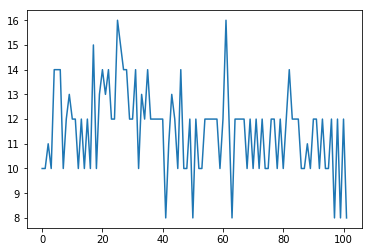

102


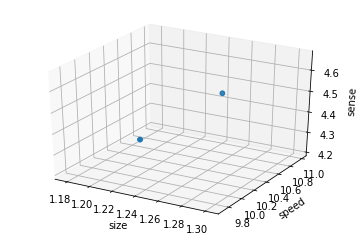

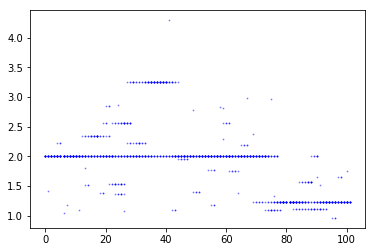

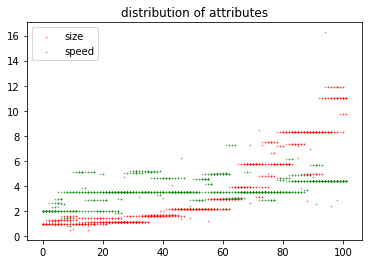

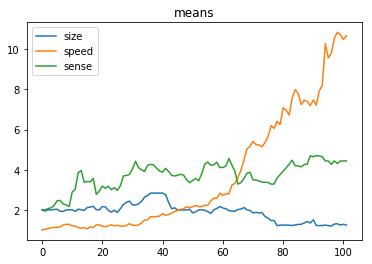

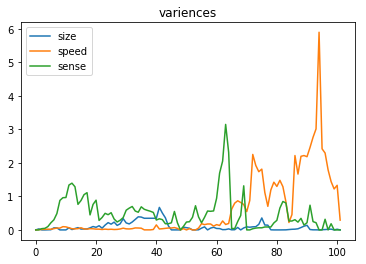

In [103]:
%matplotlib inline

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D # for 3D plotting

fig = plt.figure()
plt.plot(np.arange(0,len(stats["population"])), stats["population"])
plt.show()

print(len(stats["attributes"]))
atts = np.array(stats["attributes"][len(stats["attributes"])-1])

sizes = []
size_total = []
for att in stats["attributes"]:
    sizes.append(att)
    for vals in att:
        size_total.append(vals[0])

speeds = []
speed_total = []
for att in stats["attributes"]:
    speeds.append(att)
    for vals in att:
        speed_total.append(vals[1])
        
senses = []
sense_total = []
for att in stats["attributes"]:
    senses.append(att)
    for vals in att:
        sense_total.append(vals[2])        

plottime = []
time = 0
for i in range(len(sizes)):
    sametime = [time]*len(sizes[i])
    time += 1
    for j in sametime:
        plottime.append(j)


si = atts[:,0] 
sp = atts[:,1]
se = atts[:,2]
fig2 = plt.figure()
ax = fig2.gca(projection='3d')
ax.scatter(xs=si,ys=sp,zs=se)
ax.set_xlabel("size")
ax.set_ylabel("speed")
ax.set_zlabel("sense")
plt.show()

#print([atts.shape for atts in stats["attributes"]])
means = np.array([[np.mean(np.array(atts)[:,0]), np.mean(np.array(atts)[:,1]), np.mean(np.array(atts)[:,2])] if len(atts) > 1 else atts[0,:] for atts in stats["attributes"]])
variances =  np.array([[np.var(np.array(atts)[:,0]),  np.var(np.array(atts)[:,1]),  np.var(np.array(atts)[:,2])] if len(atts) > 1 else [0, 0, 0] for atts in stats["attributes"]])


#plot the attributes of organisms as a function of time
fig = plt.figure()
#print(stats["attributes"])
plt.scatter(plottime, size_total, c = 'blue', s = 0.7, alpha = 0.4)
plt.show()
fig = plt.figure()
plt.scatter(plottime, speed_total, c = 'red', s = 0.7, alpha = 0.4)
plt.scatter(plottime, sense_total, c = 'green', s = 0.7, alpha = 0.4)
plt.legend(["size", "speed", "sense"])
plt.title("distribution of attributes")
plt.show()

fig = plt.figure()
plt.plot(np.arange(0,len(means)), means[:,0])
plt.plot(np.arange(0,len(means)), means[:,1])
plt.plot(np.arange(0,len(means)), means[:,2])
plt.legend(["size", "speed", "sense"])
plt.title("means")
plt.show()

fig = plt.figure()
plt.plot(np.arange(0,len(variances)), variances[:,0])
plt.plot(np.arange(0,len(variances)), variances[:,1])
plt.plot(np.arange(0,len(variances)), variances[:,2])
plt.legend(["size", "speed", "sense"])
plt.title("variences")
plt.show()